# Analytics - Product Quality

#### Date: 28/06/2023

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:

- Amanda Gonçalves
- Arthur Miranda
- Arthur Rodrigues
- Álvaro Leles
- Fause Carlos
- Filipe Souto
- Gabriel Avelino
- Gabriel Bonifácio
- Gabriel Saraiva
- Guilherme de Morais
- Gustavo Costa
- Ian Fillipe
- Italo Vinicius
- Ítalo Fernandes
- Júlia Stefanie
- Mariana Letícia
- Mateus Fidelis


### LIBRARIES

In [54]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [55]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [56]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [57]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-1-schedula-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'front': 'tsx',
    'gestor_de_usuarios': 'ts',
    'detalhador_de_chamados': 'ts',
    'gerenciador_de_localidades': 'ts',
    'gerenciador_de_tutoriais': 'ts',
    'gestor_de_alerta': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [58]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/*.json')

## Create DataFrame

#### Unmarshall json

In [59]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [60]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [61]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [62]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [63]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [64]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [65]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2023-1-schedula-detalhador_de_chamados',
       'fga-eps-mds-2023-1-schedula-front',
       'fga-eps-mds-2023-1-schedula-gerenciador_de_localidades',
       'fga-eps-mds-2023-1-schedula-gerenciador_de_tutoriais',
       'fga-eps-mds-2023-1-schedula-gestor_de_alerta',
       'fga-eps-mds-2023-1-schedula-gestor_de_usuarios'], dtype=object)

### Create dataframe per repository

In [66]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [67]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [68]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [69]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [70]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [71]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [72]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [73]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [74]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [75]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

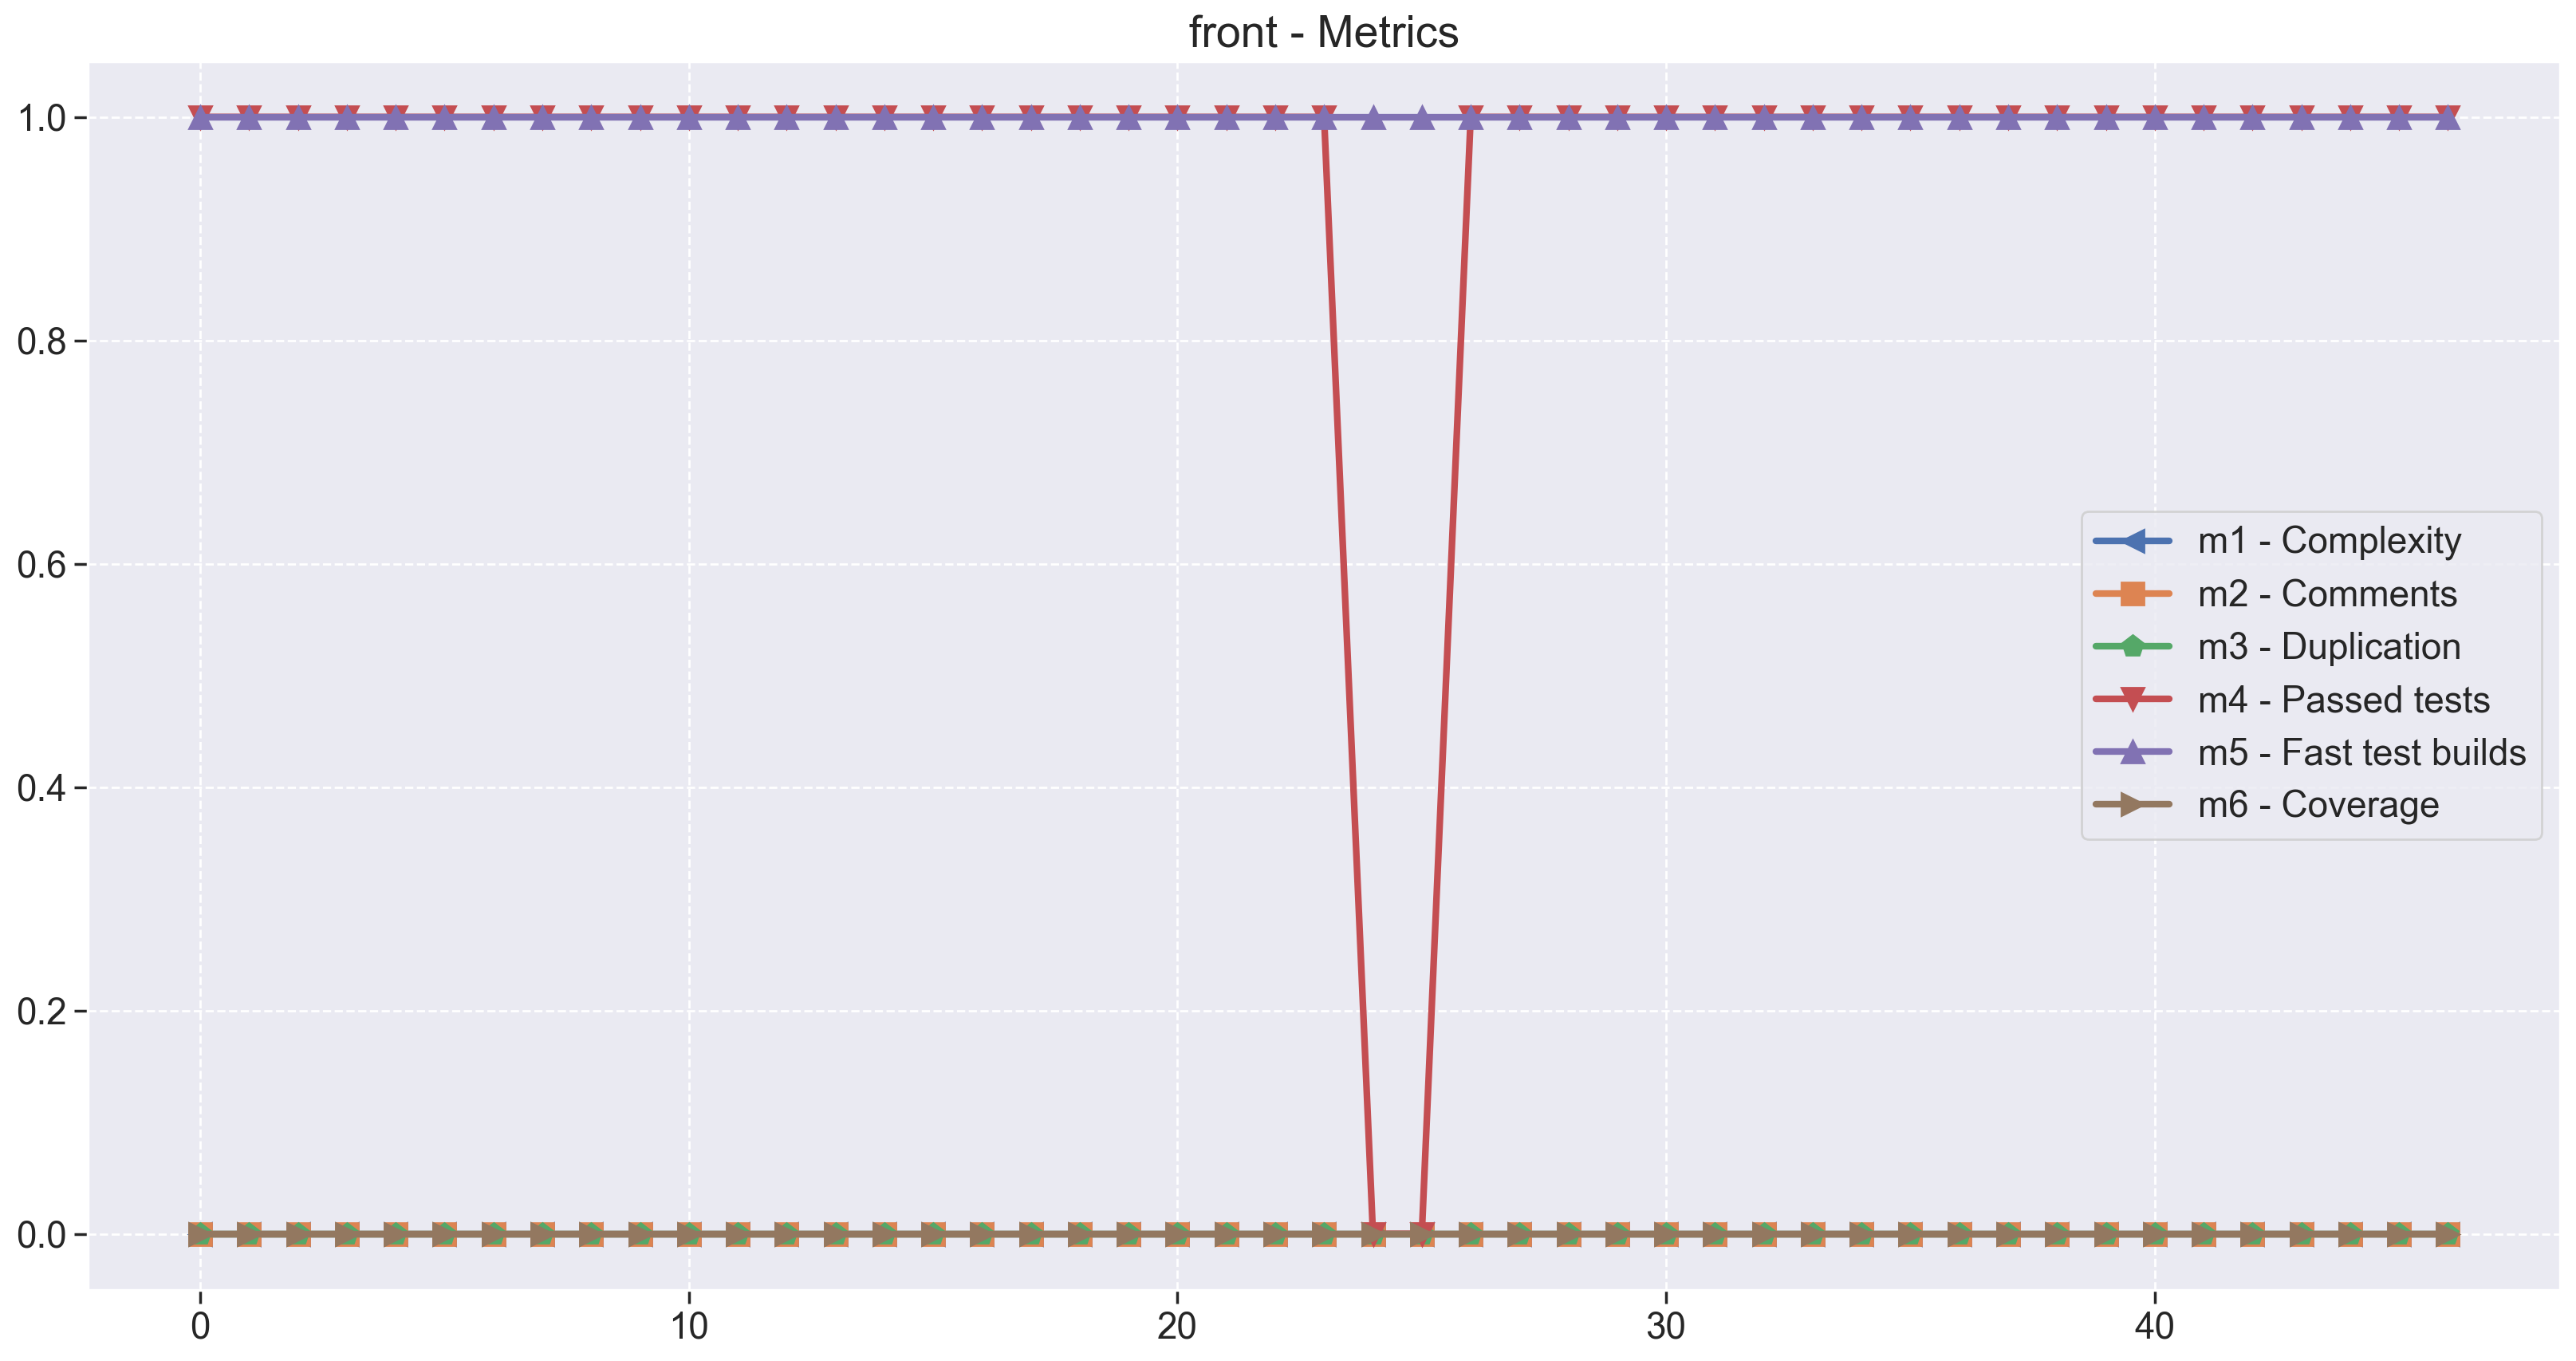

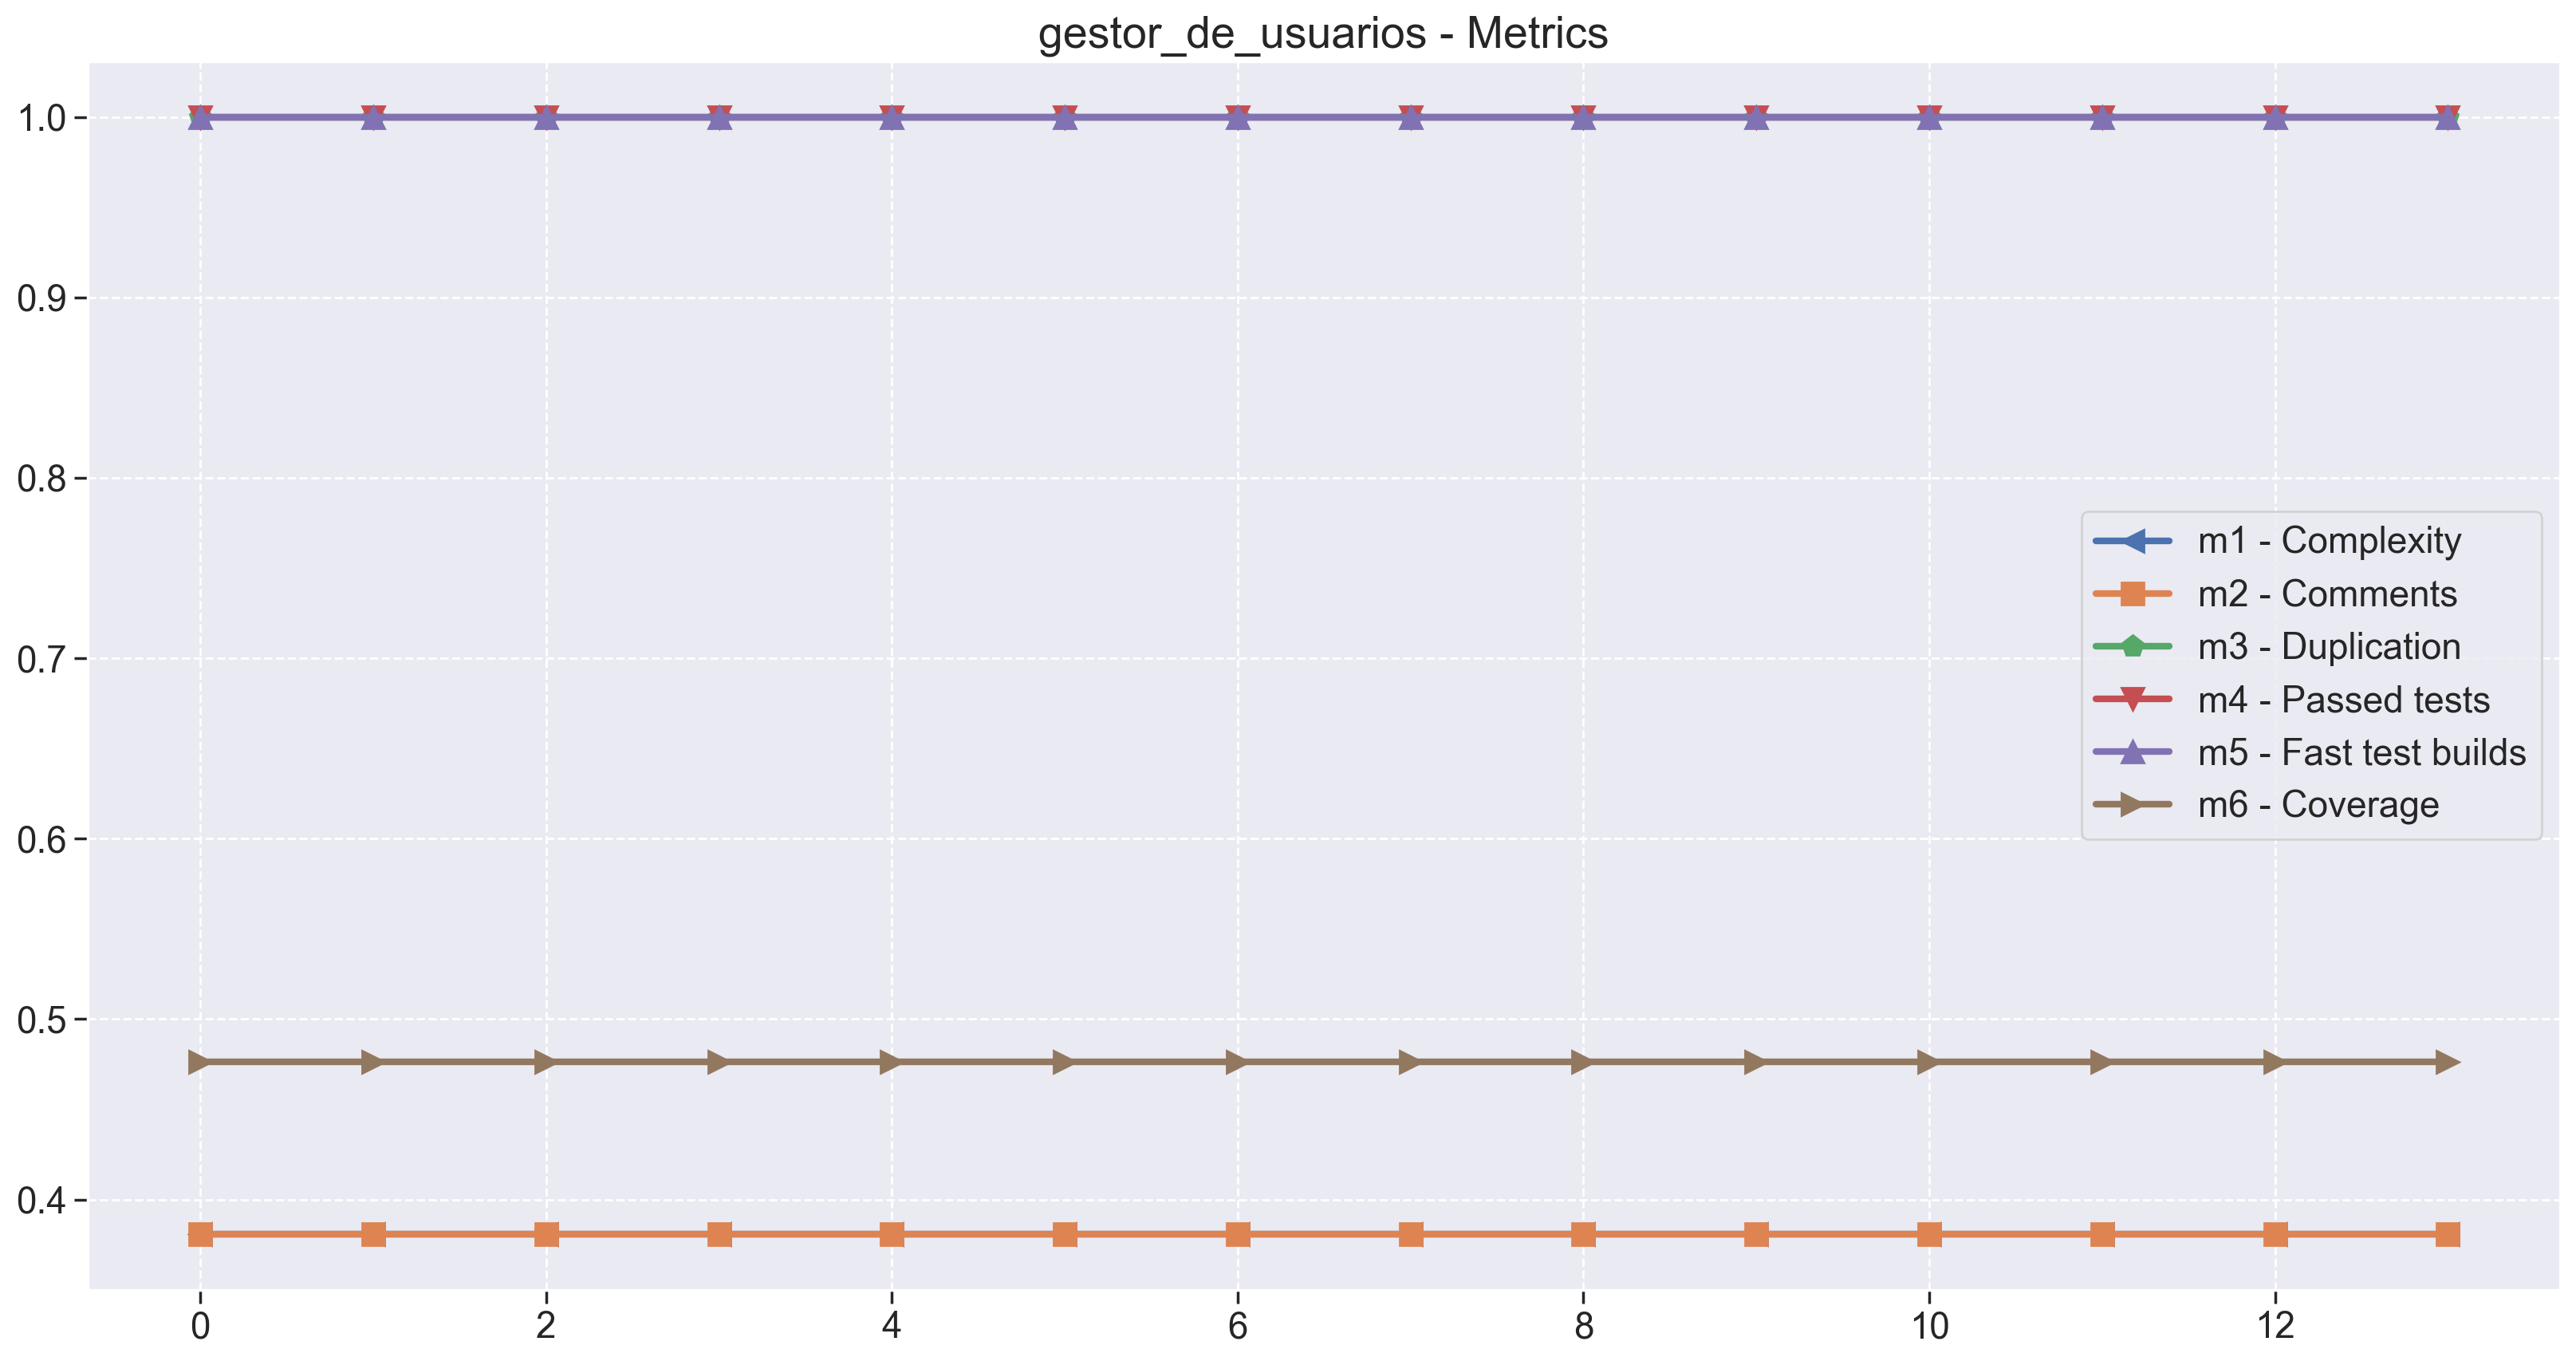

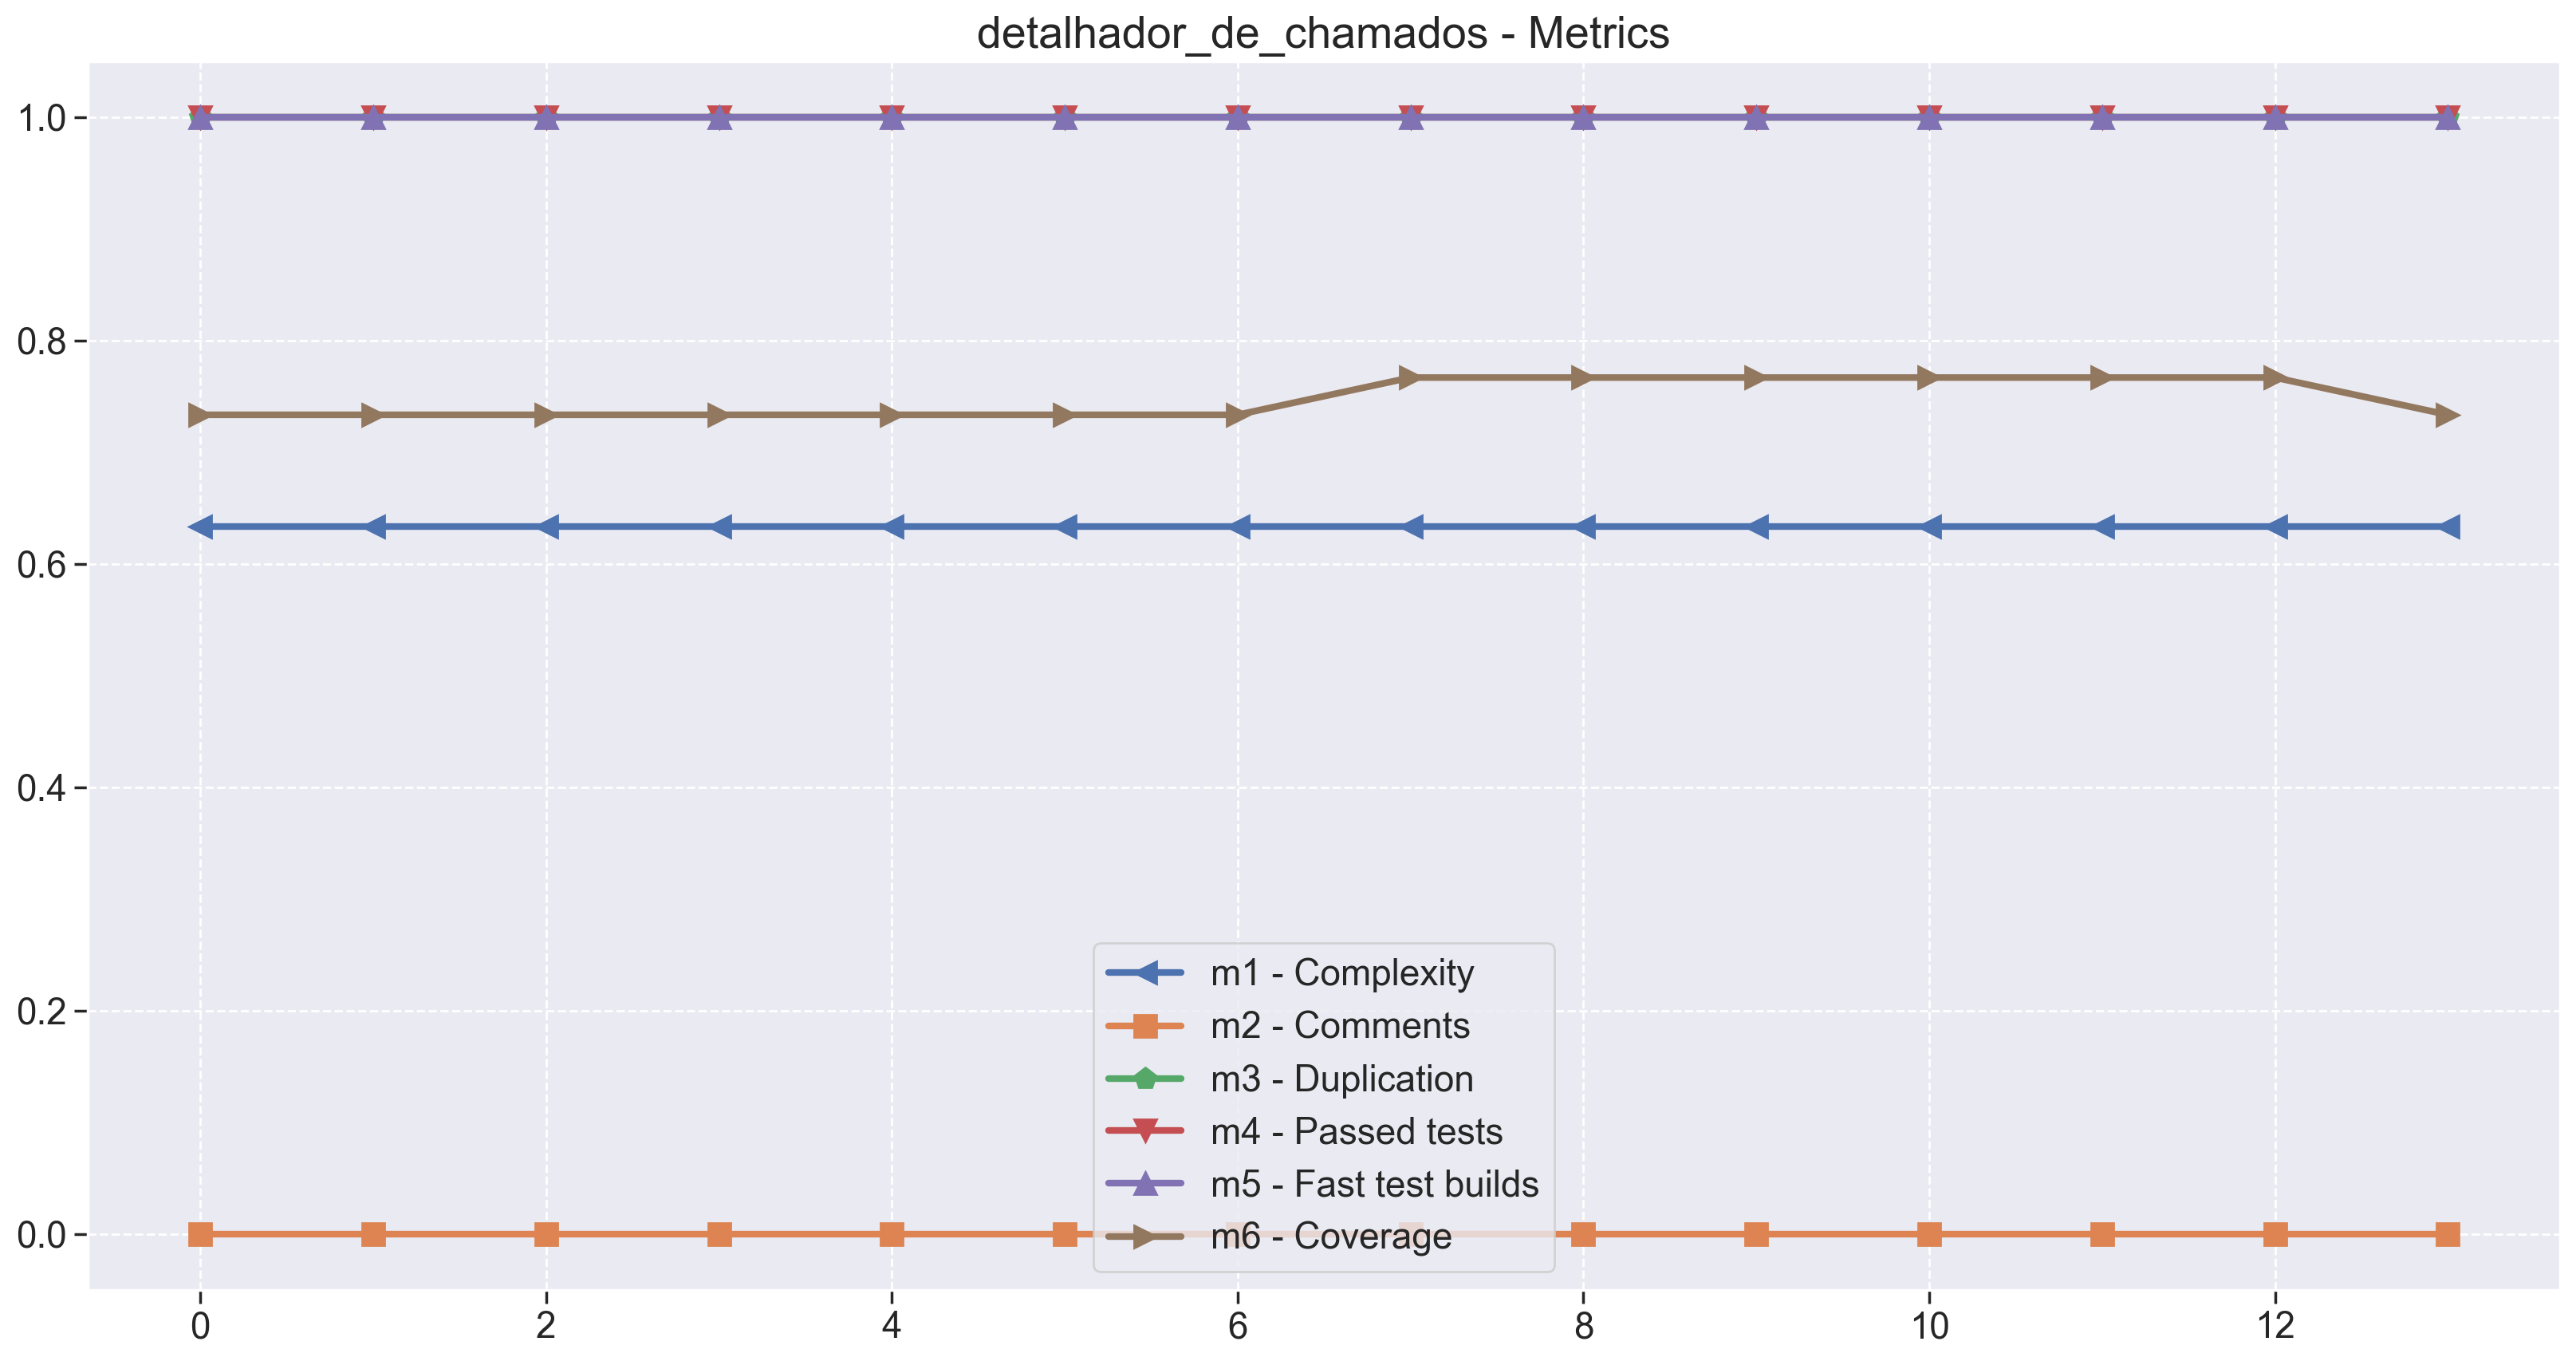

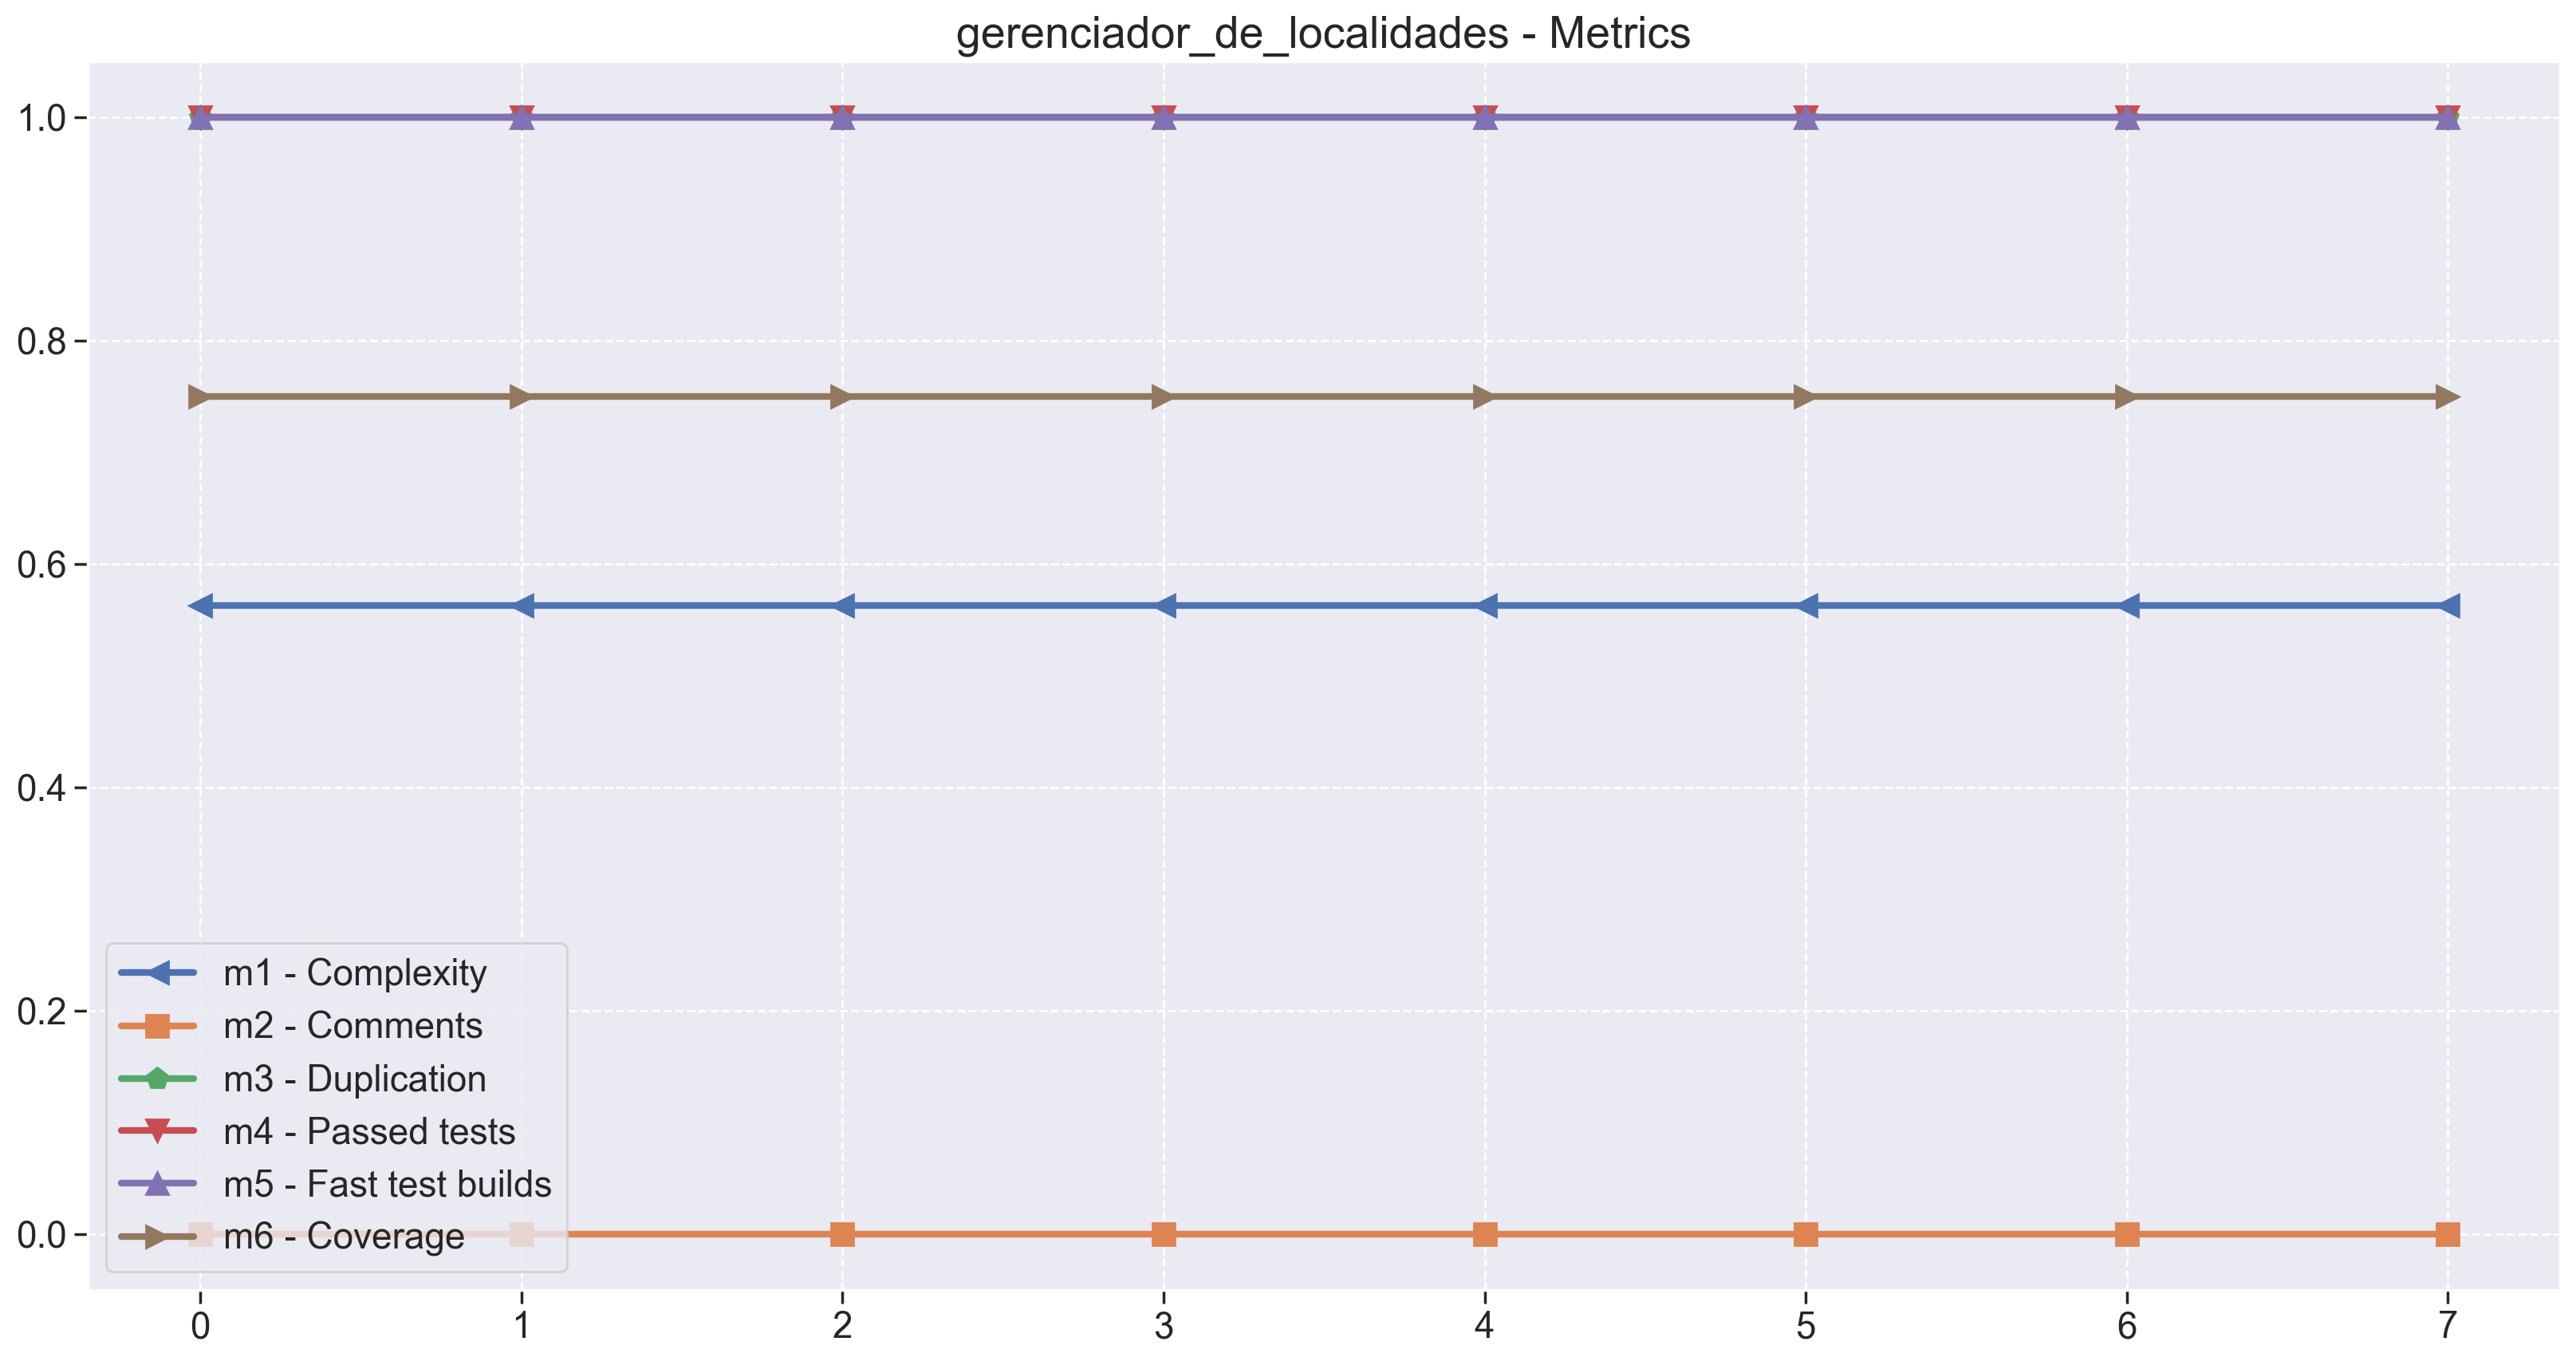

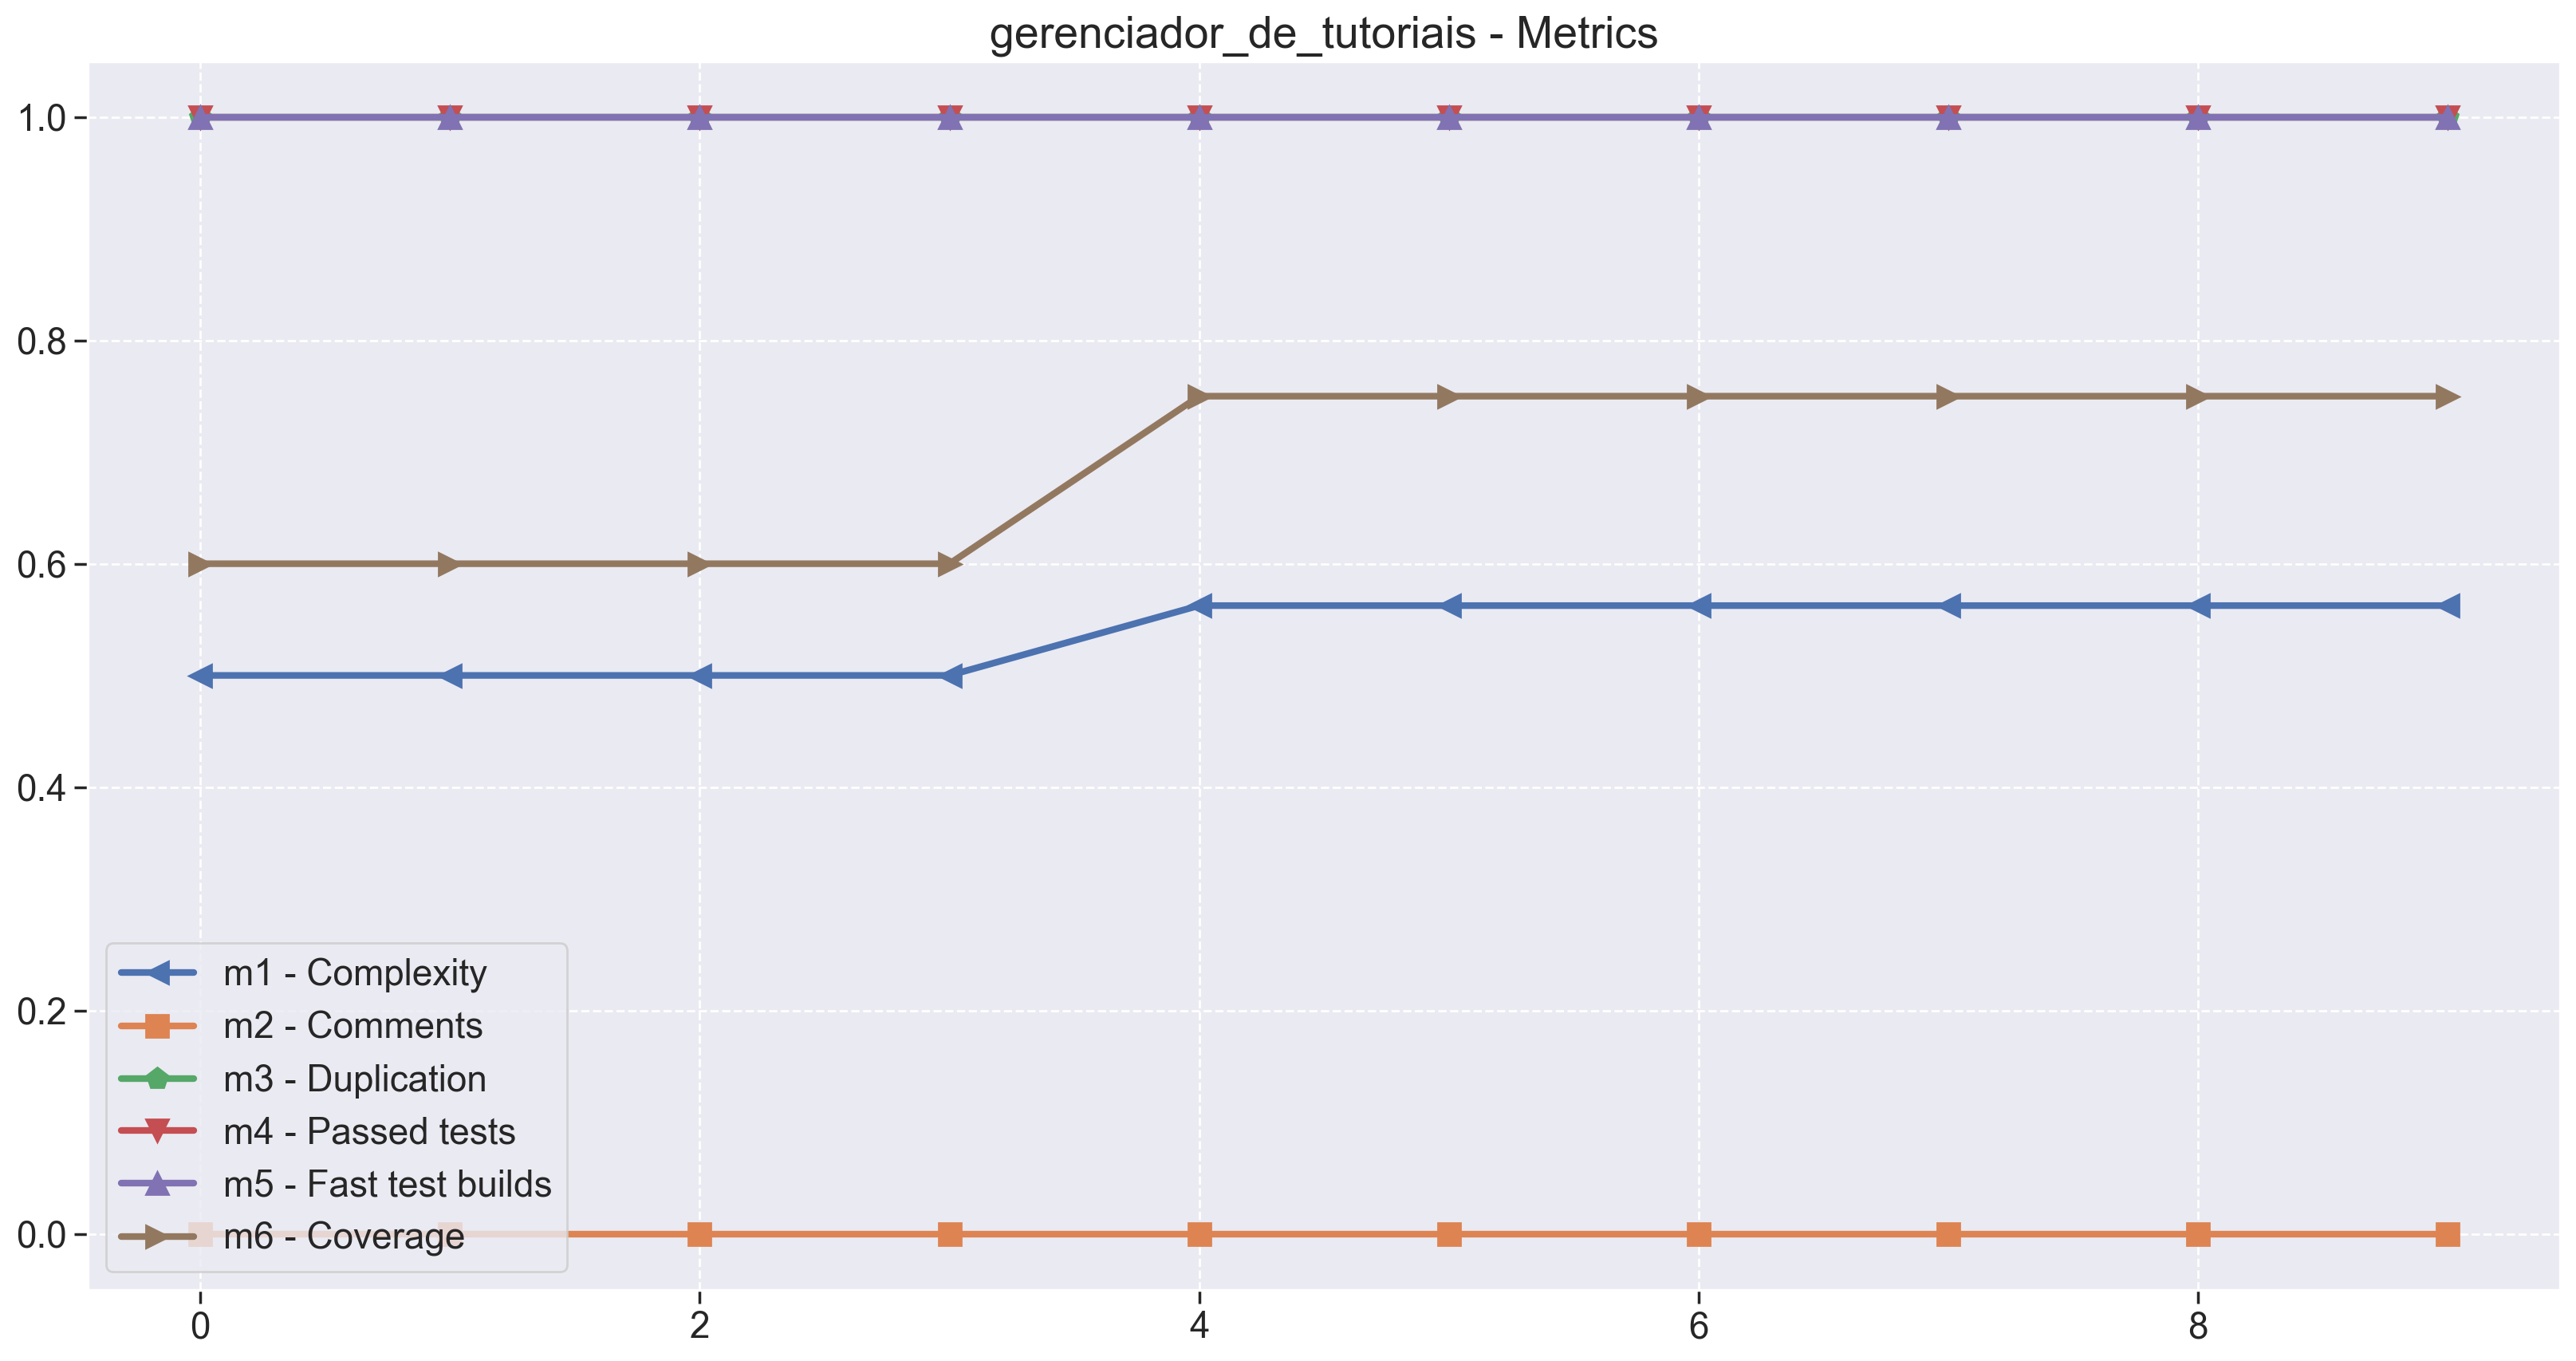

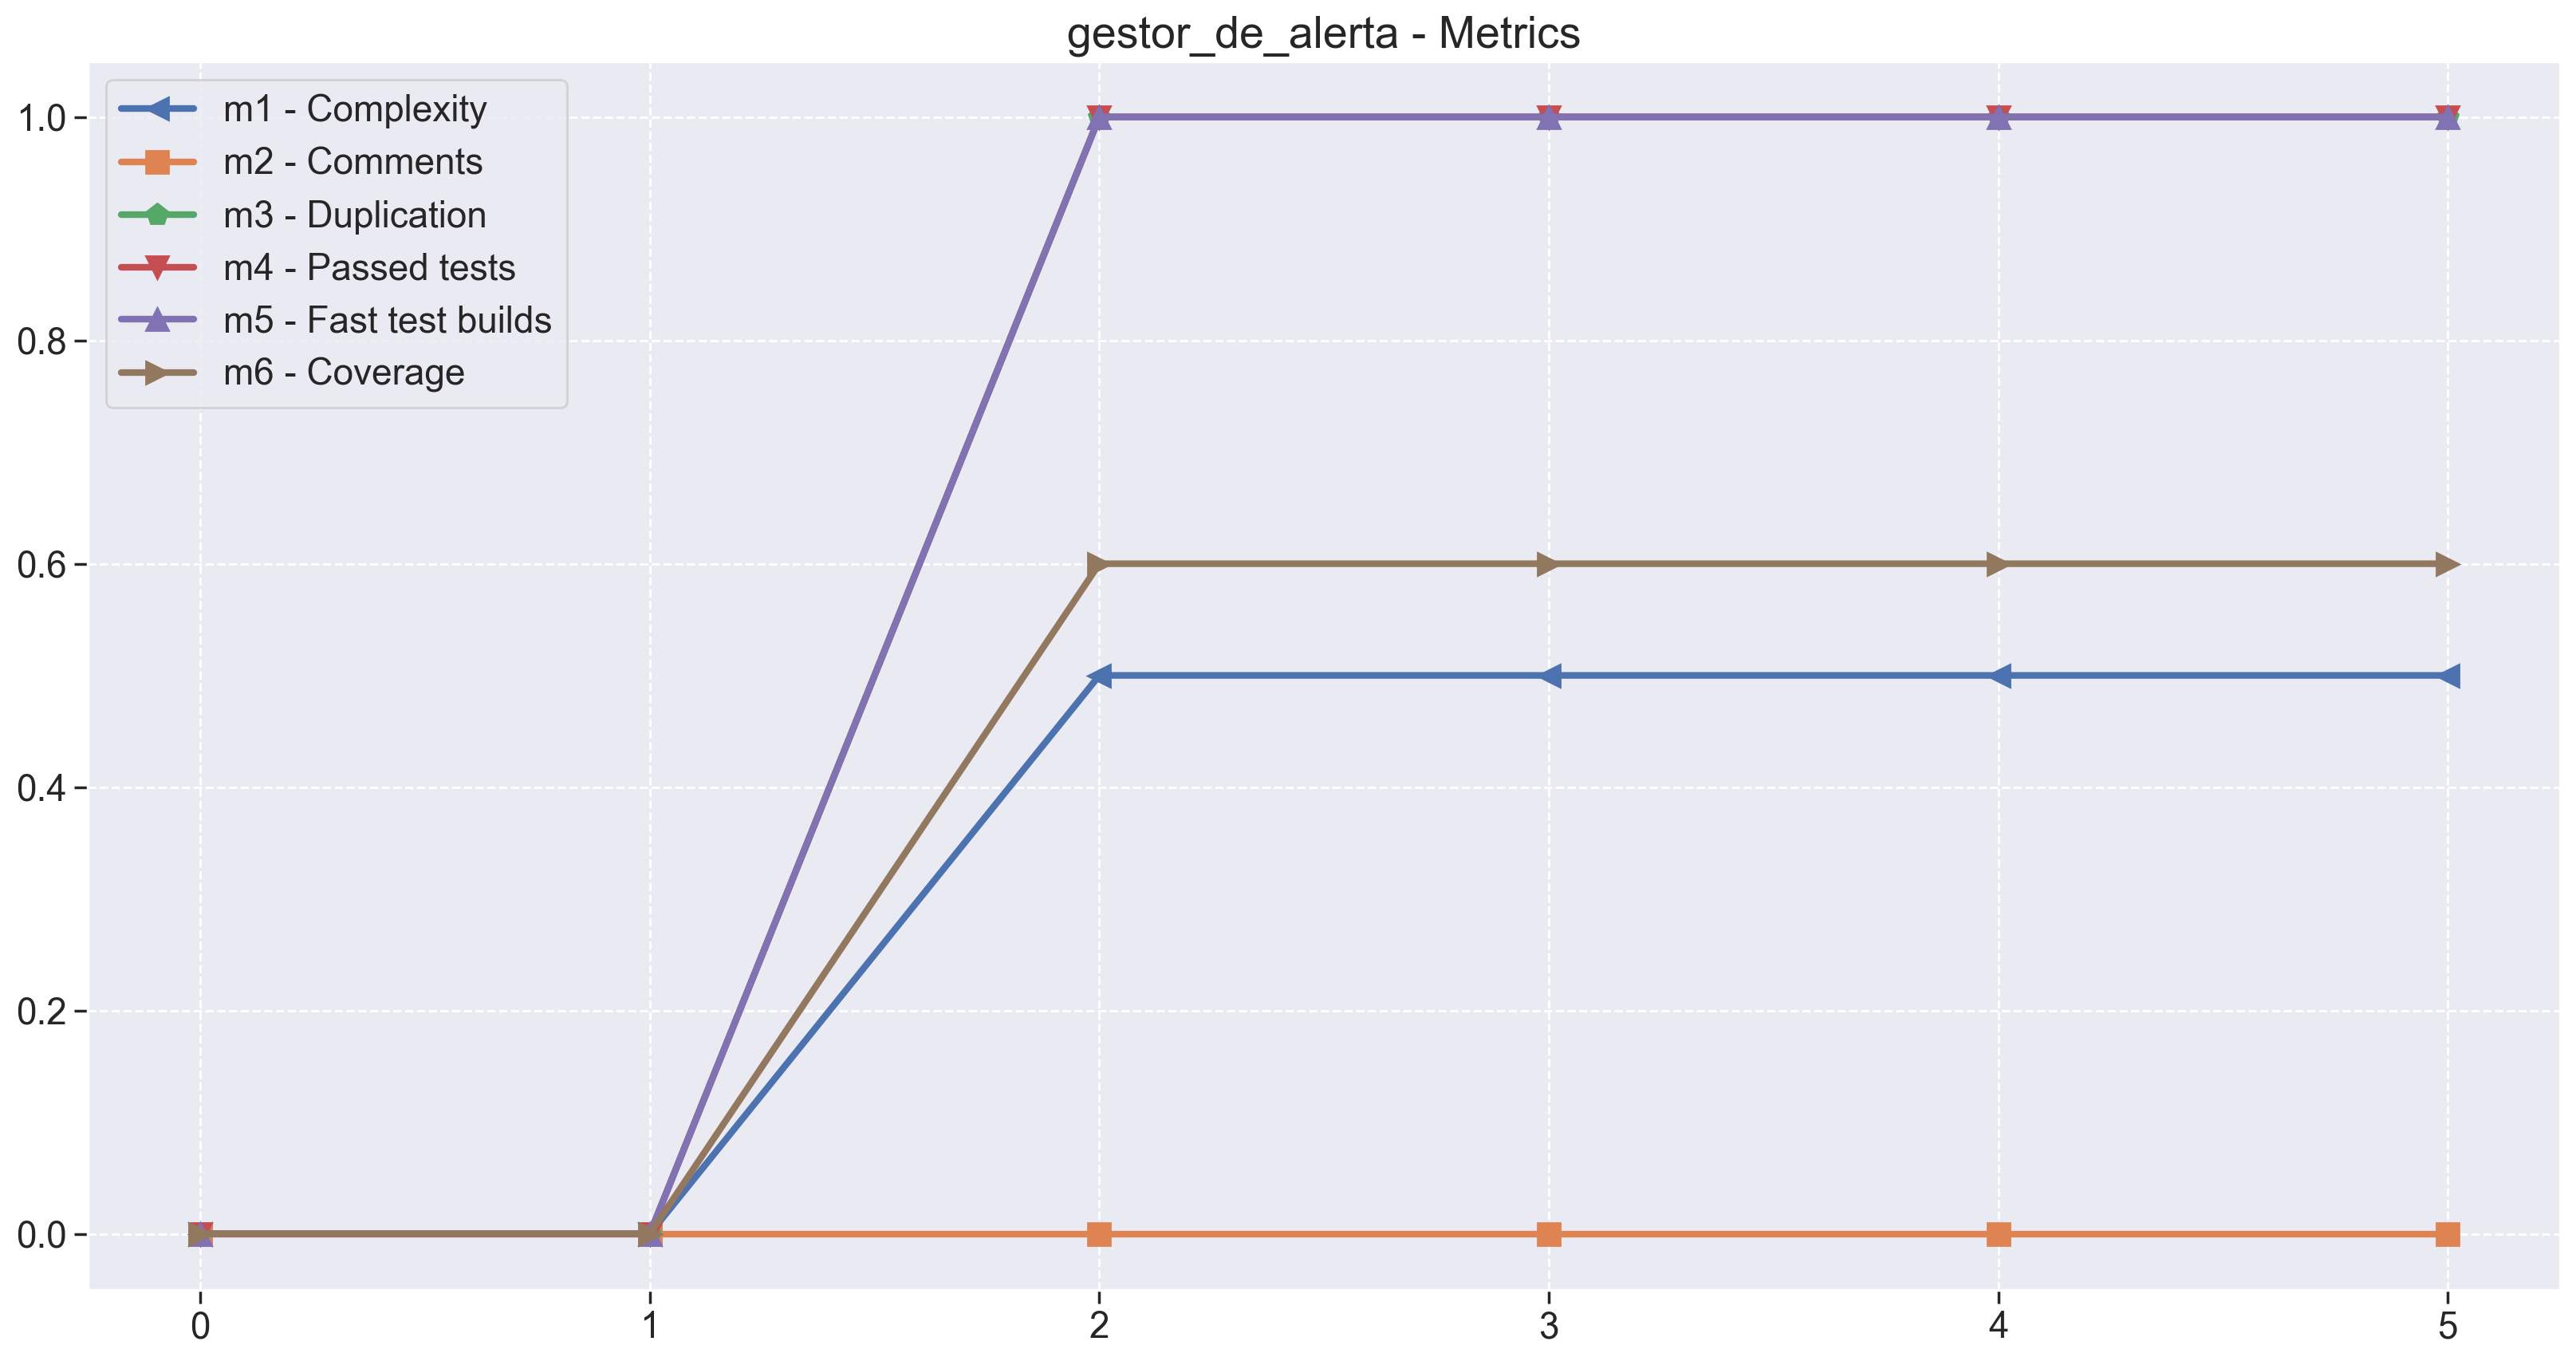

In [76]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [77]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

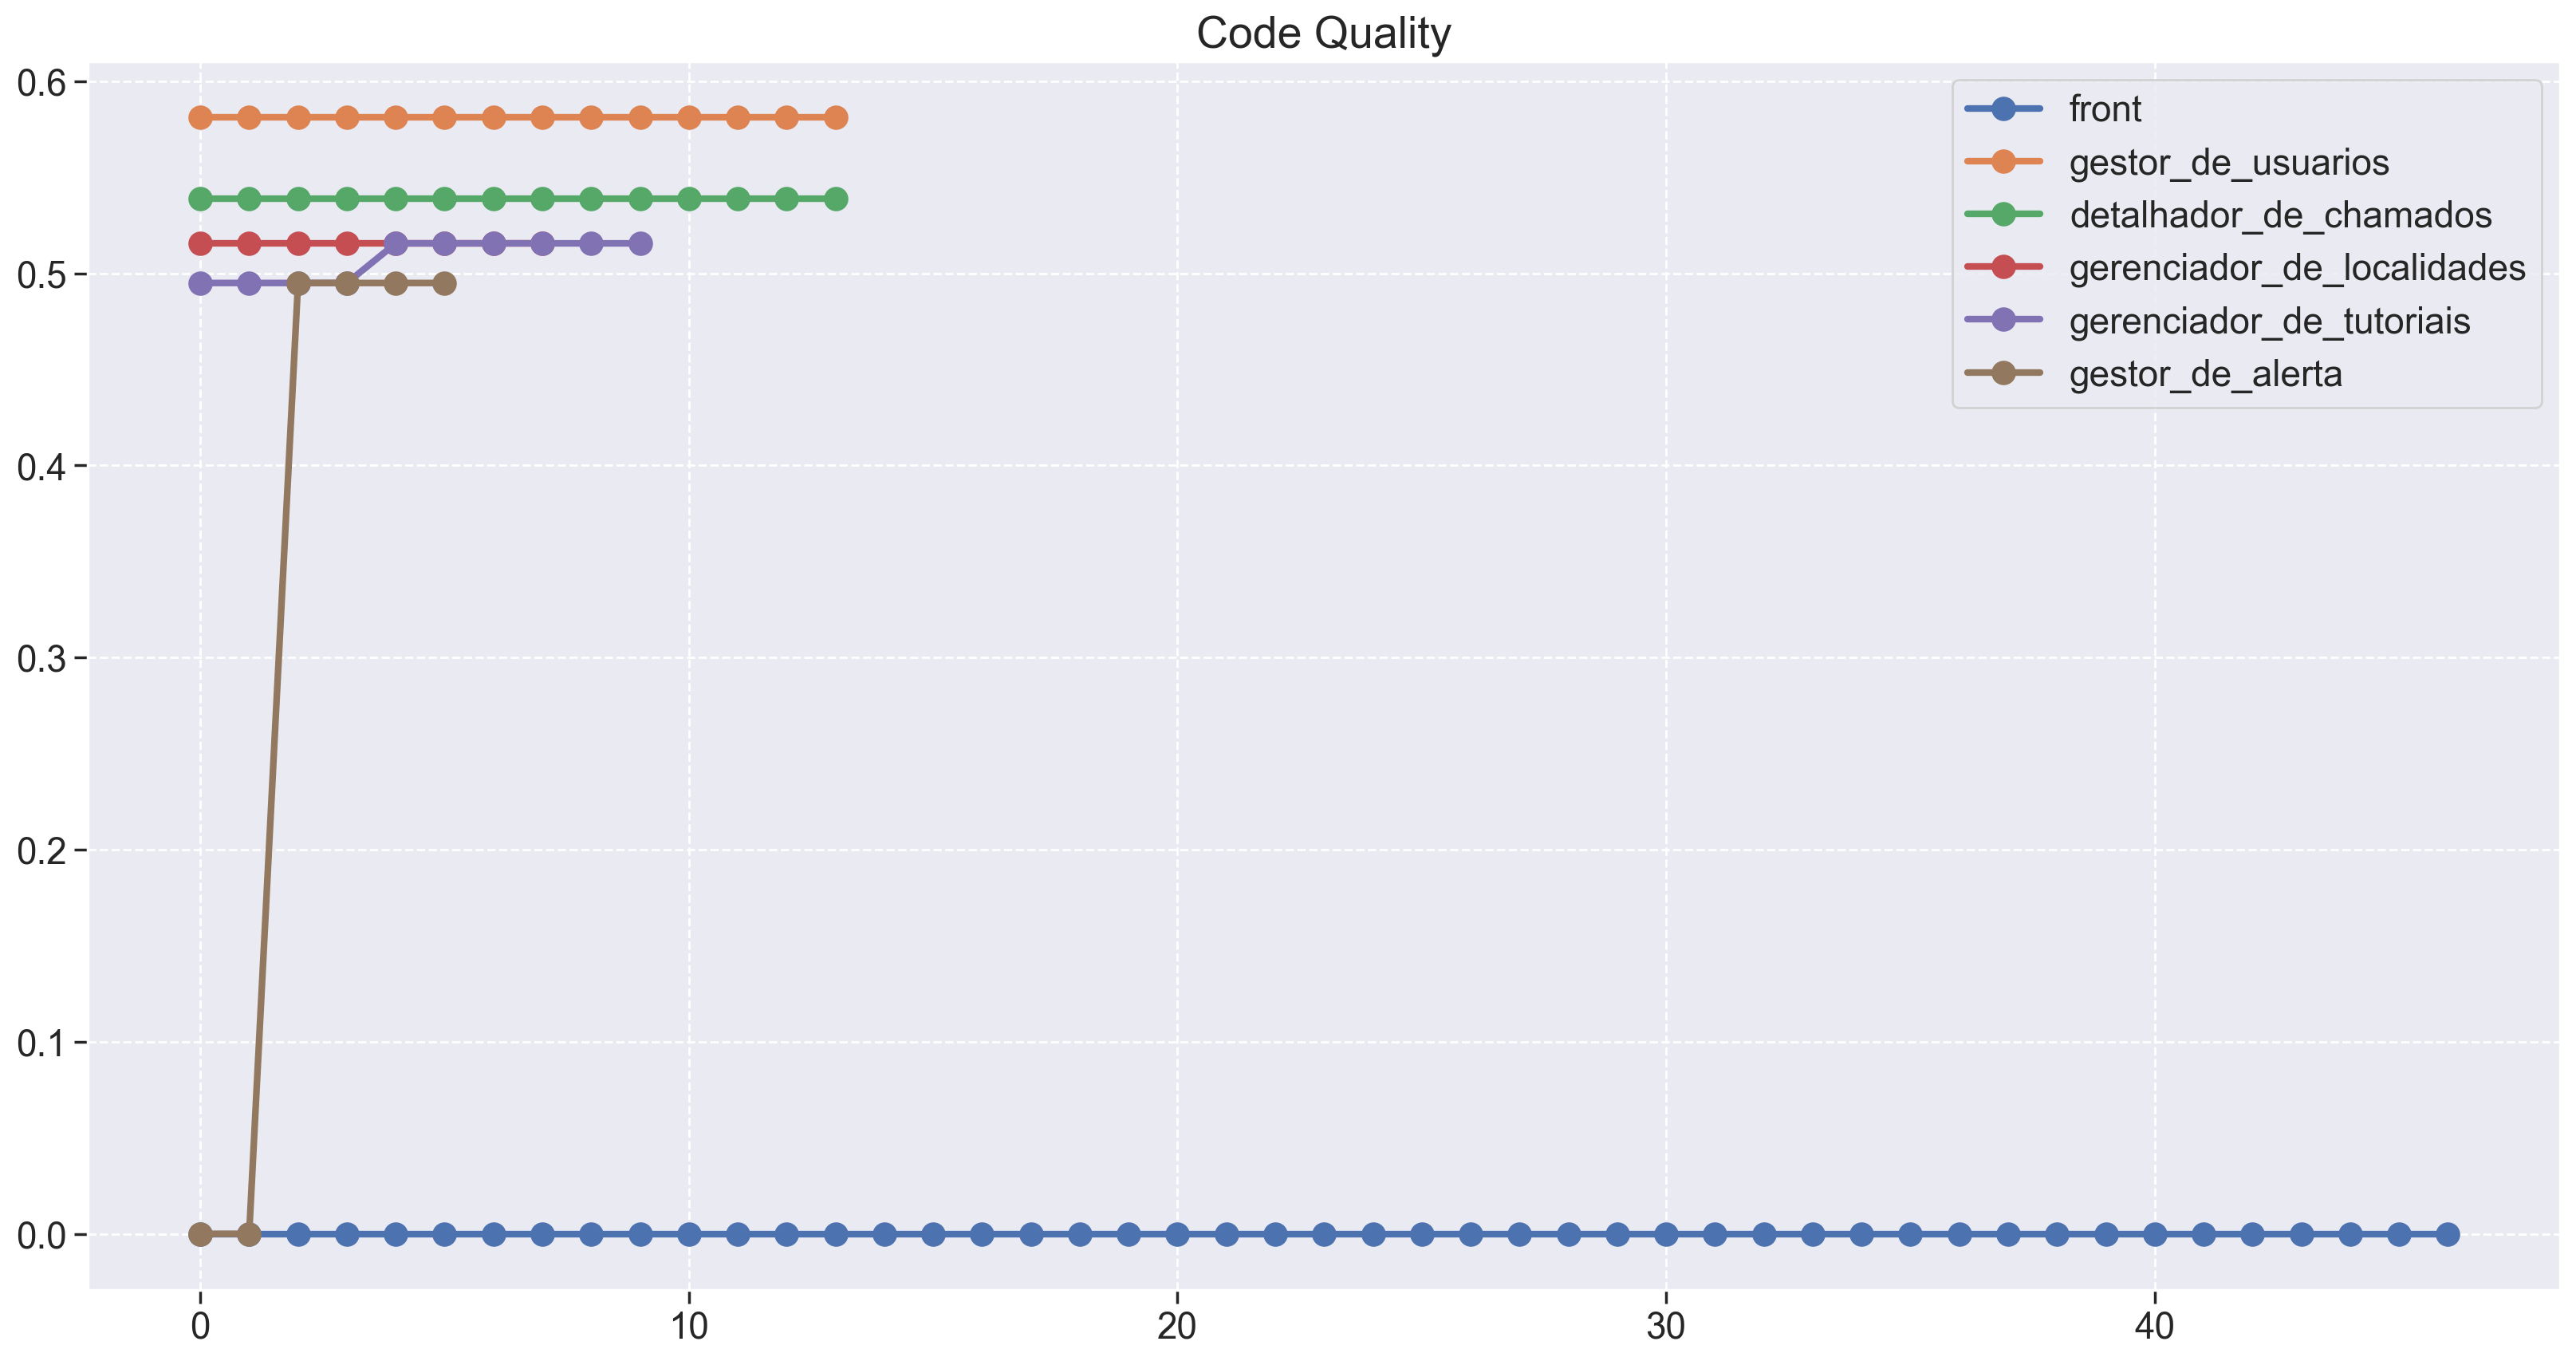

In [78]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

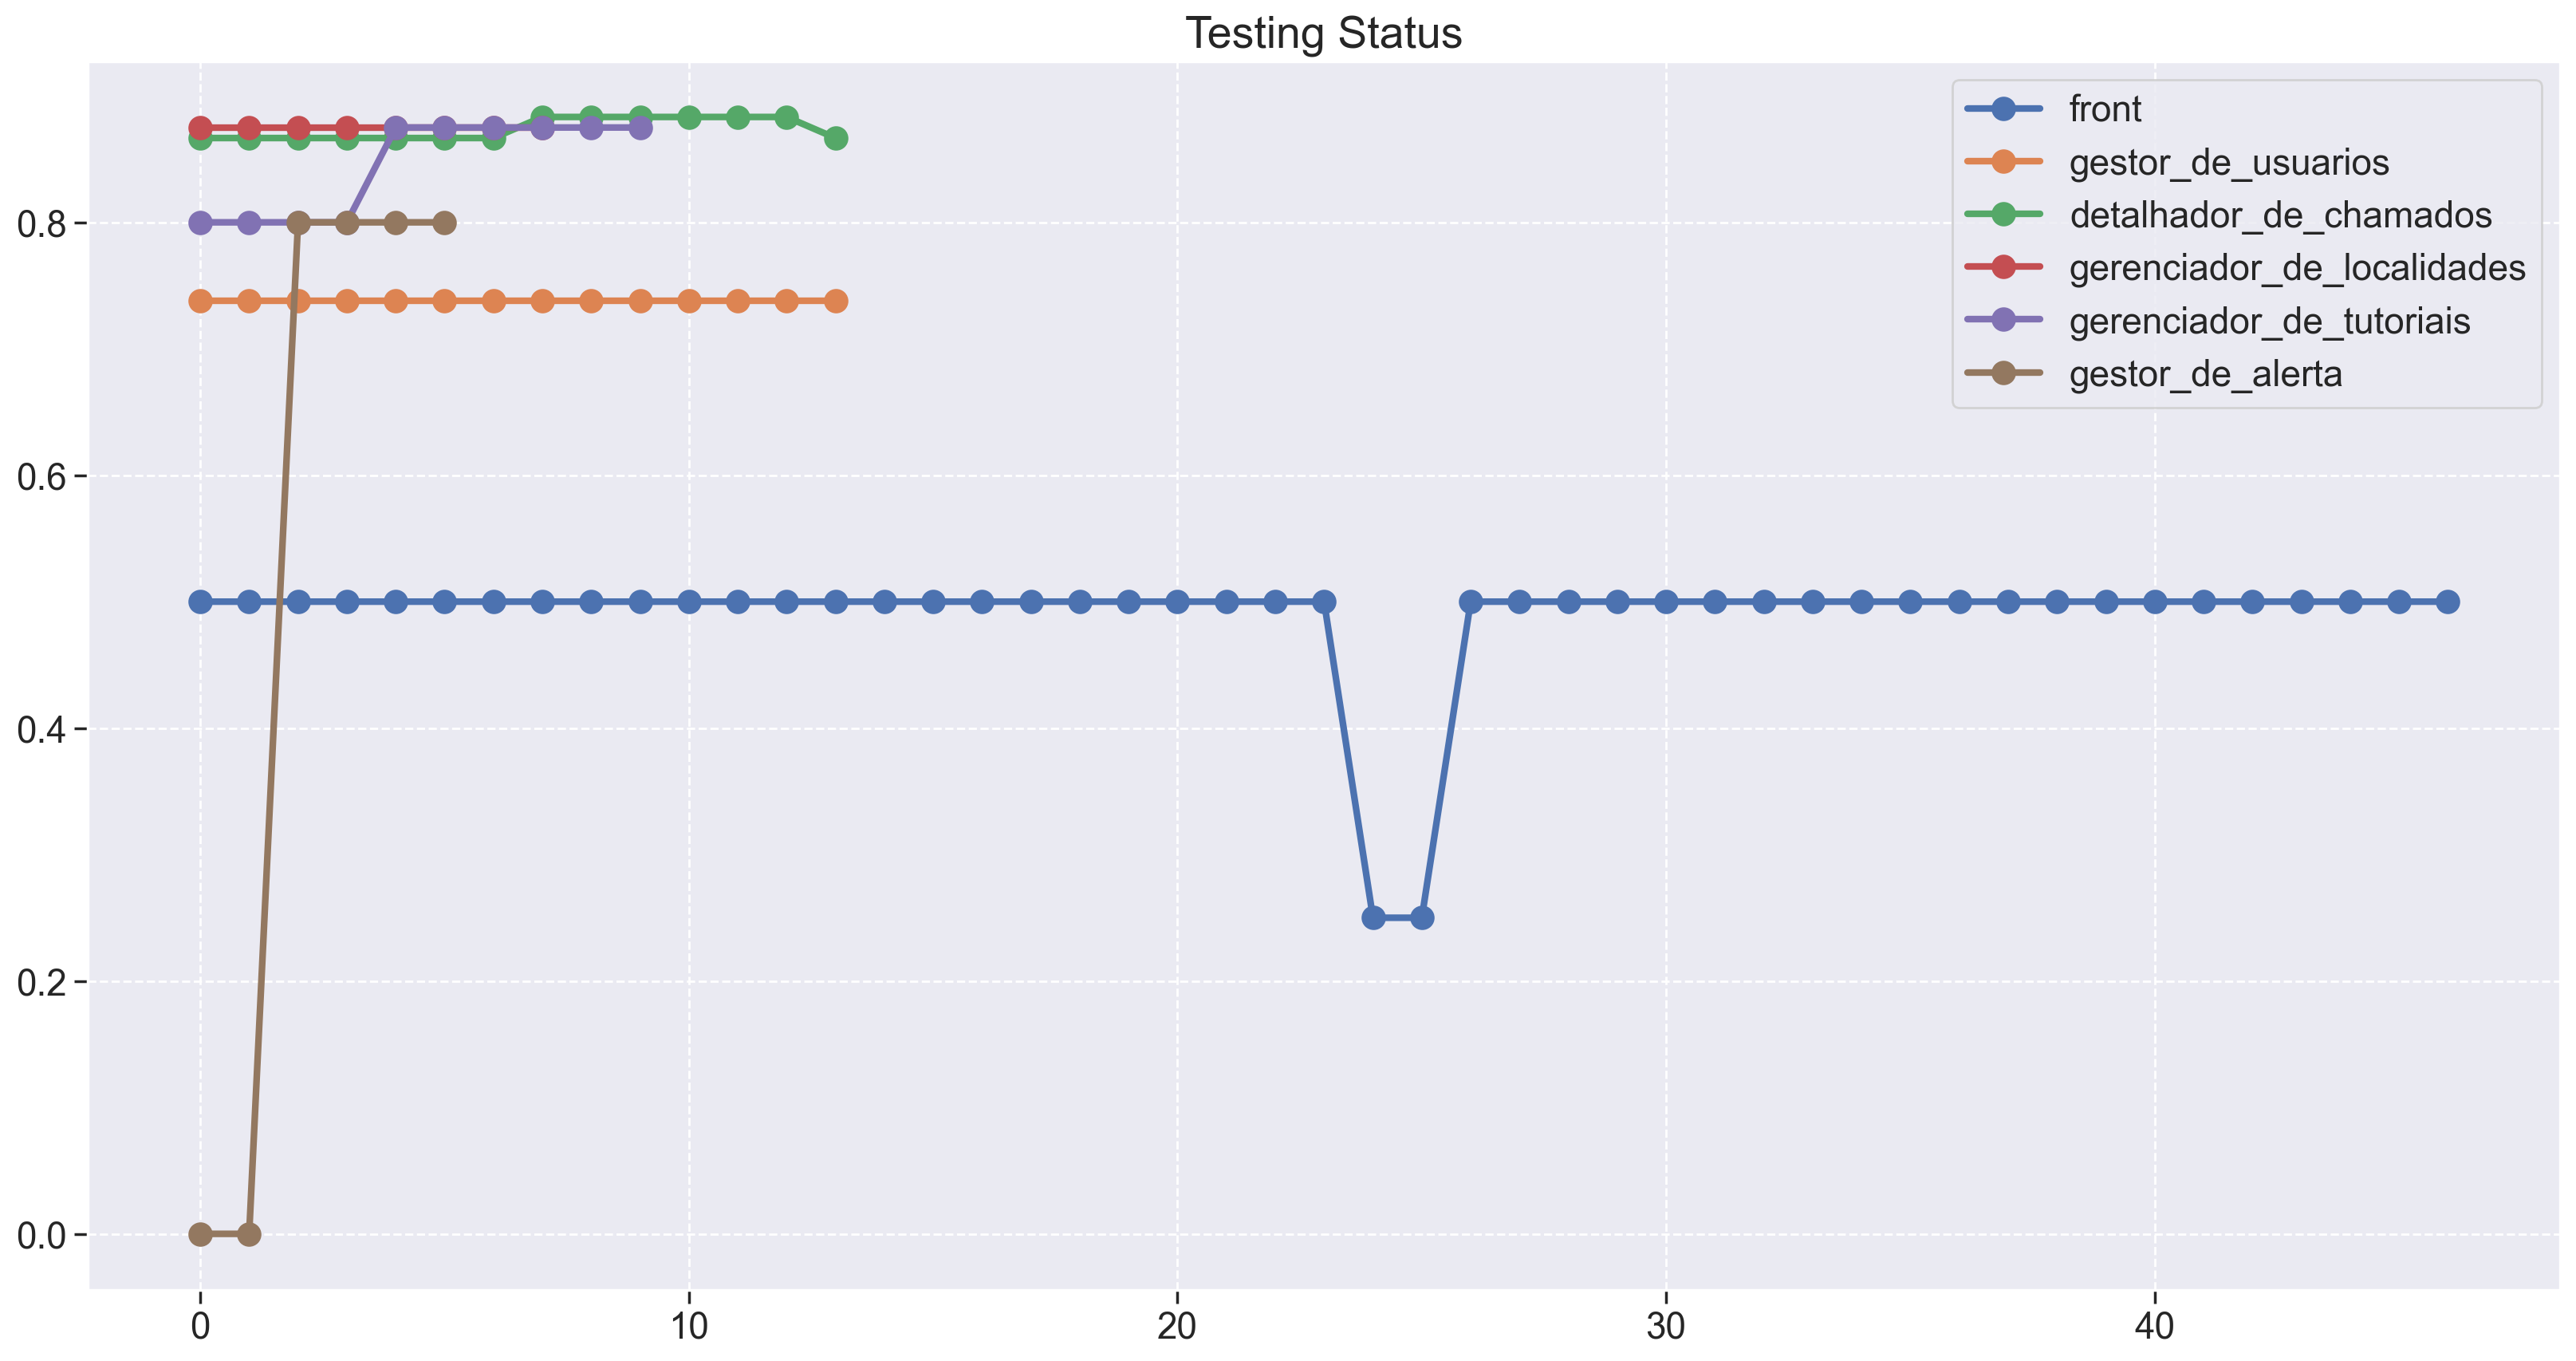

In [79]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [80]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [81]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [82]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

front
Maintainability Stats
 mean  mode  median  std  var  min  max
  0.0   0.0     0.0  0.0  0.0  0.0  0.0
Reliability Stats
    mean  mode  median      std     var   min  max
0.244681  0.25    0.25 0.025504 0.00065 0.125 0.25


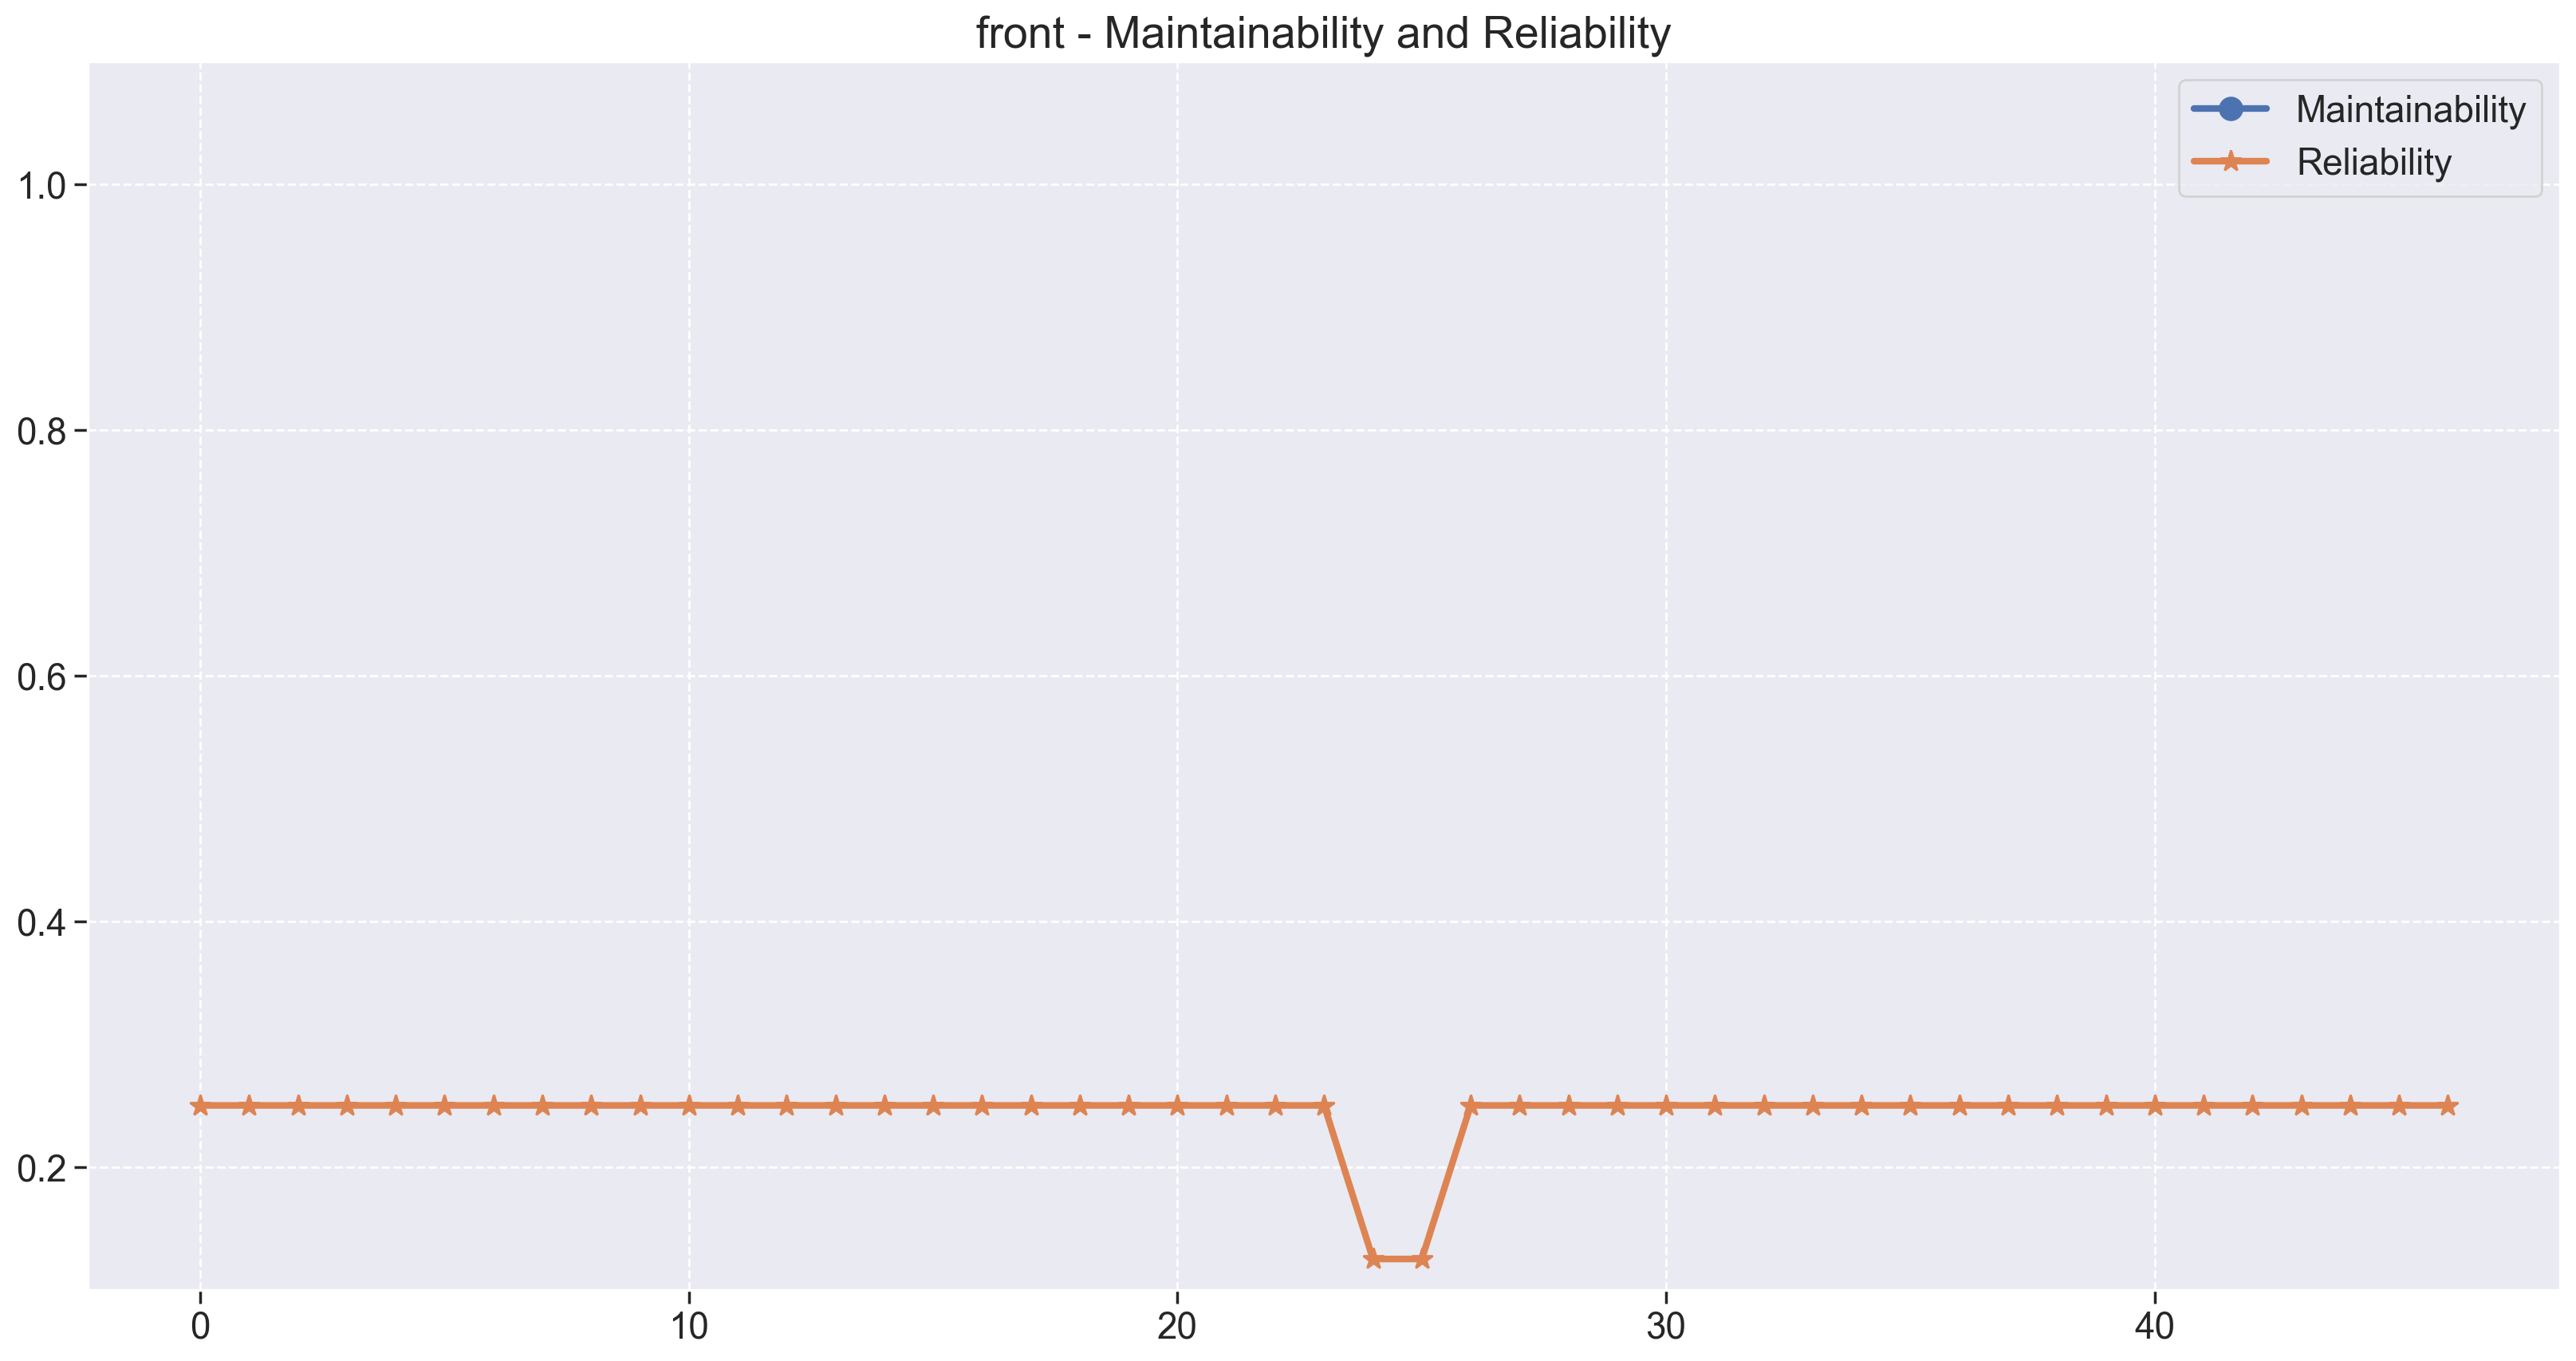

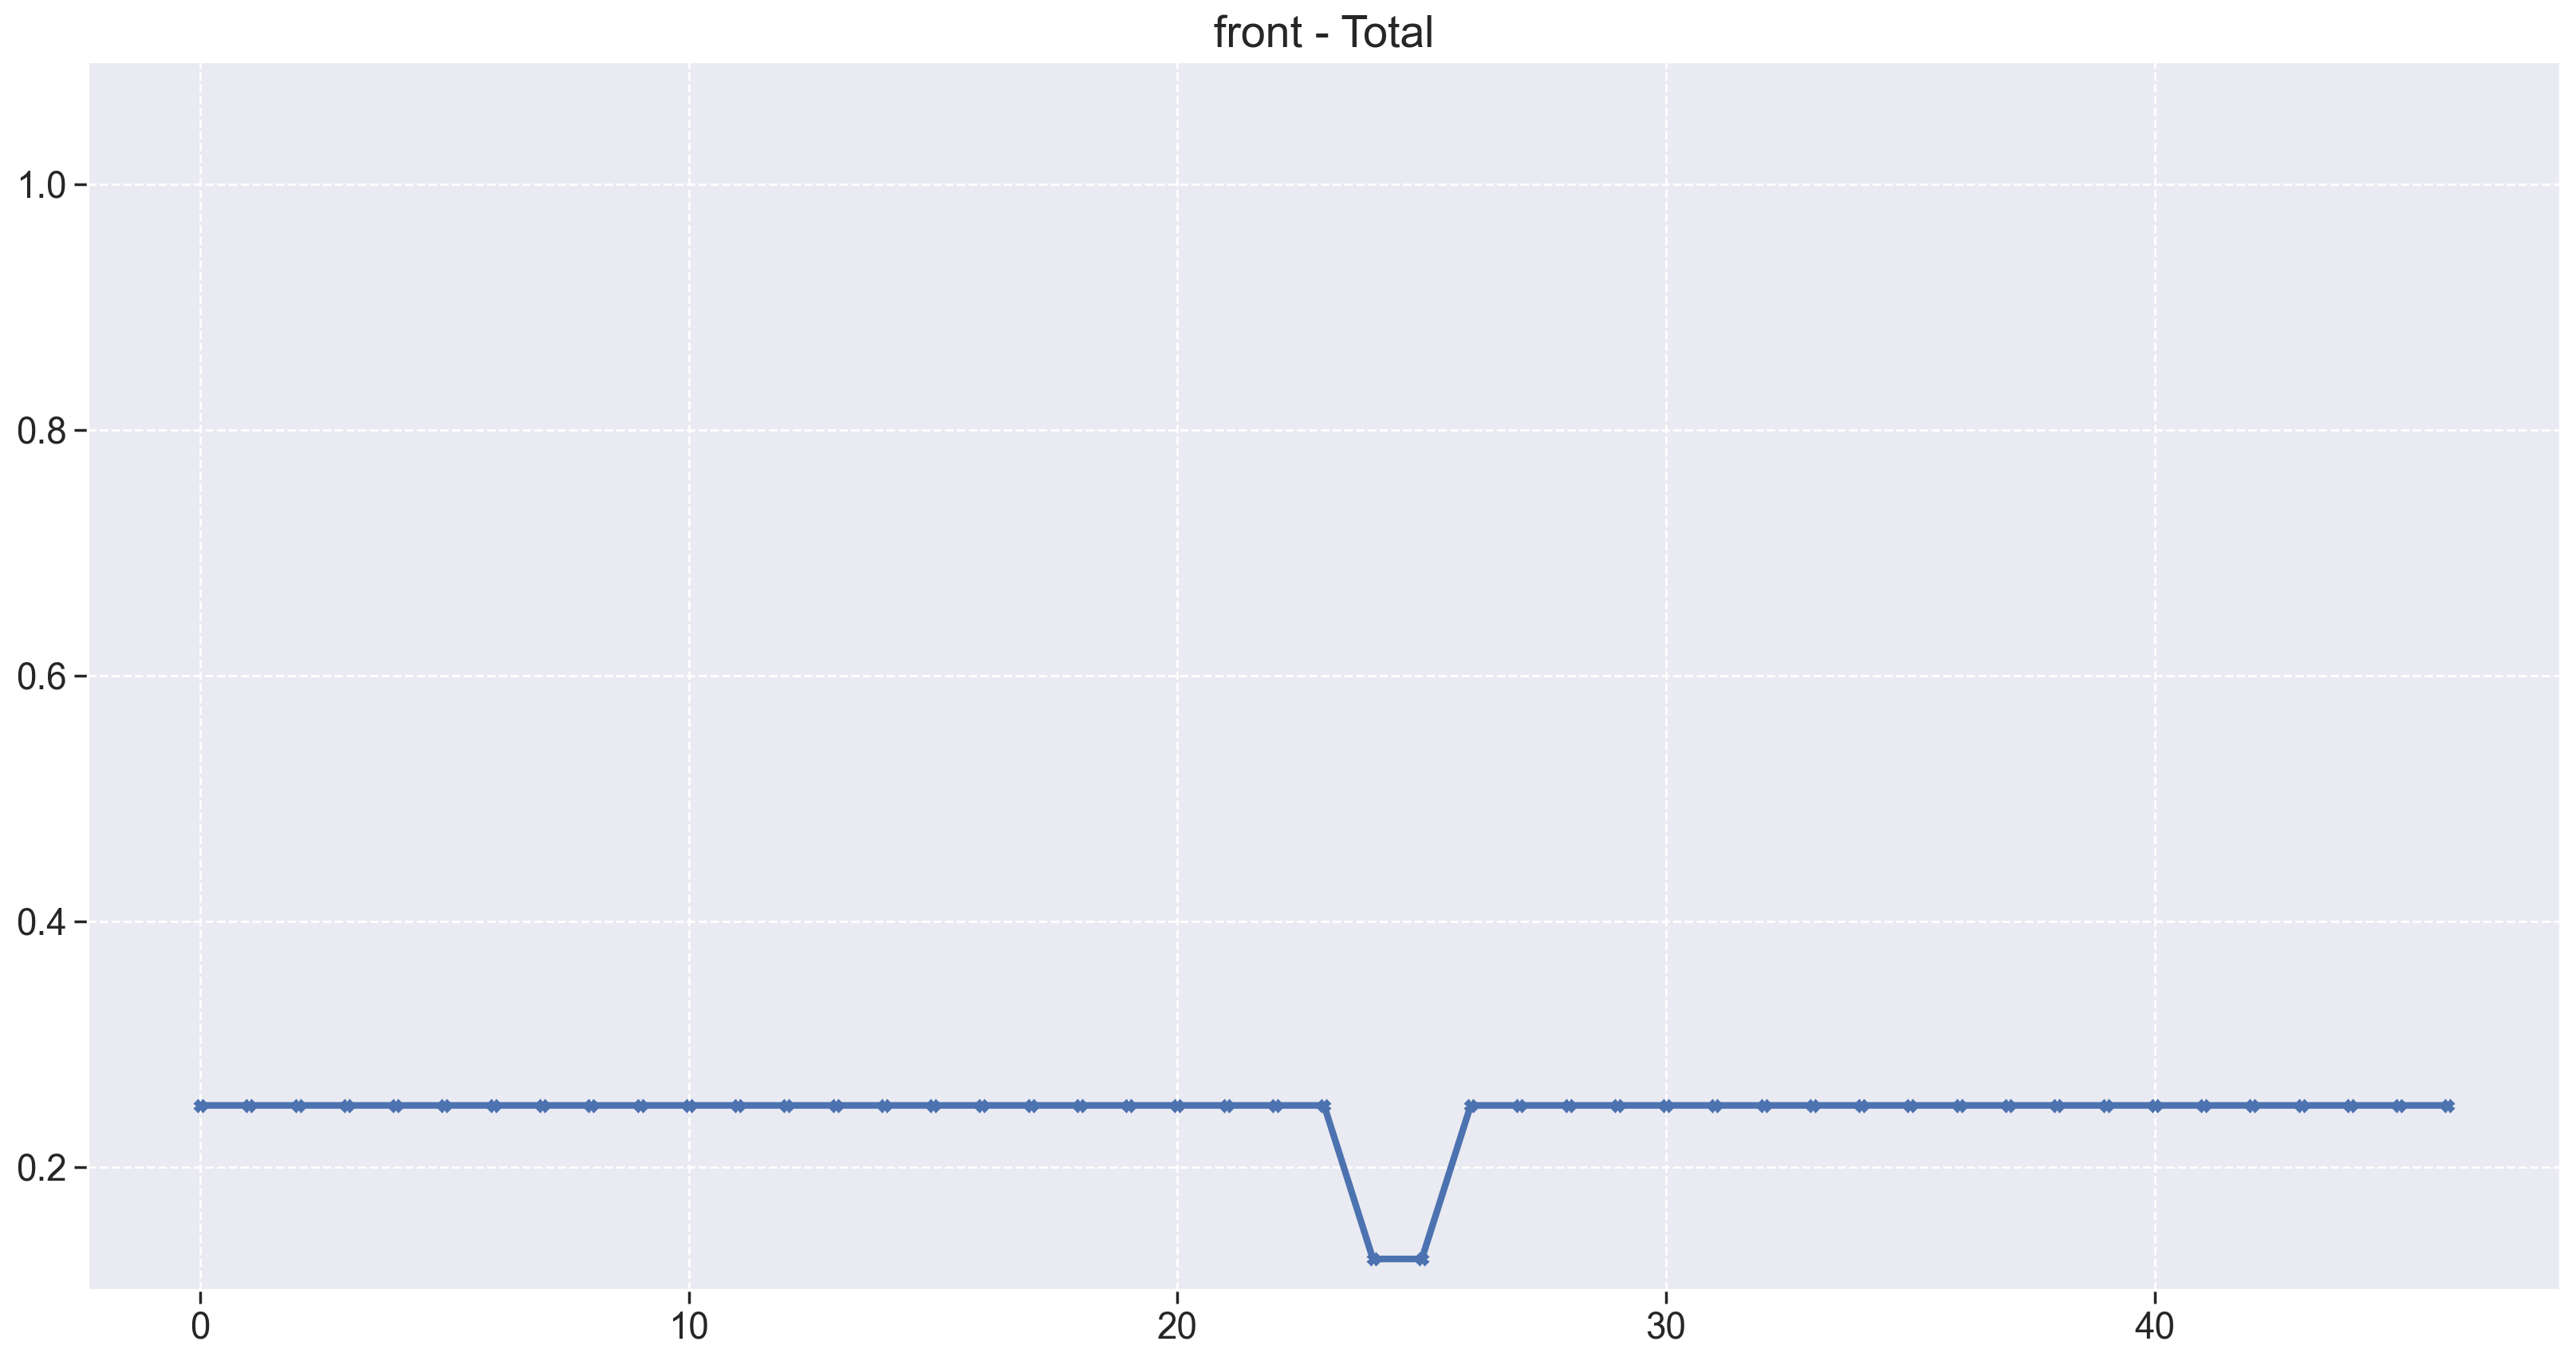

gestor_de_usuarios
Maintainability Stats
    mean     mode   median          std          var      min      max
0.290714 0.290714 0.290714 1.152133e-16 1.327410e-32 0.290714 0.290714
Reliability Stats
    mean     mode   median          std          var      min      max
0.369048 0.369048 0.369048 5.760664e-17 3.318525e-33 0.369048 0.369048


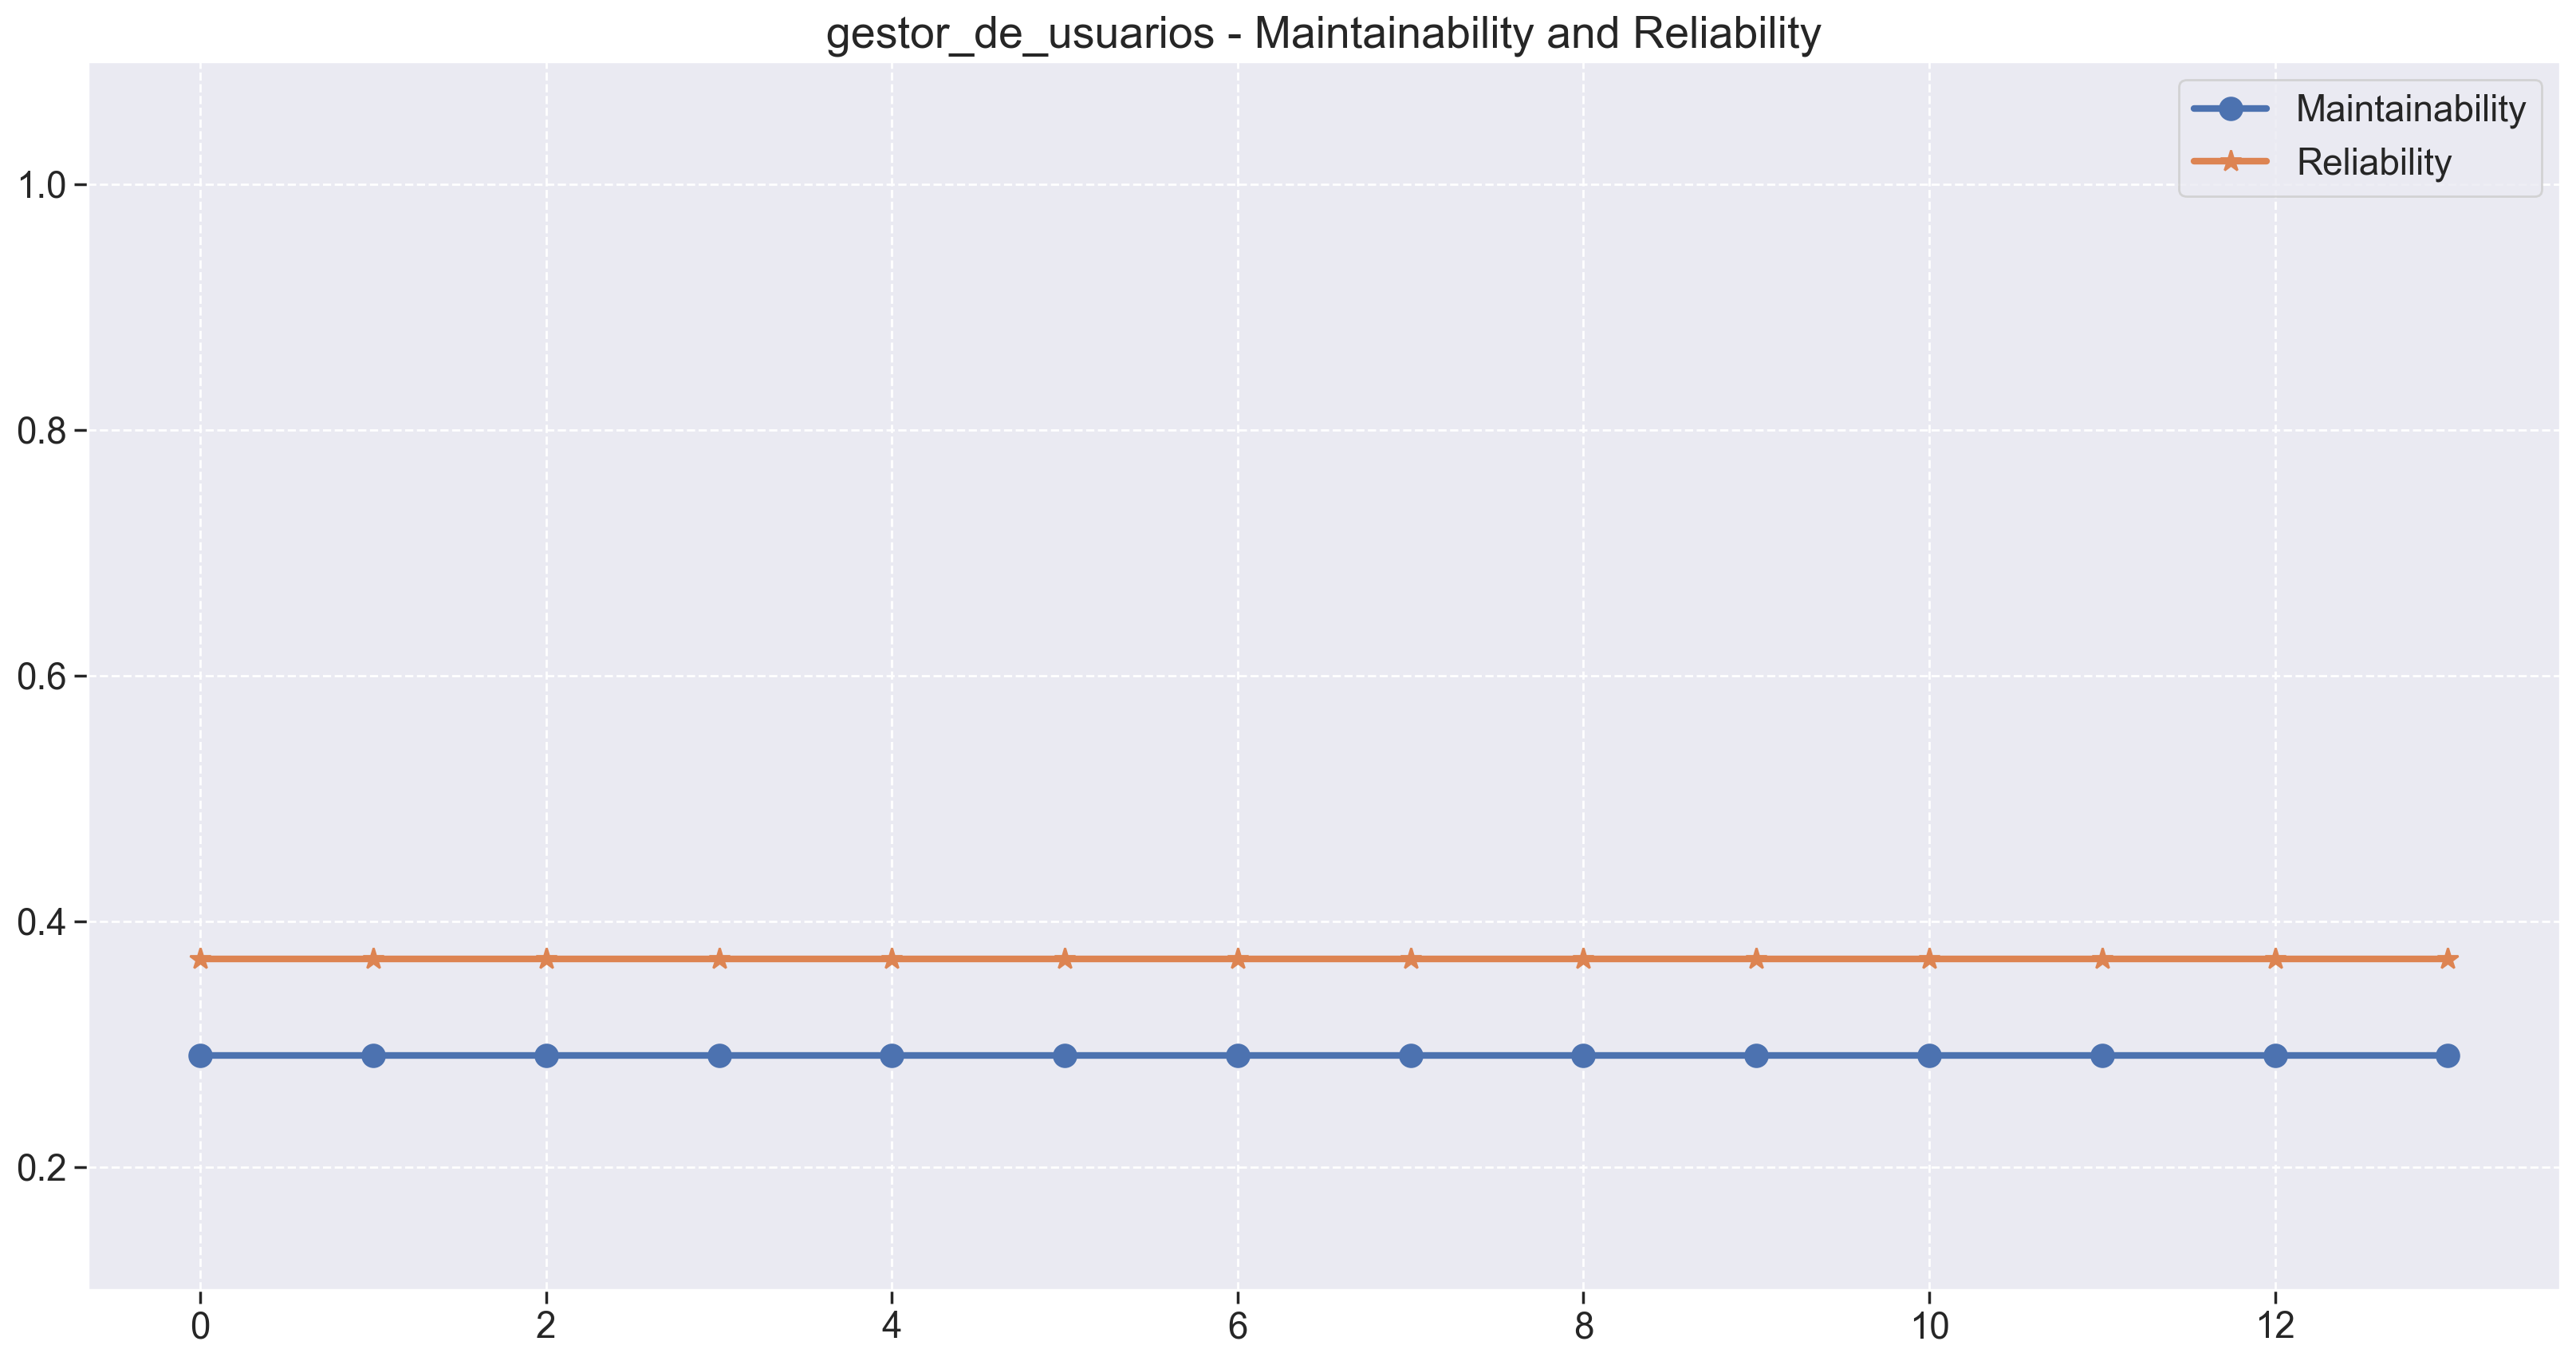

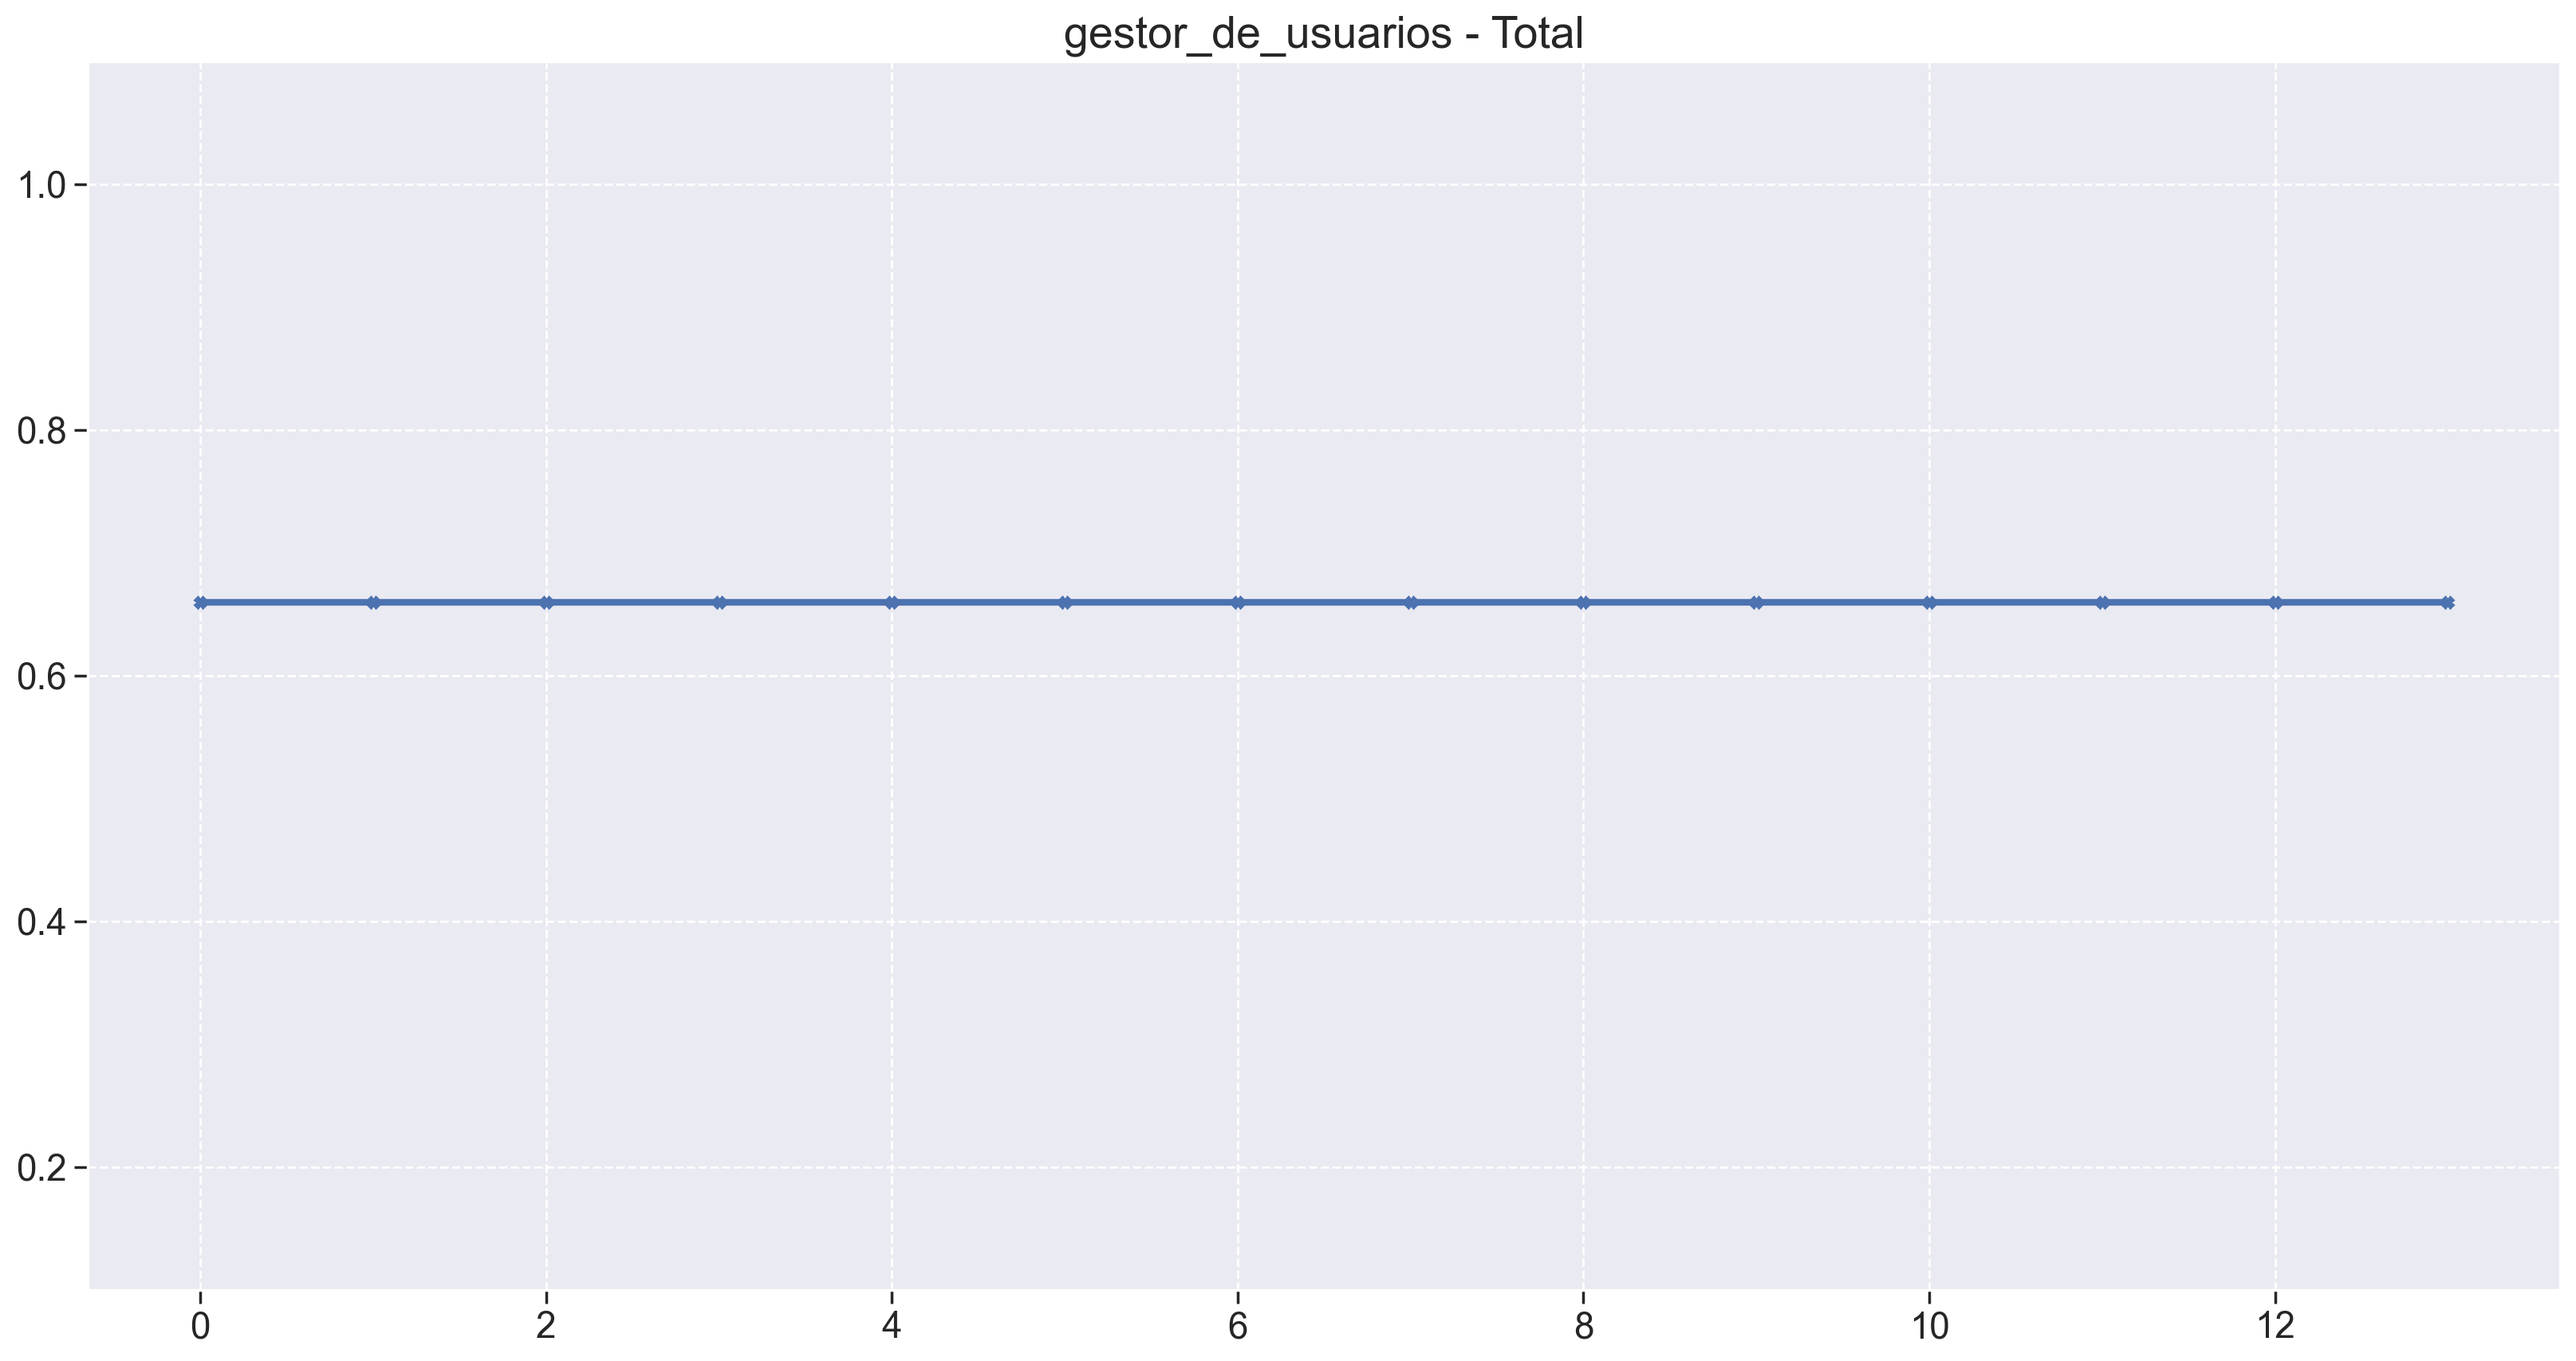

detalhador_de_chamados
Maintainability Stats
  mean   mode  median          std          var    min    max
0.2695 0.2695  0.2695 5.760664e-17 3.318525e-33 0.2695 0.2695
Reliability Stats
    mean     mode   median     std      var      min      max
0.436905 0.433333 0.433333 0.00428 0.000018 0.433333 0.441667


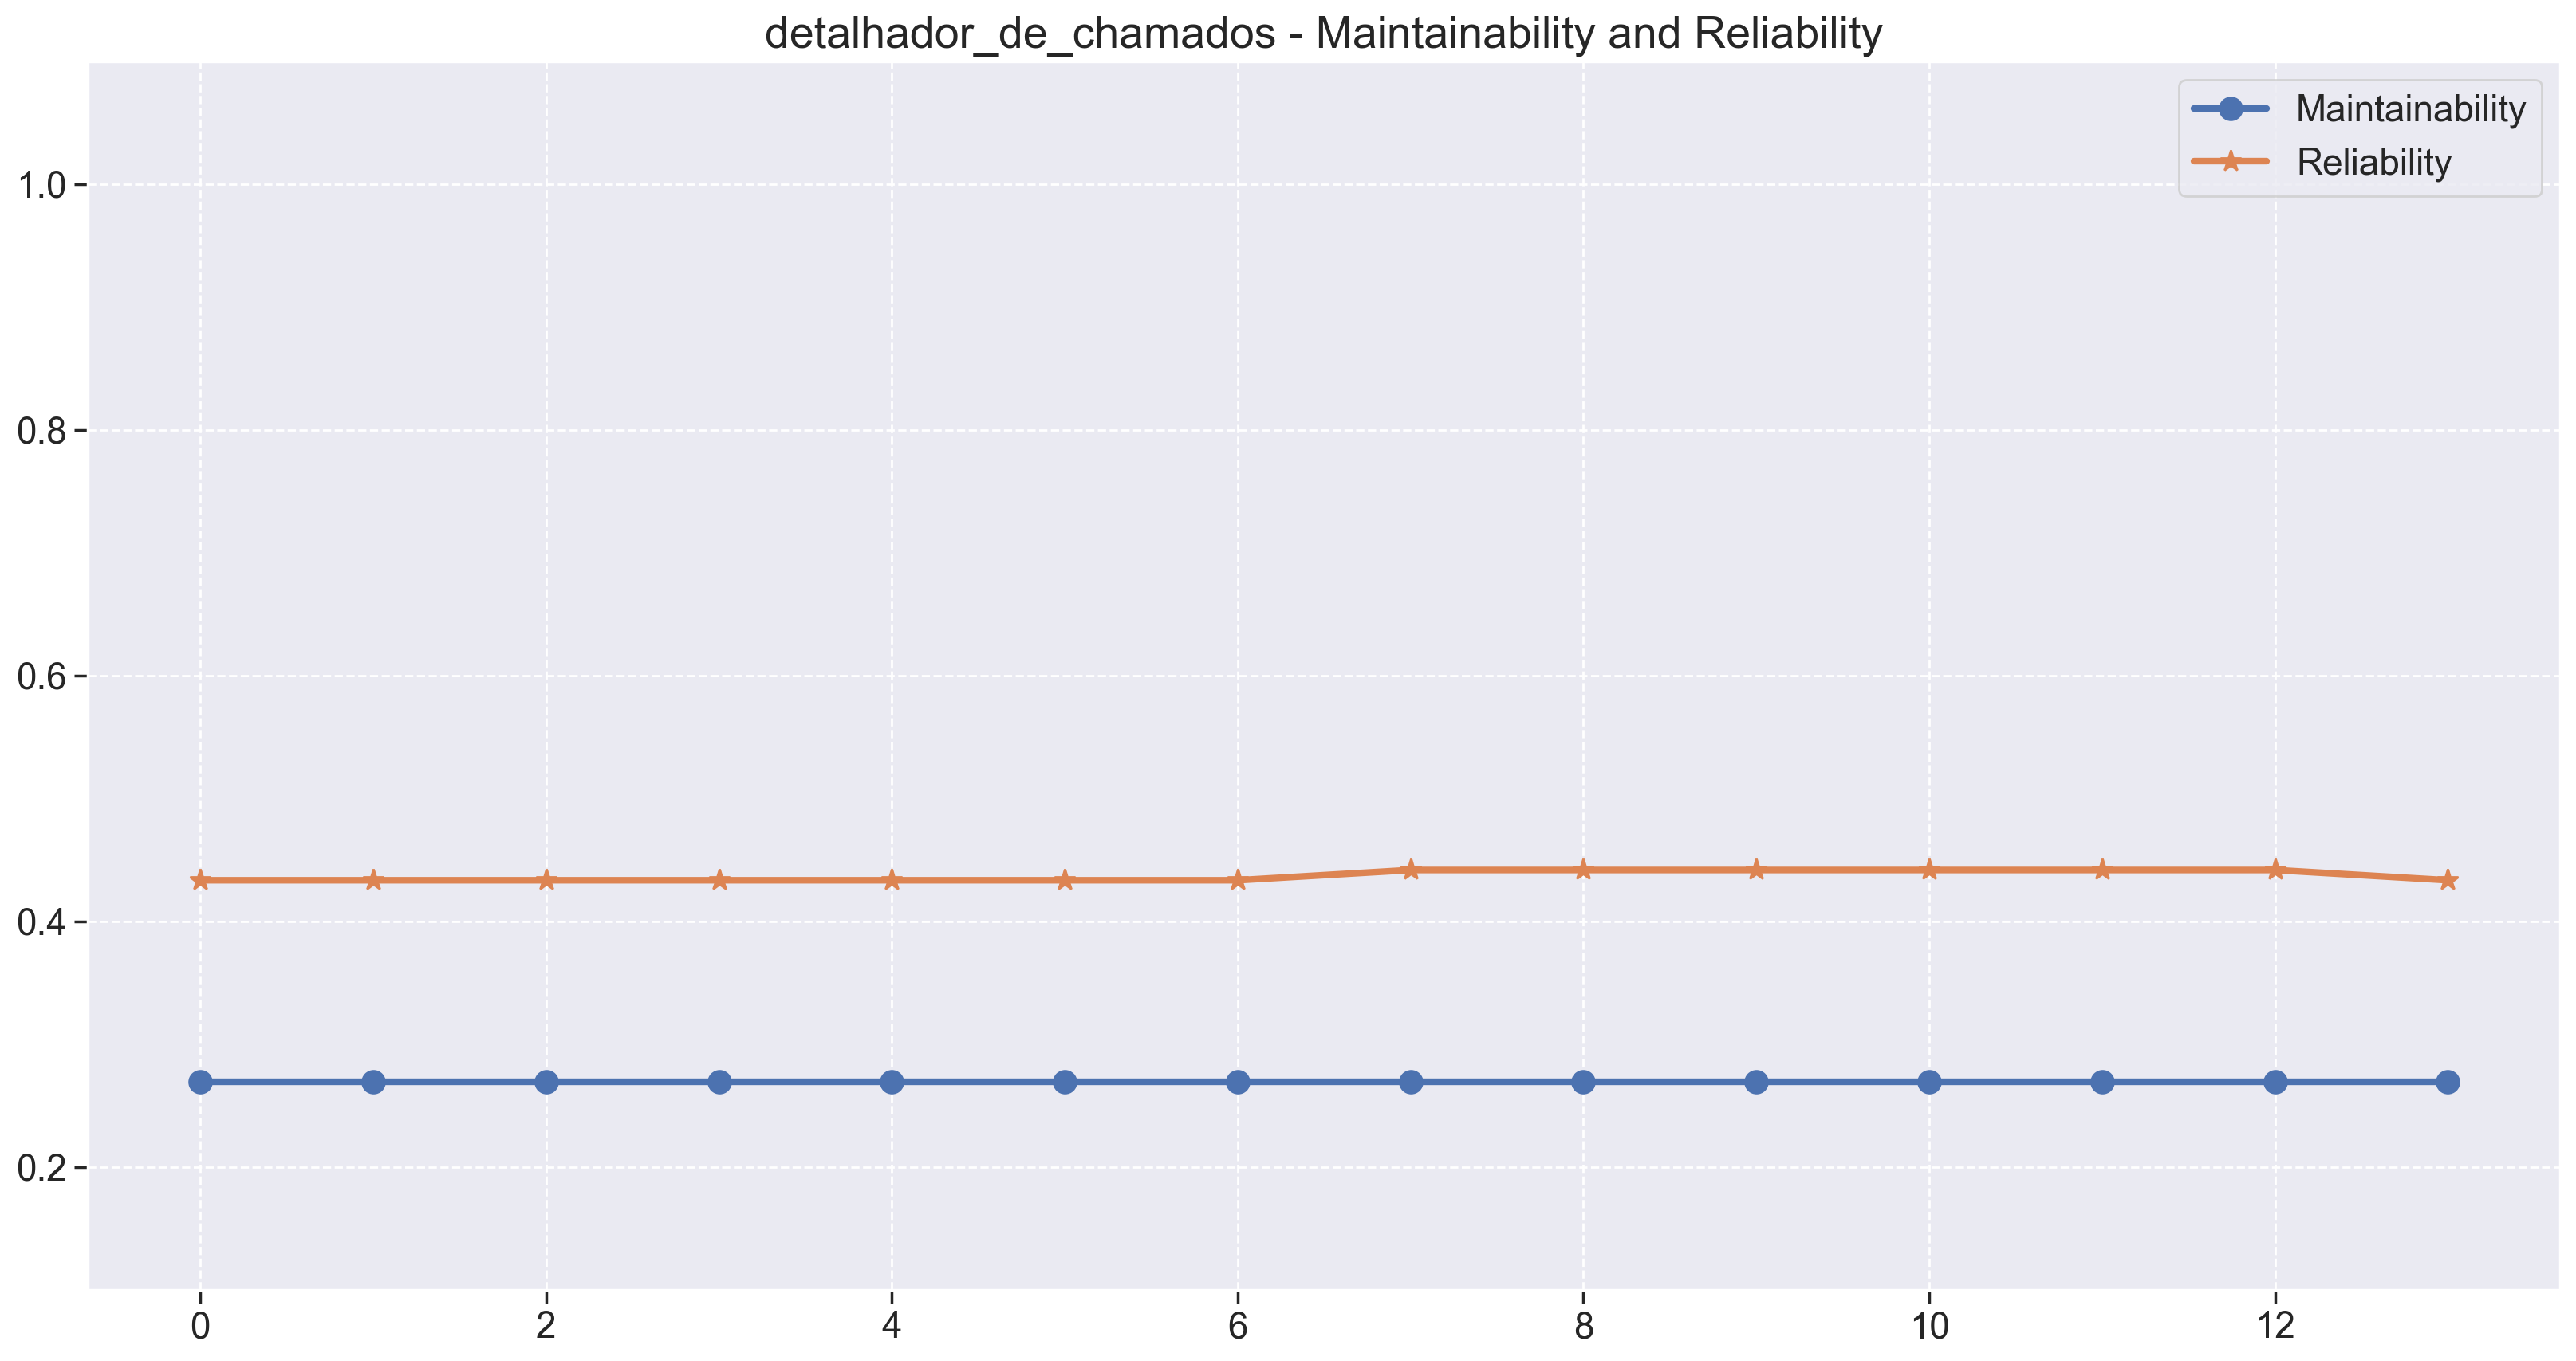

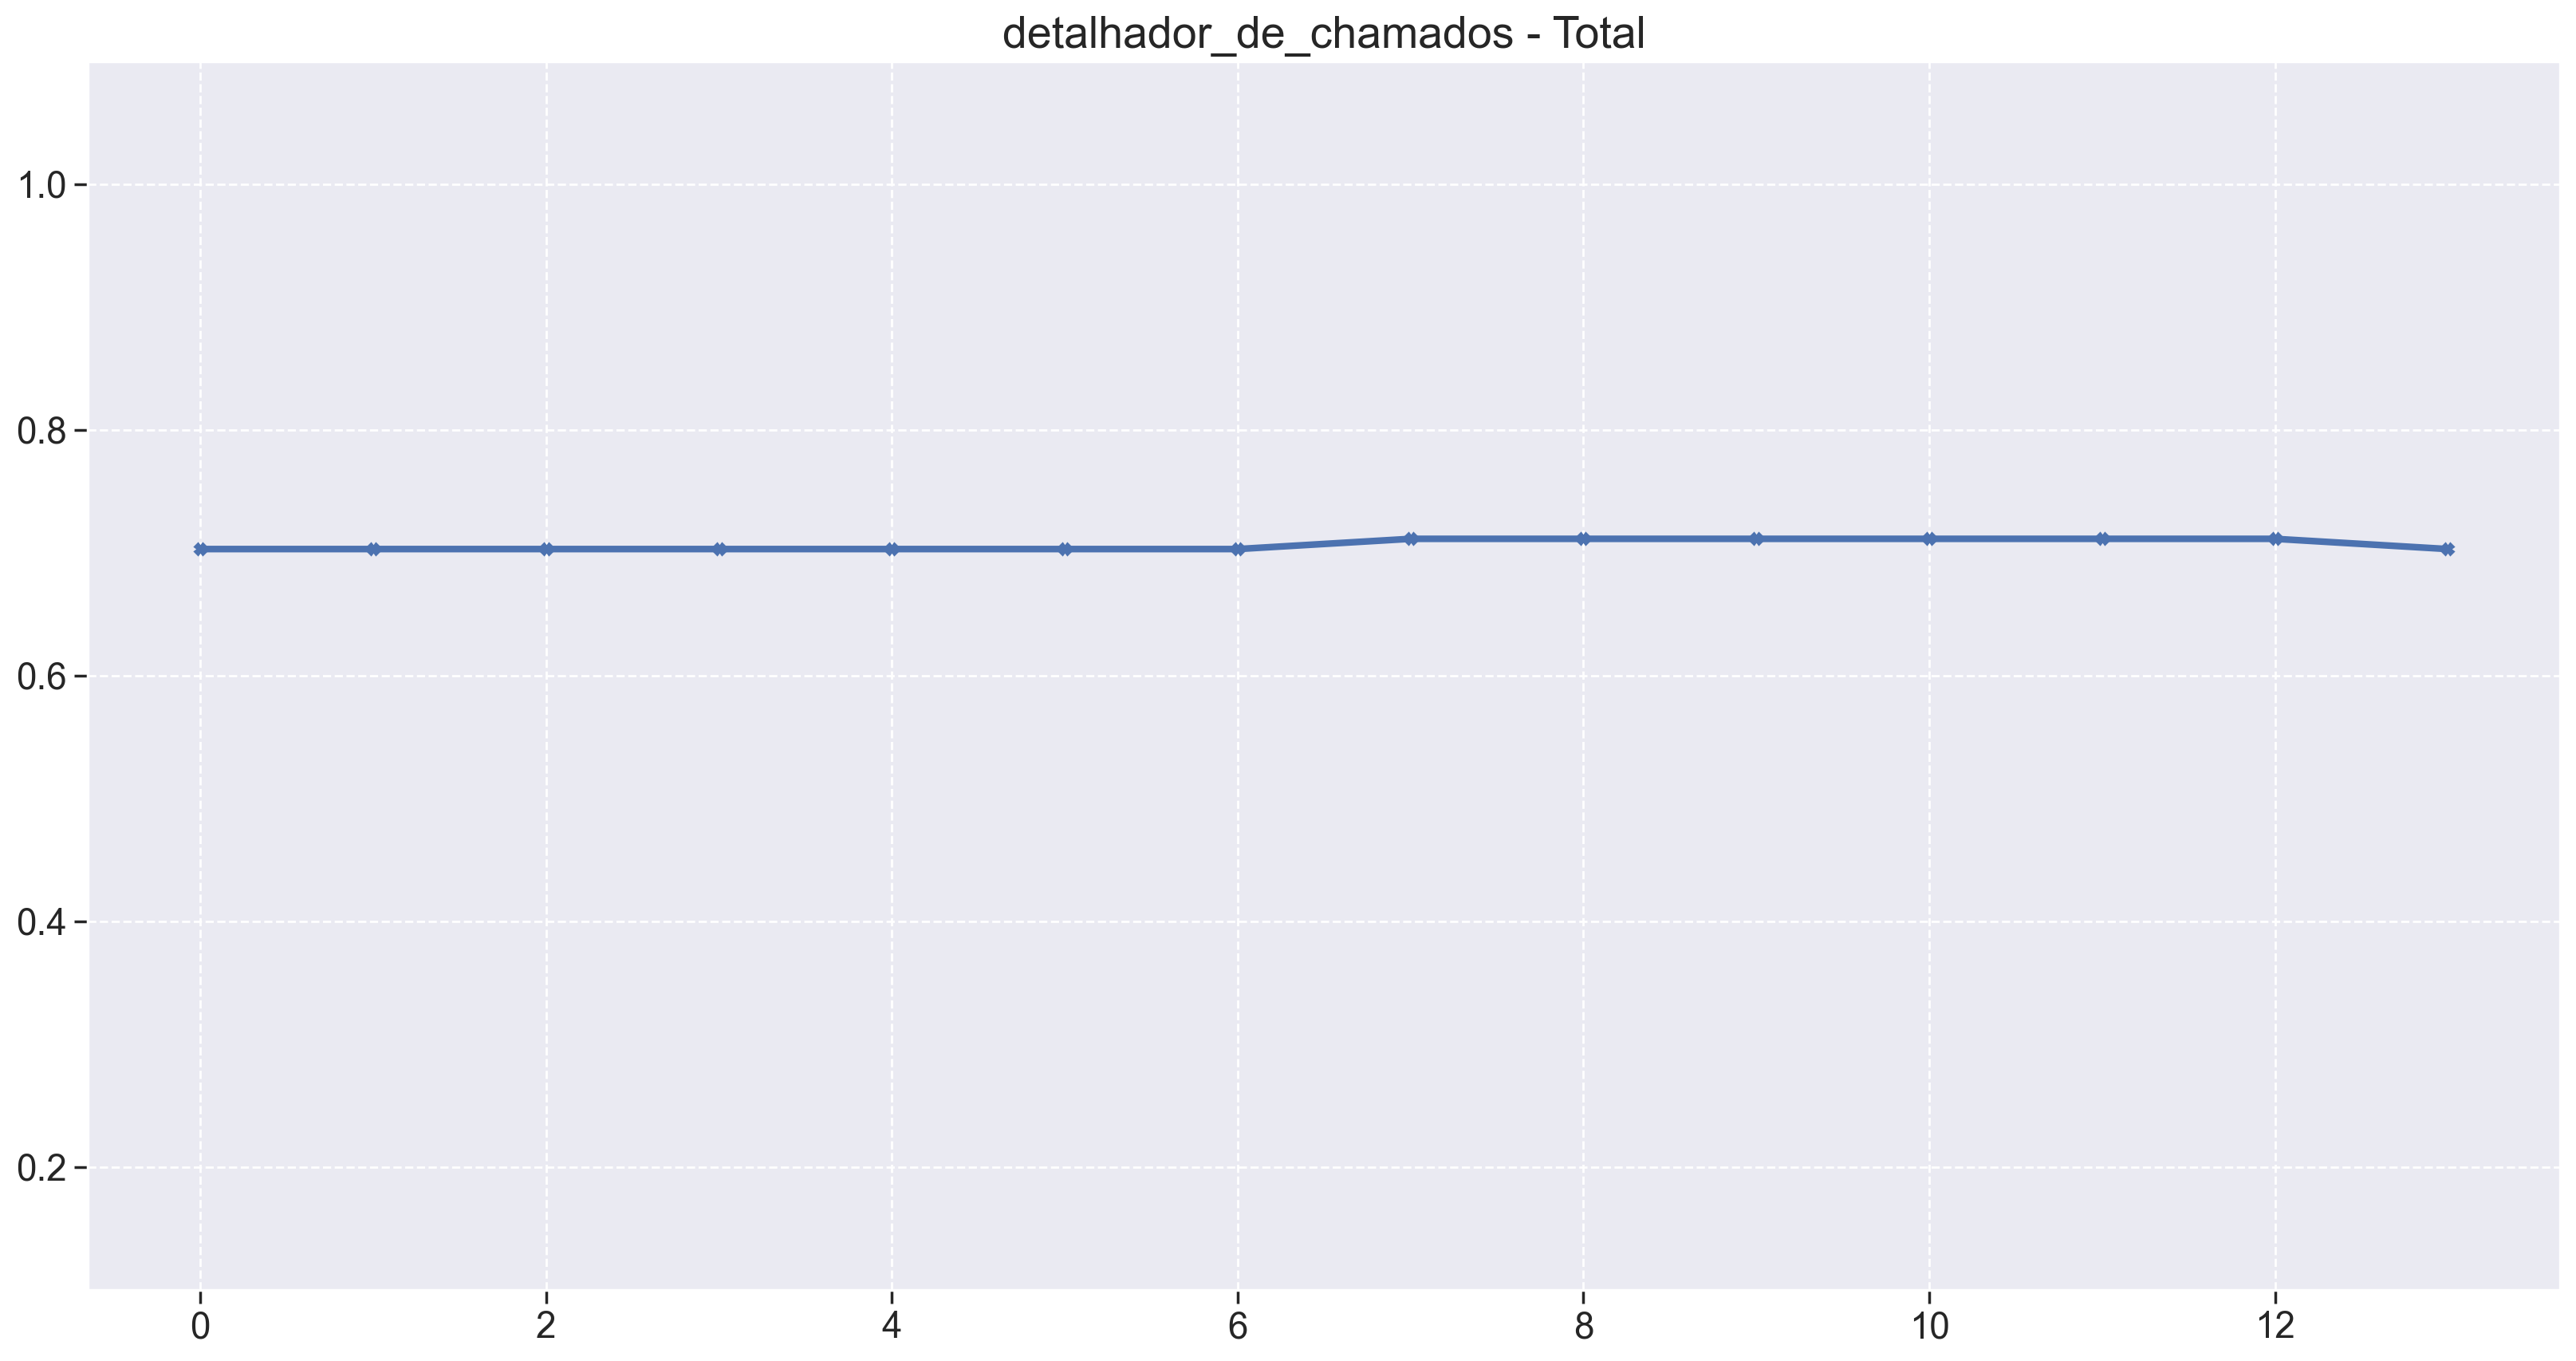

gerenciador_de_localidades
Maintainability Stats
    mean     mode   median  std  var      min      max
0.257812 0.257812 0.257812  0.0  0.0 0.257812 0.257812
Reliability Stats
  mean   mode  median  std  var    min    max
0.4375 0.4375  0.4375  0.0  0.0 0.4375 0.4375


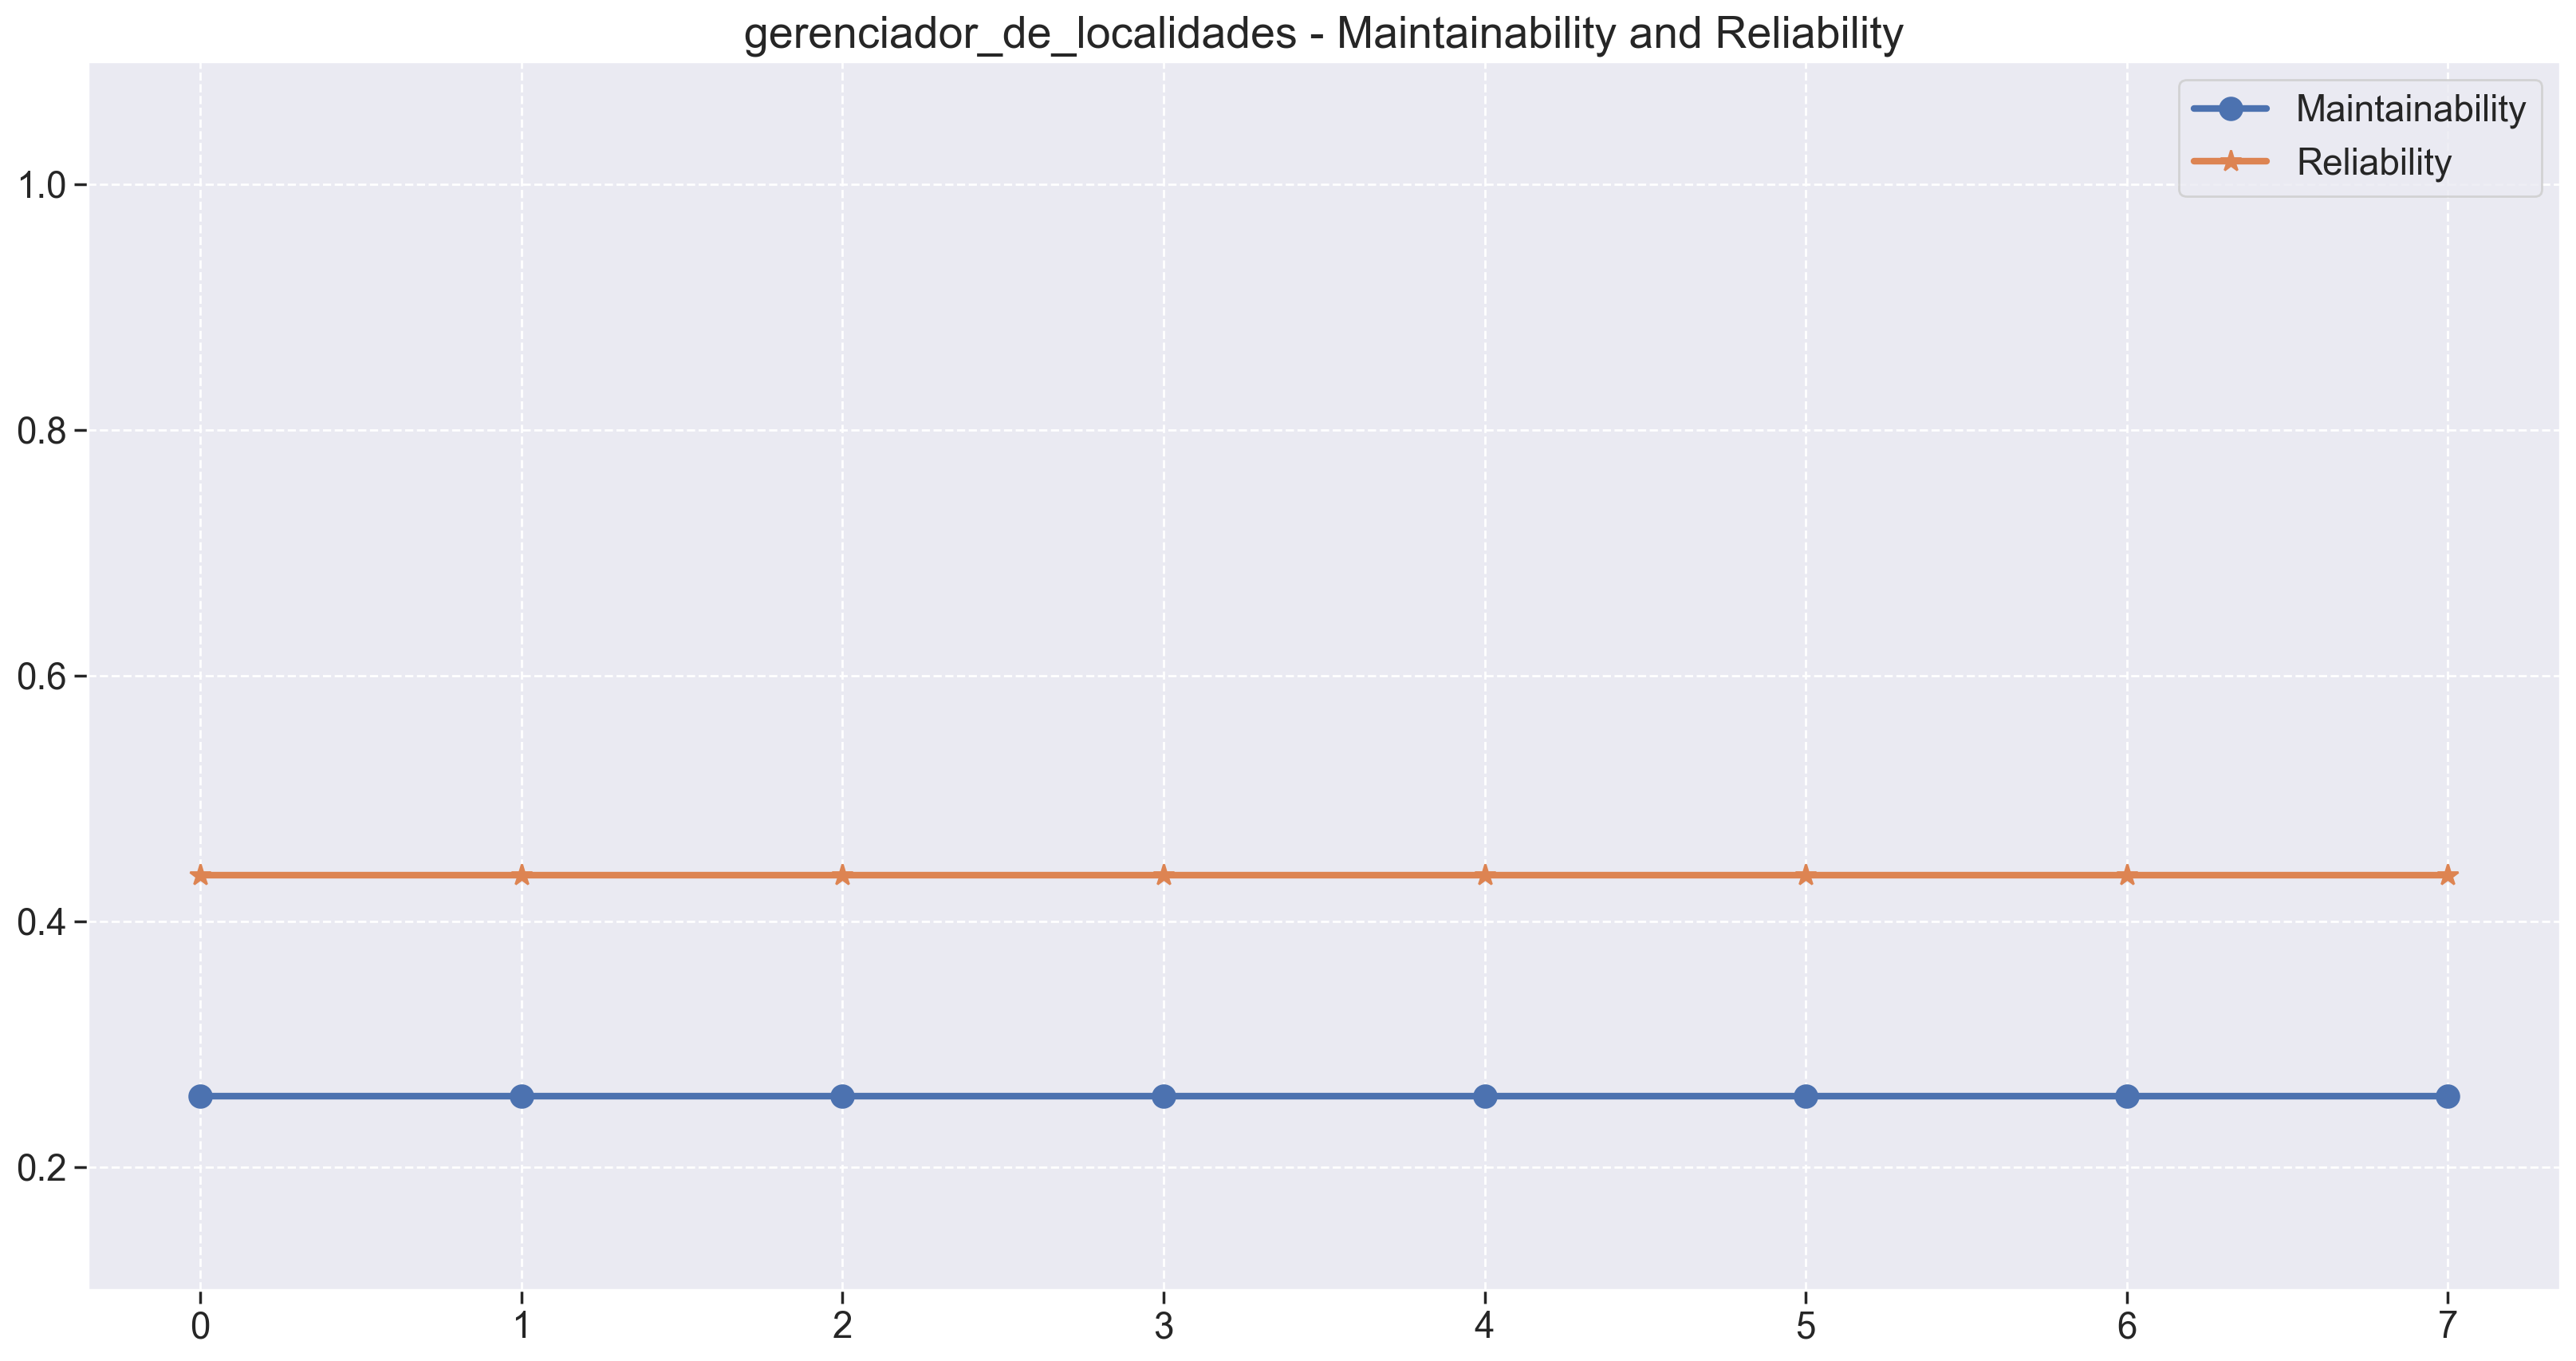

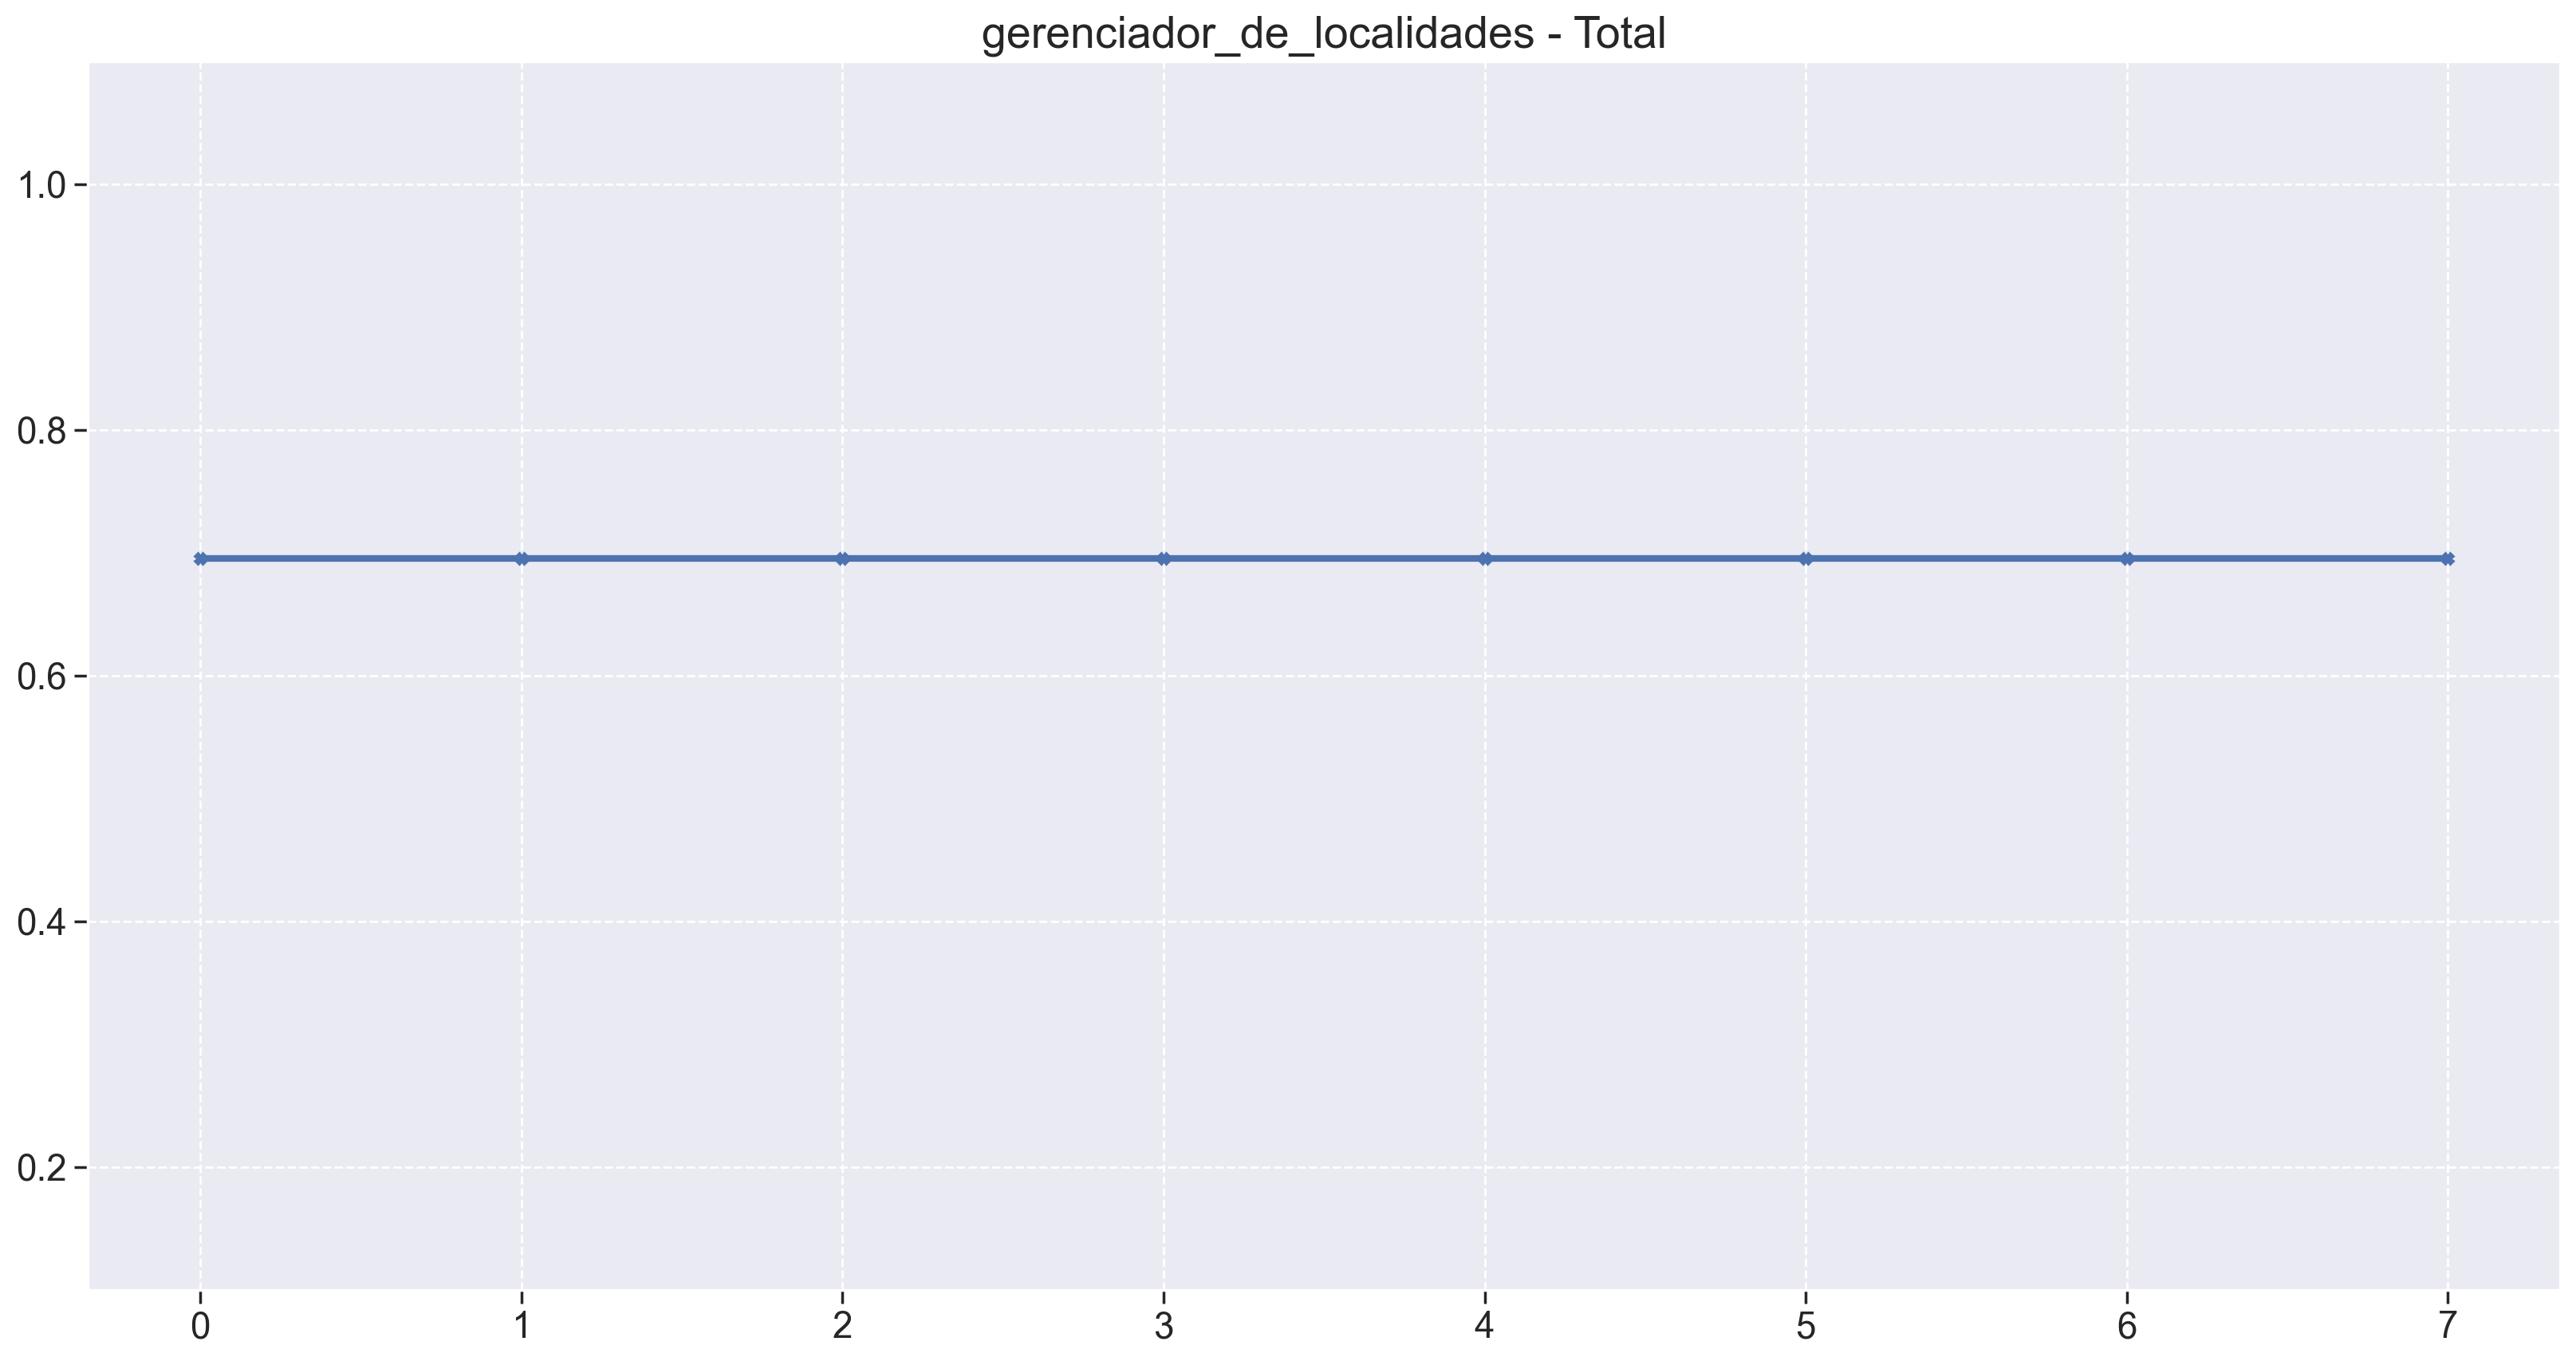

gerenciador_de_tutoriais
Maintainability Stats
    mean     mode   median      std      var    min      max
0.253688 0.257812 0.257812 0.005325 0.000028 0.2475 0.257812
Reliability Stats
  mean   mode  median      std      var  min    max
0.4225 0.4375  0.4375 0.019365 0.000375  0.4 0.4375


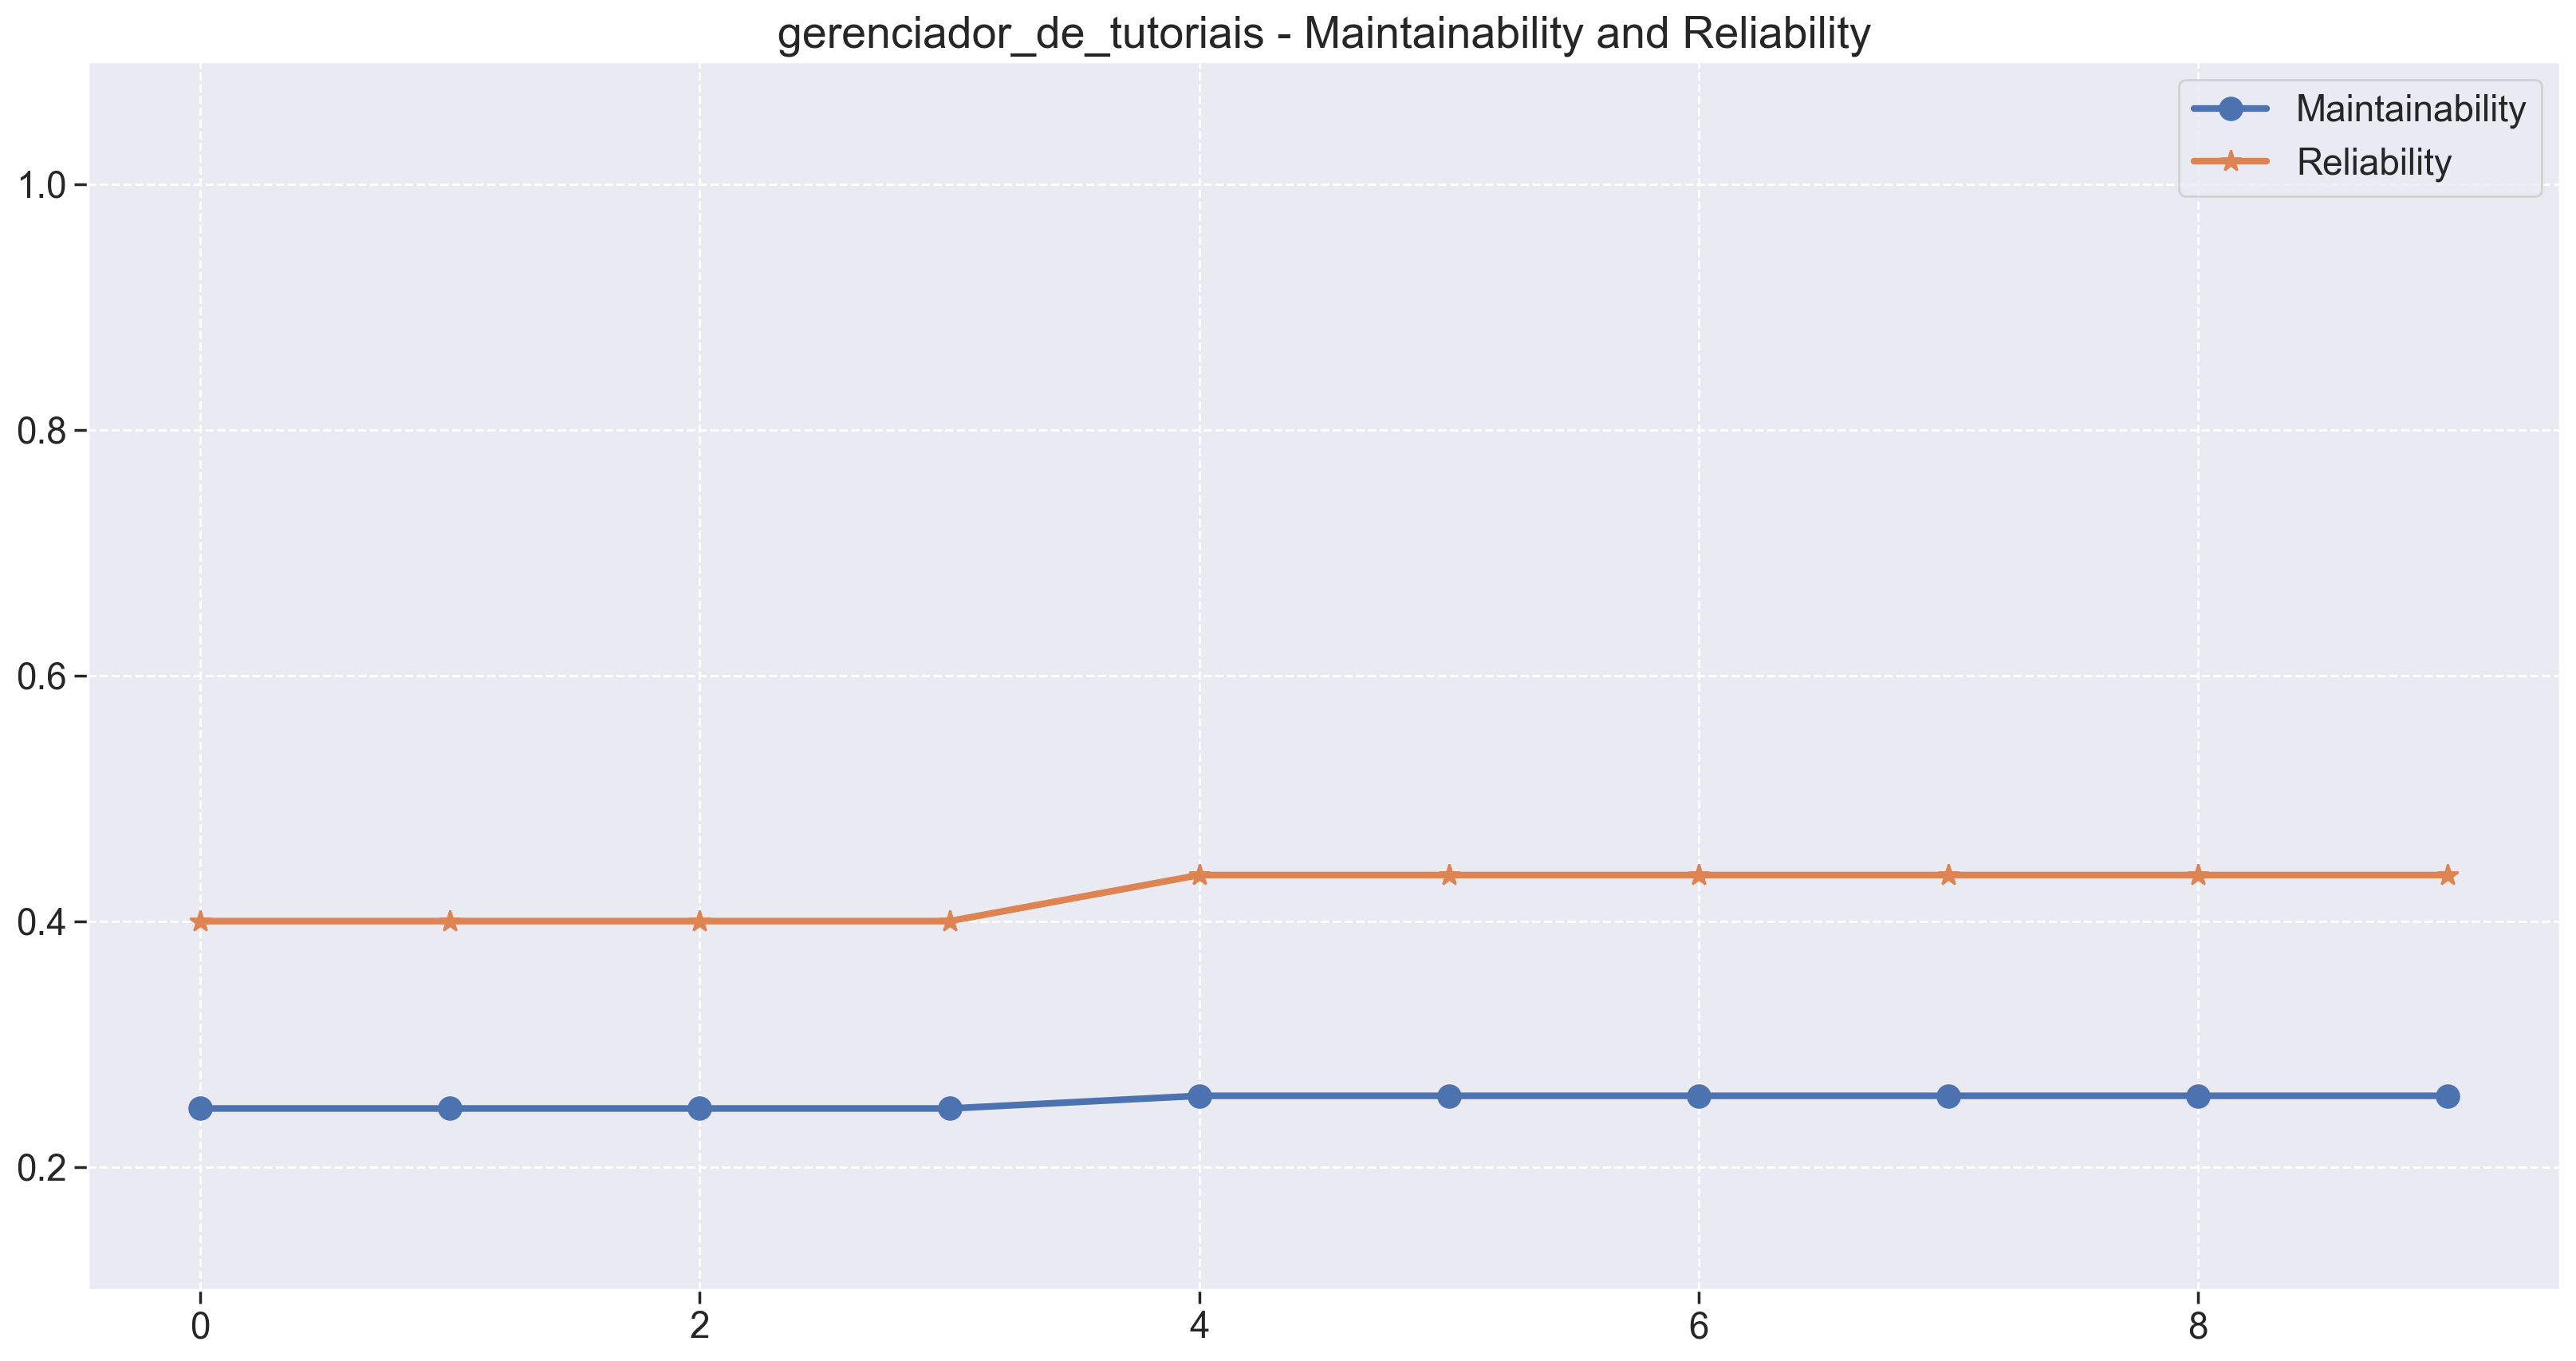

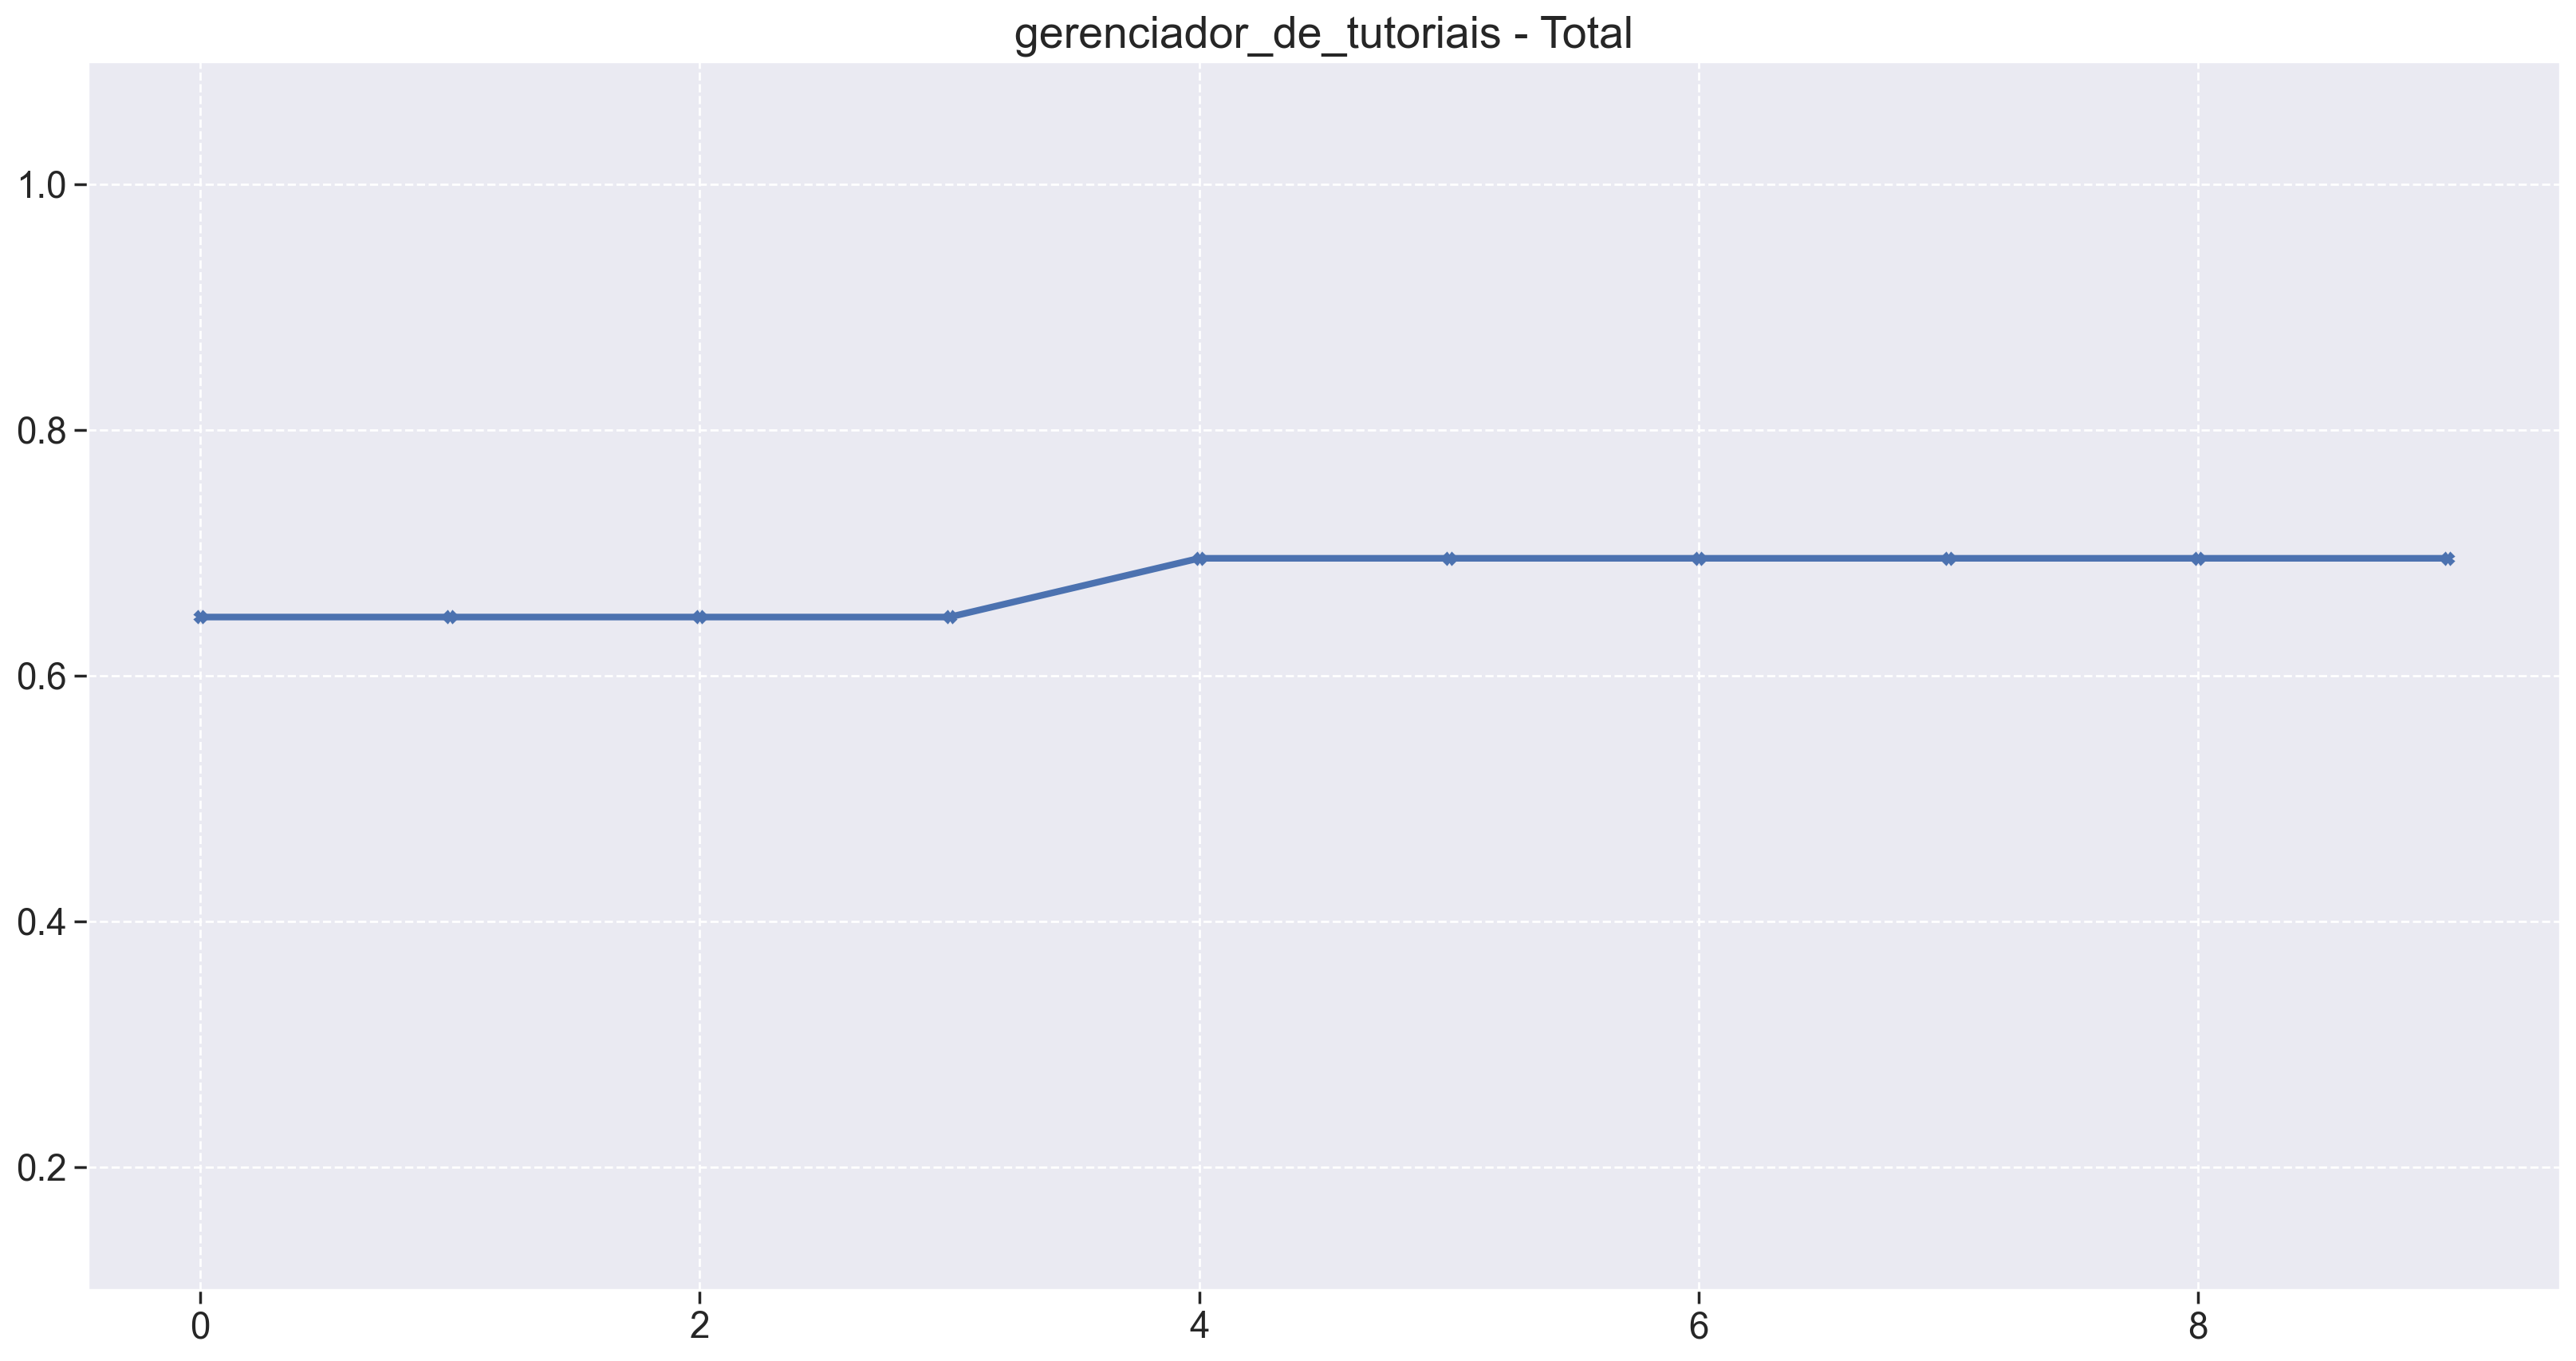

gestor_de_alerta
Maintainability Stats
 mean   mode  median      std      var  min    max
0.165 0.2475  0.2475 0.127808 0.016335  0.0 0.2475
Reliability Stats
    mean  mode  median      std      var  min  max
0.266667   0.4     0.4 0.206559 0.042667  0.0  0.4


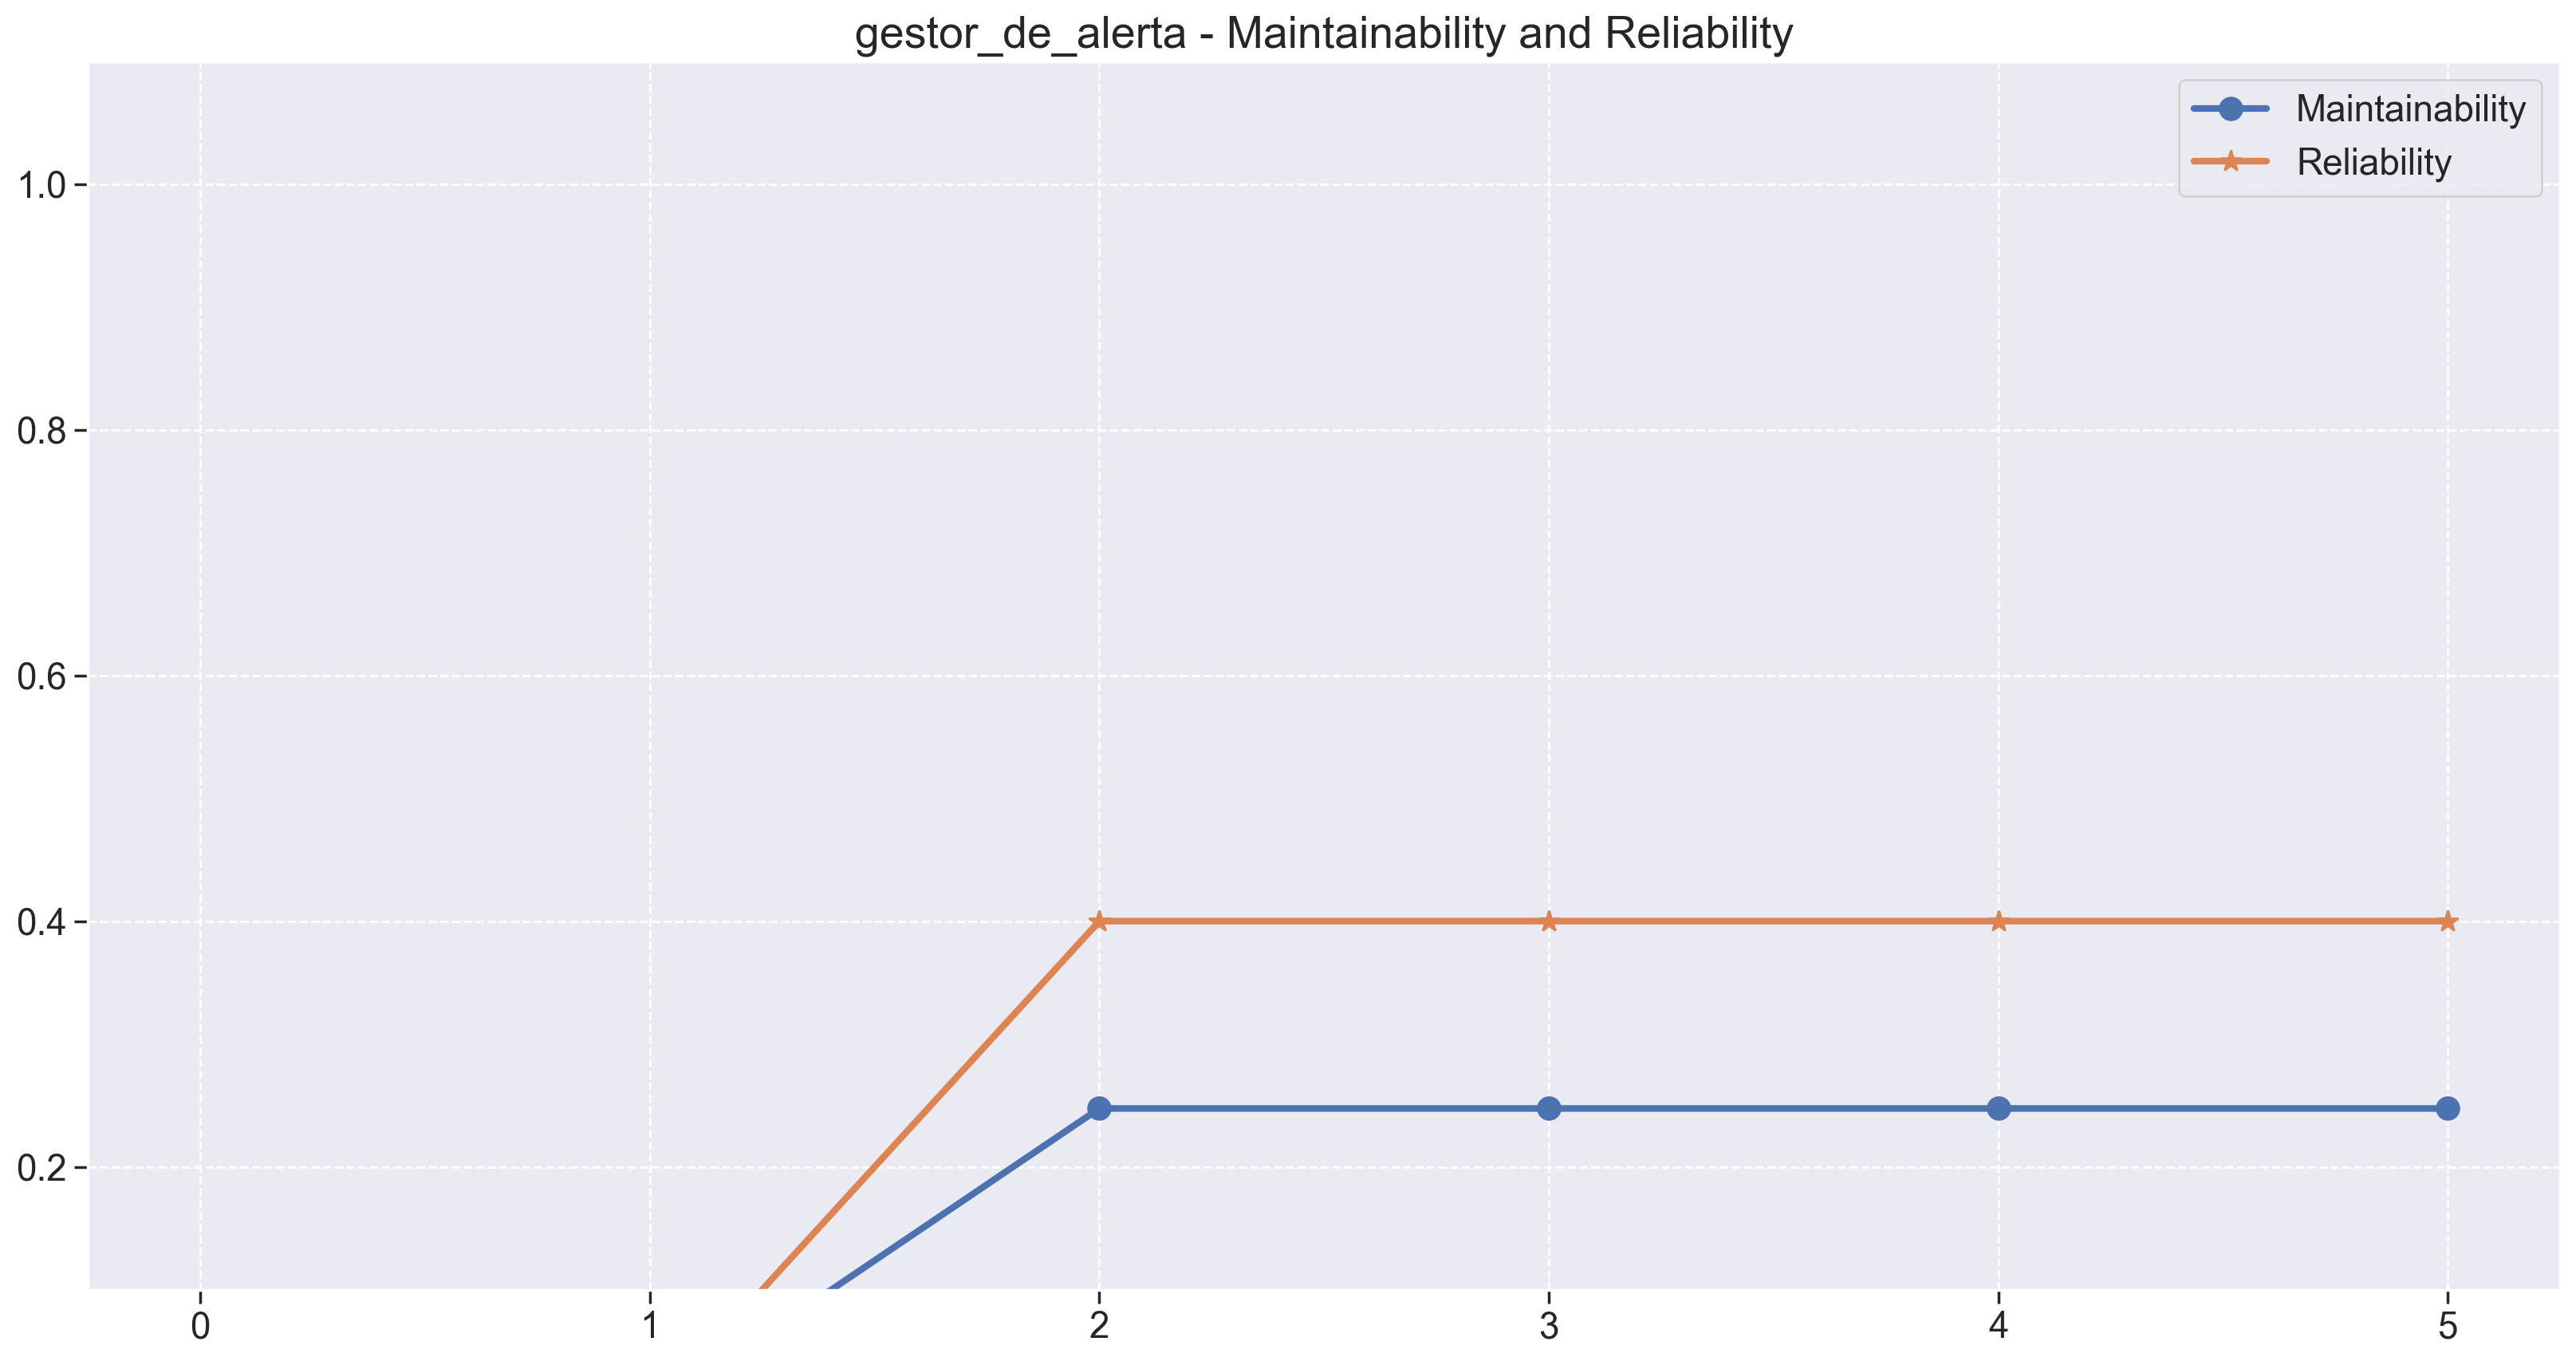

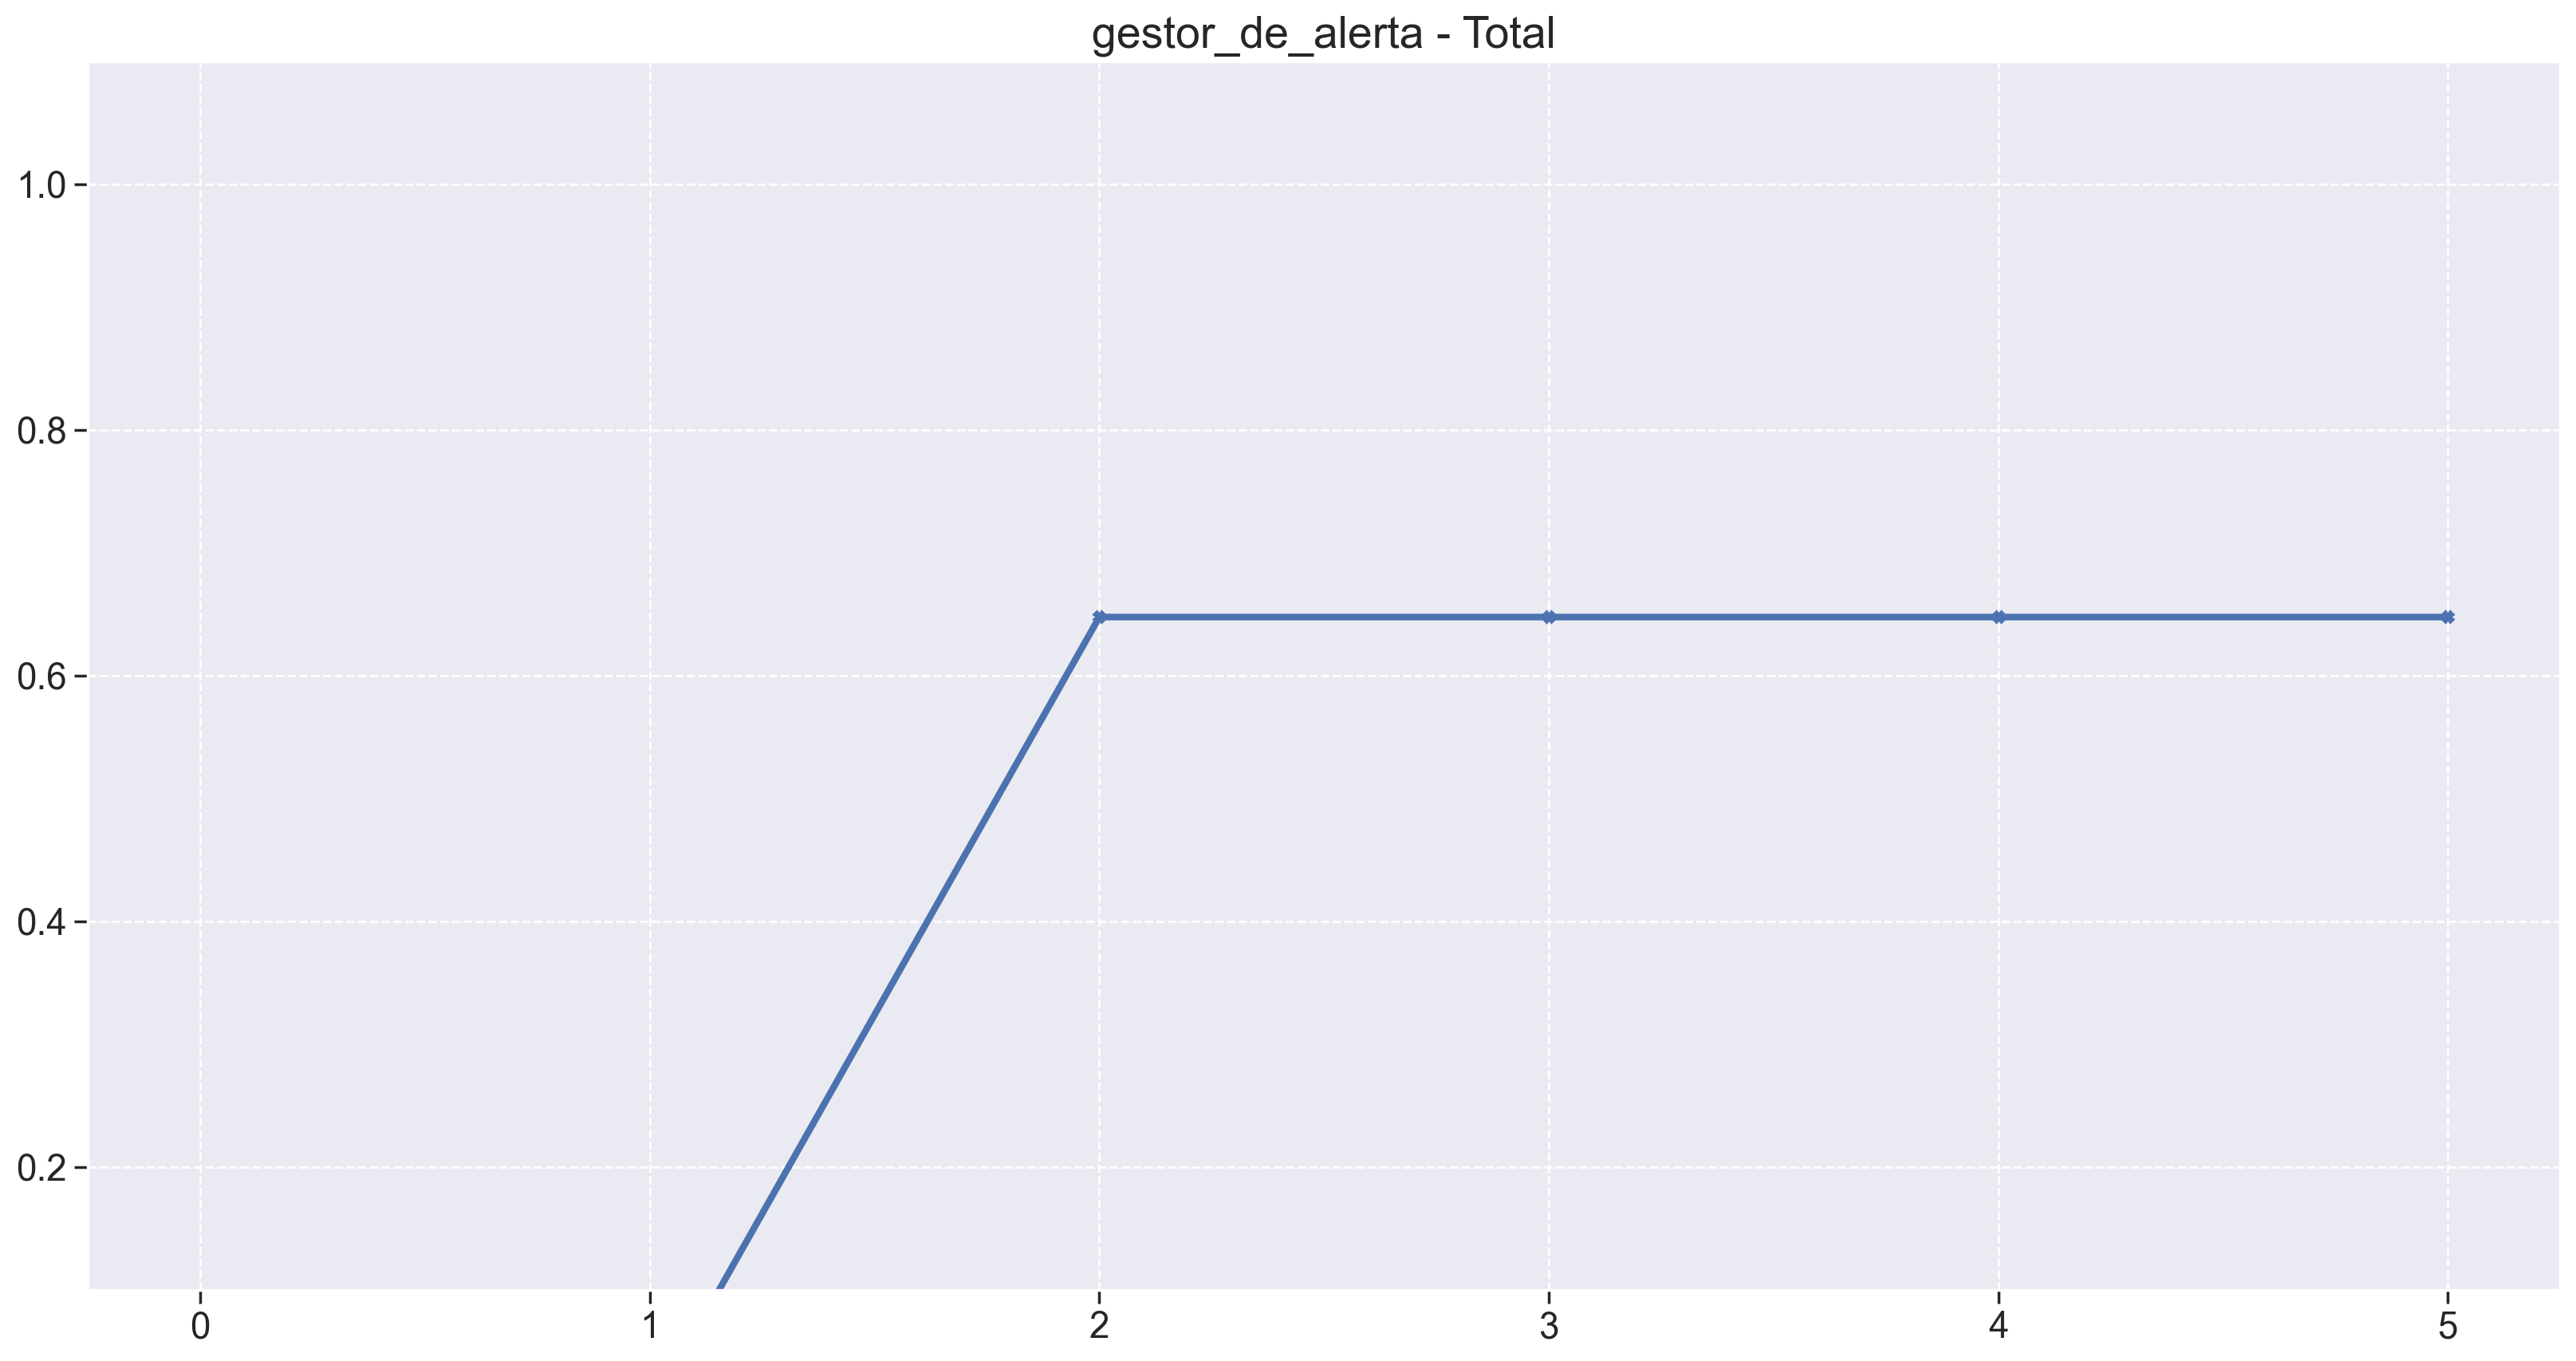

In [83]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

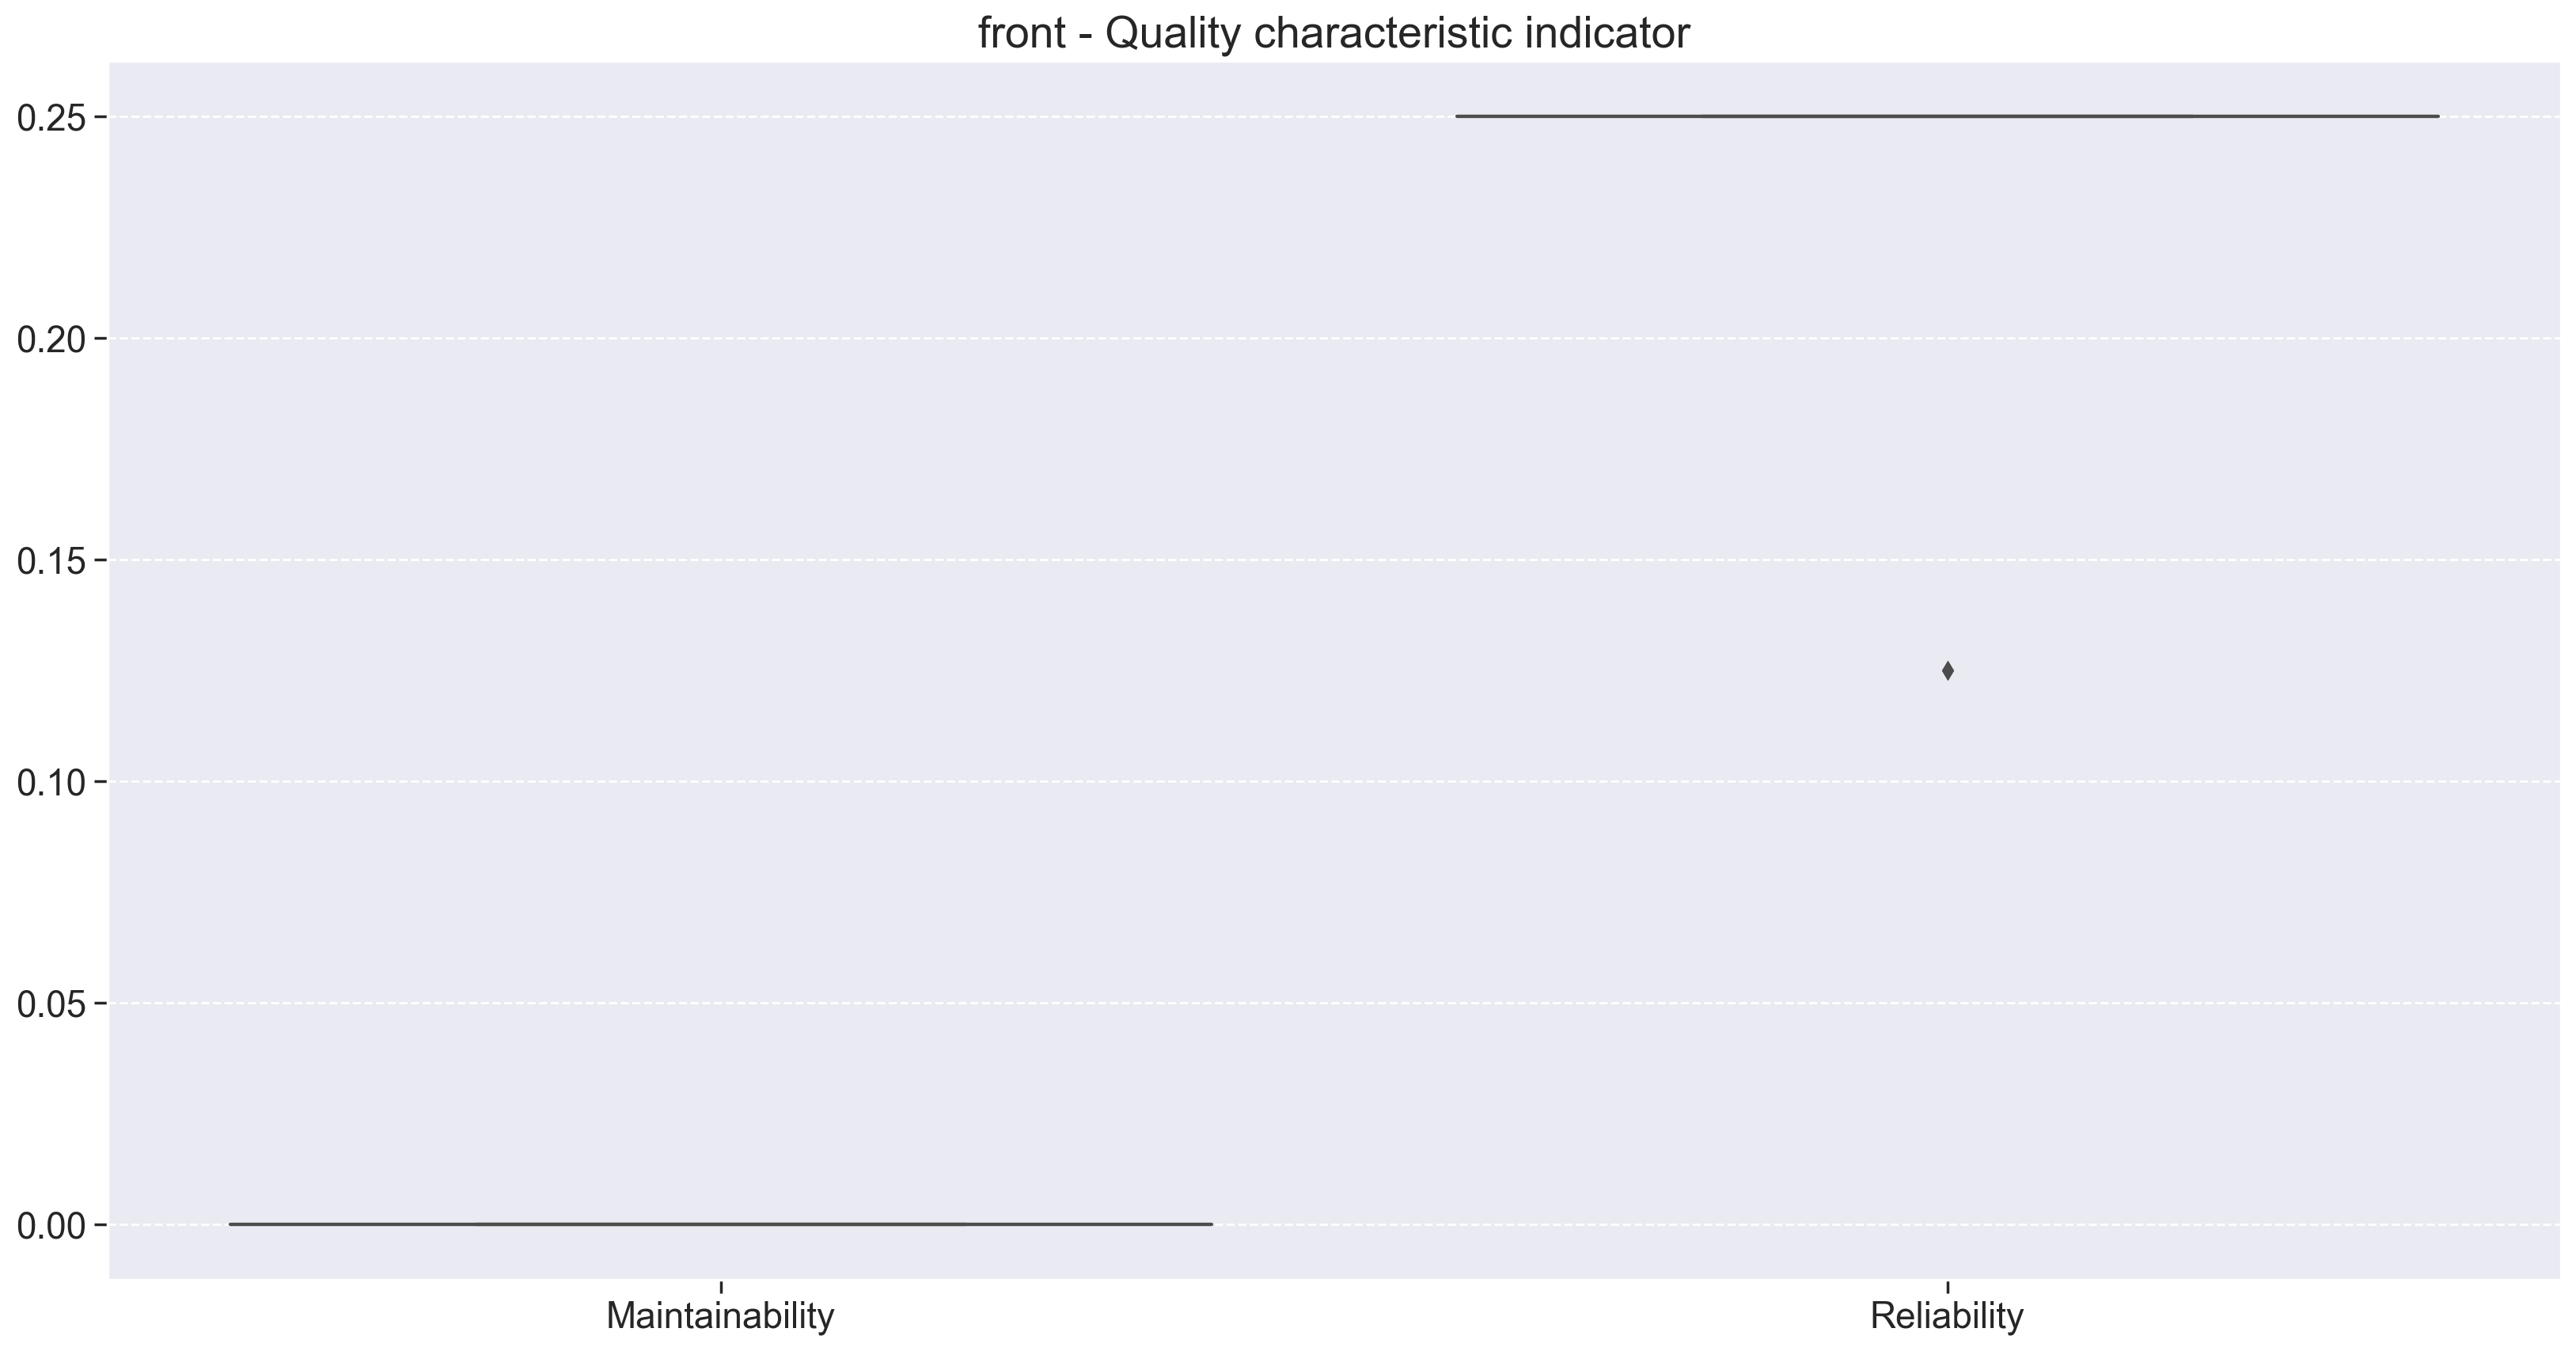

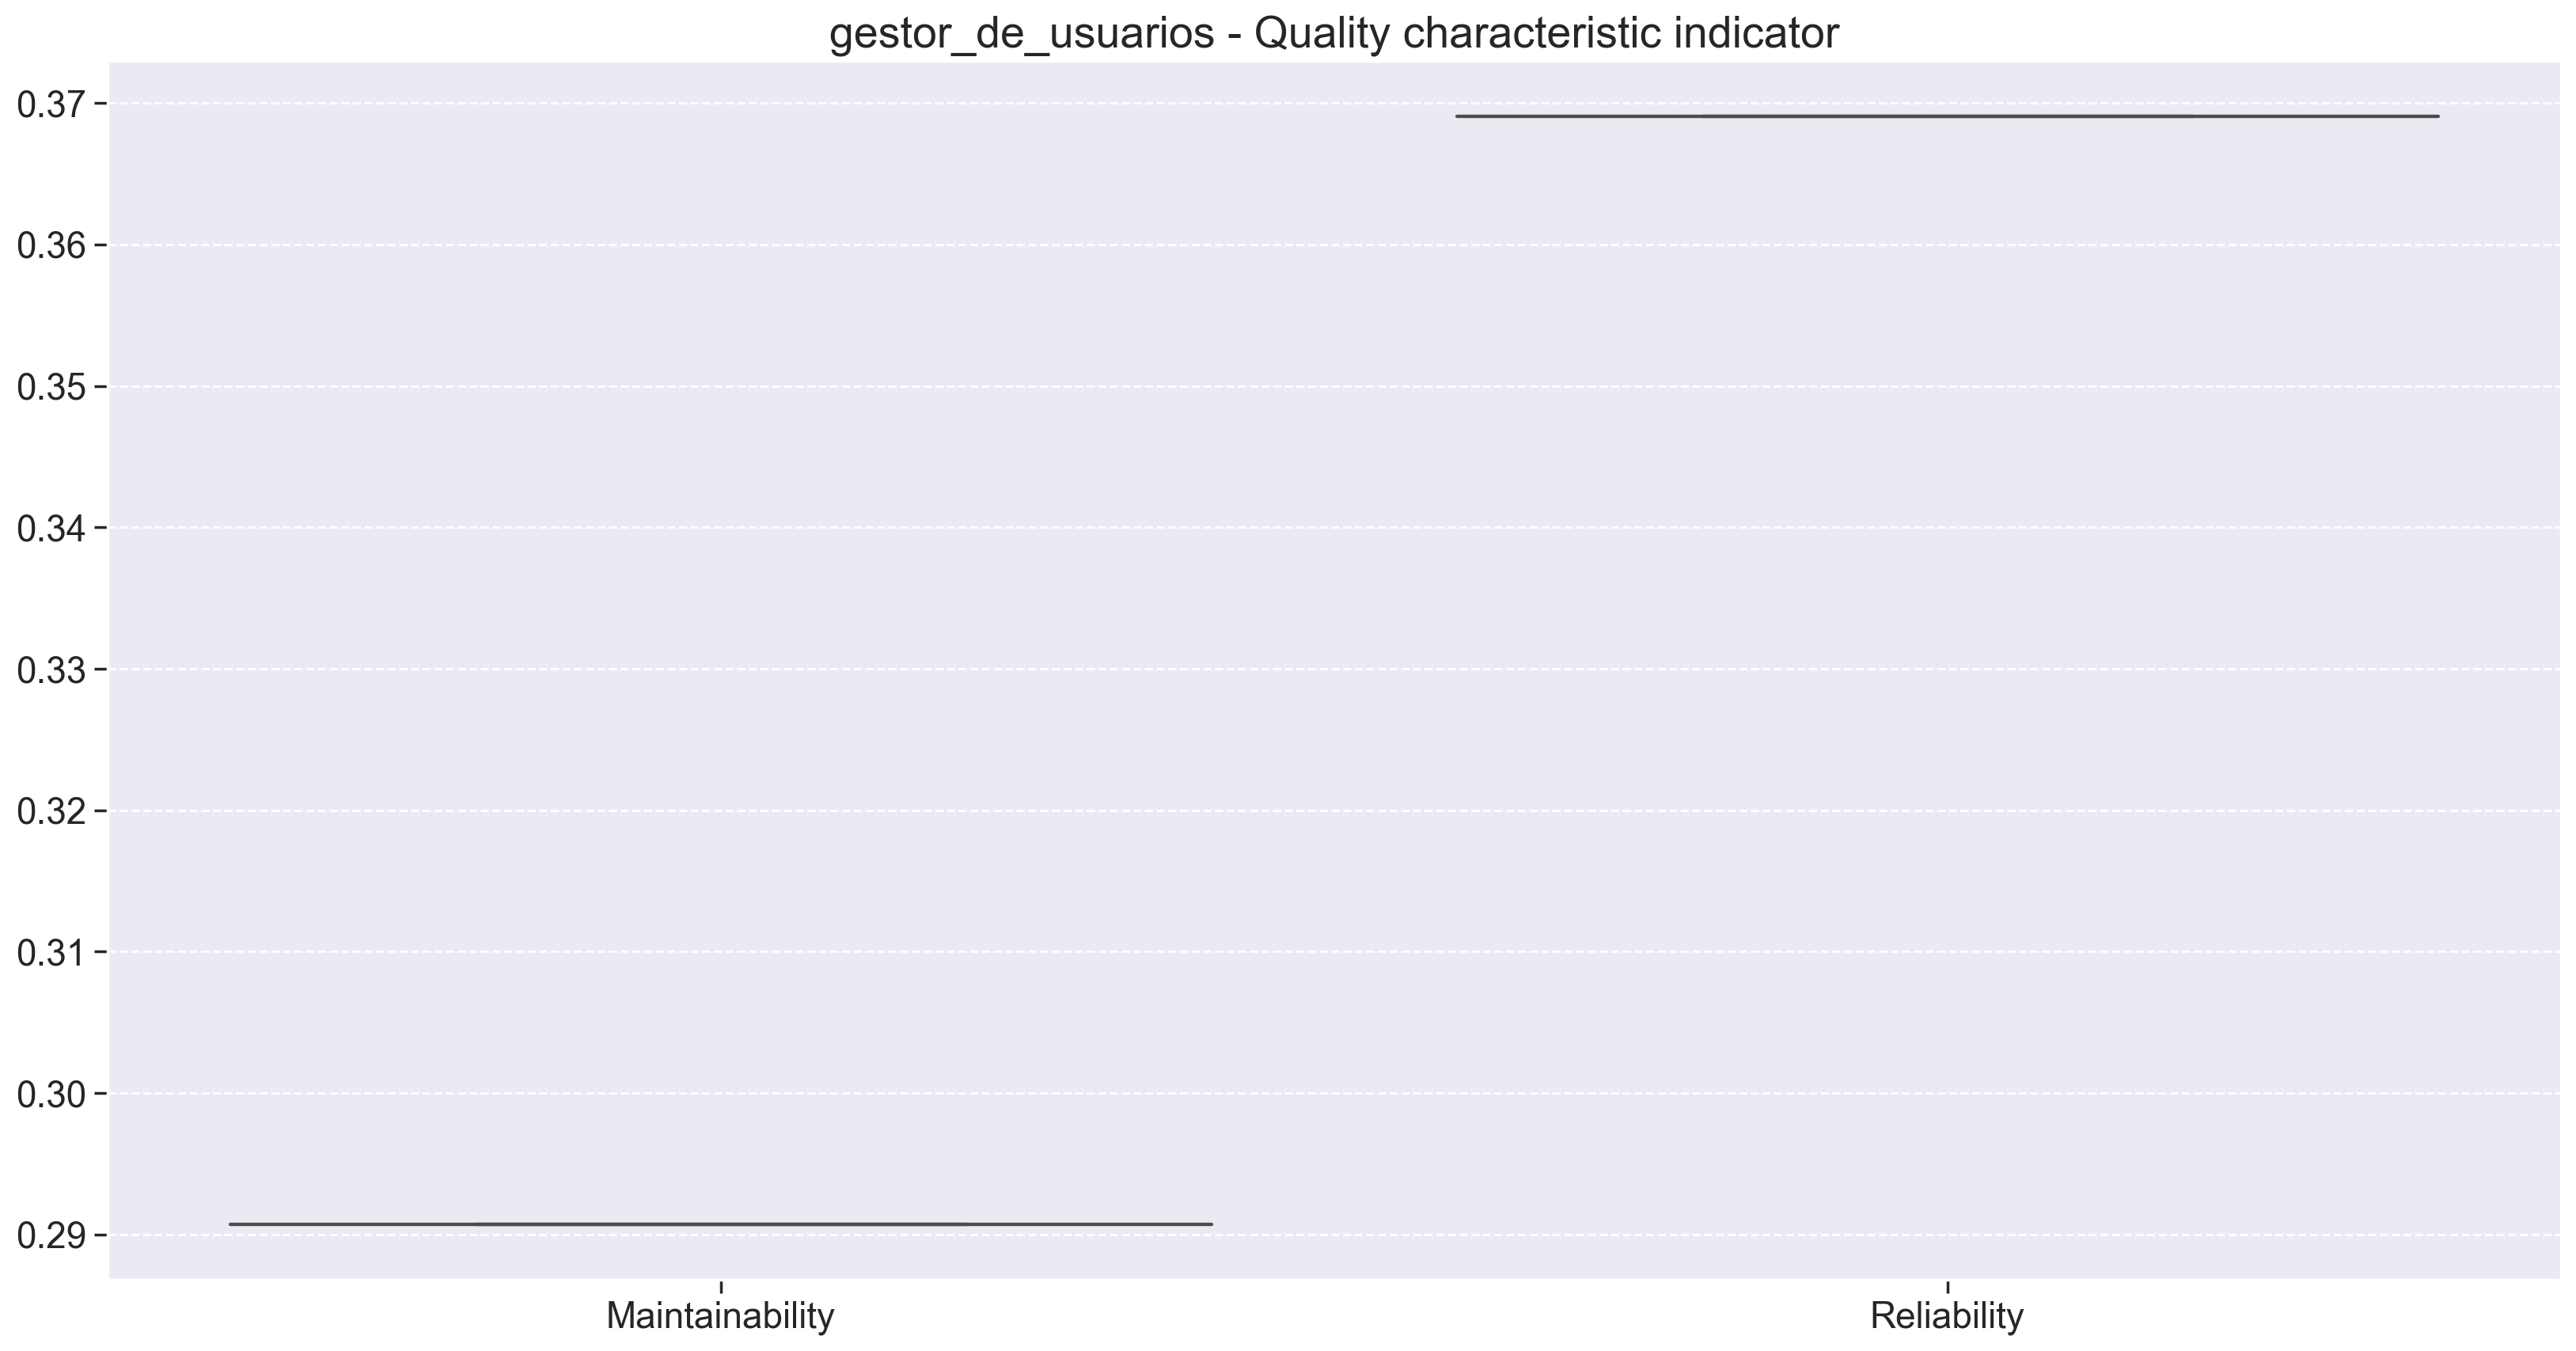

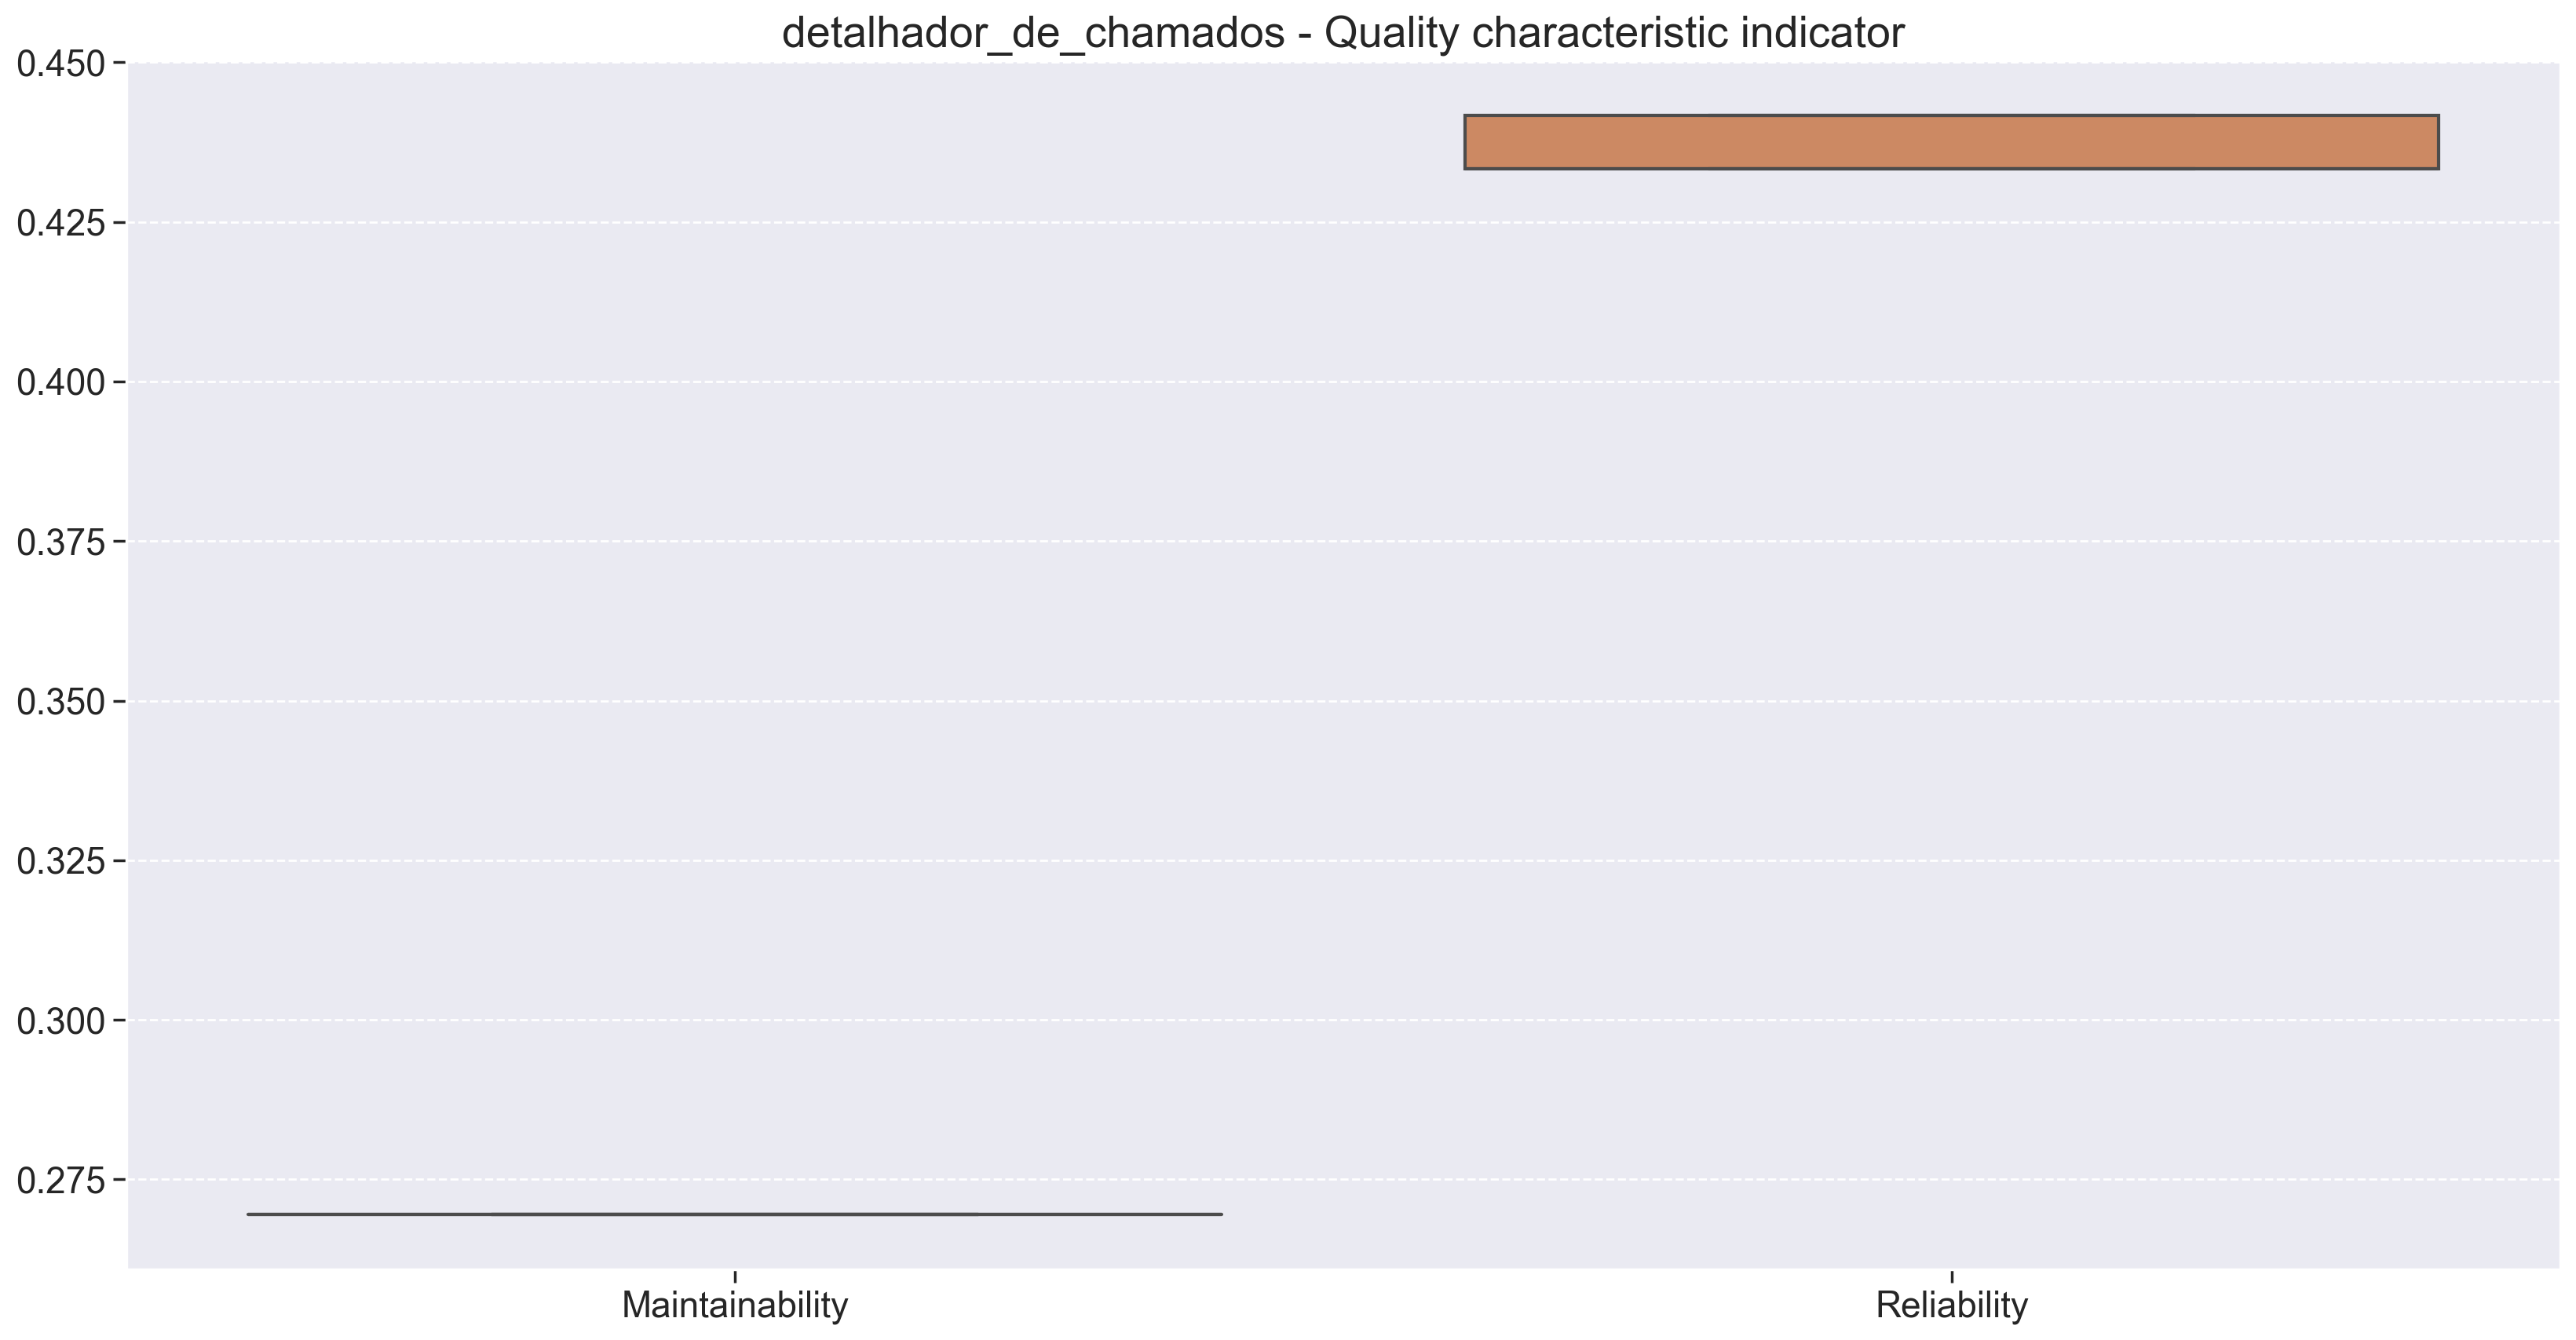

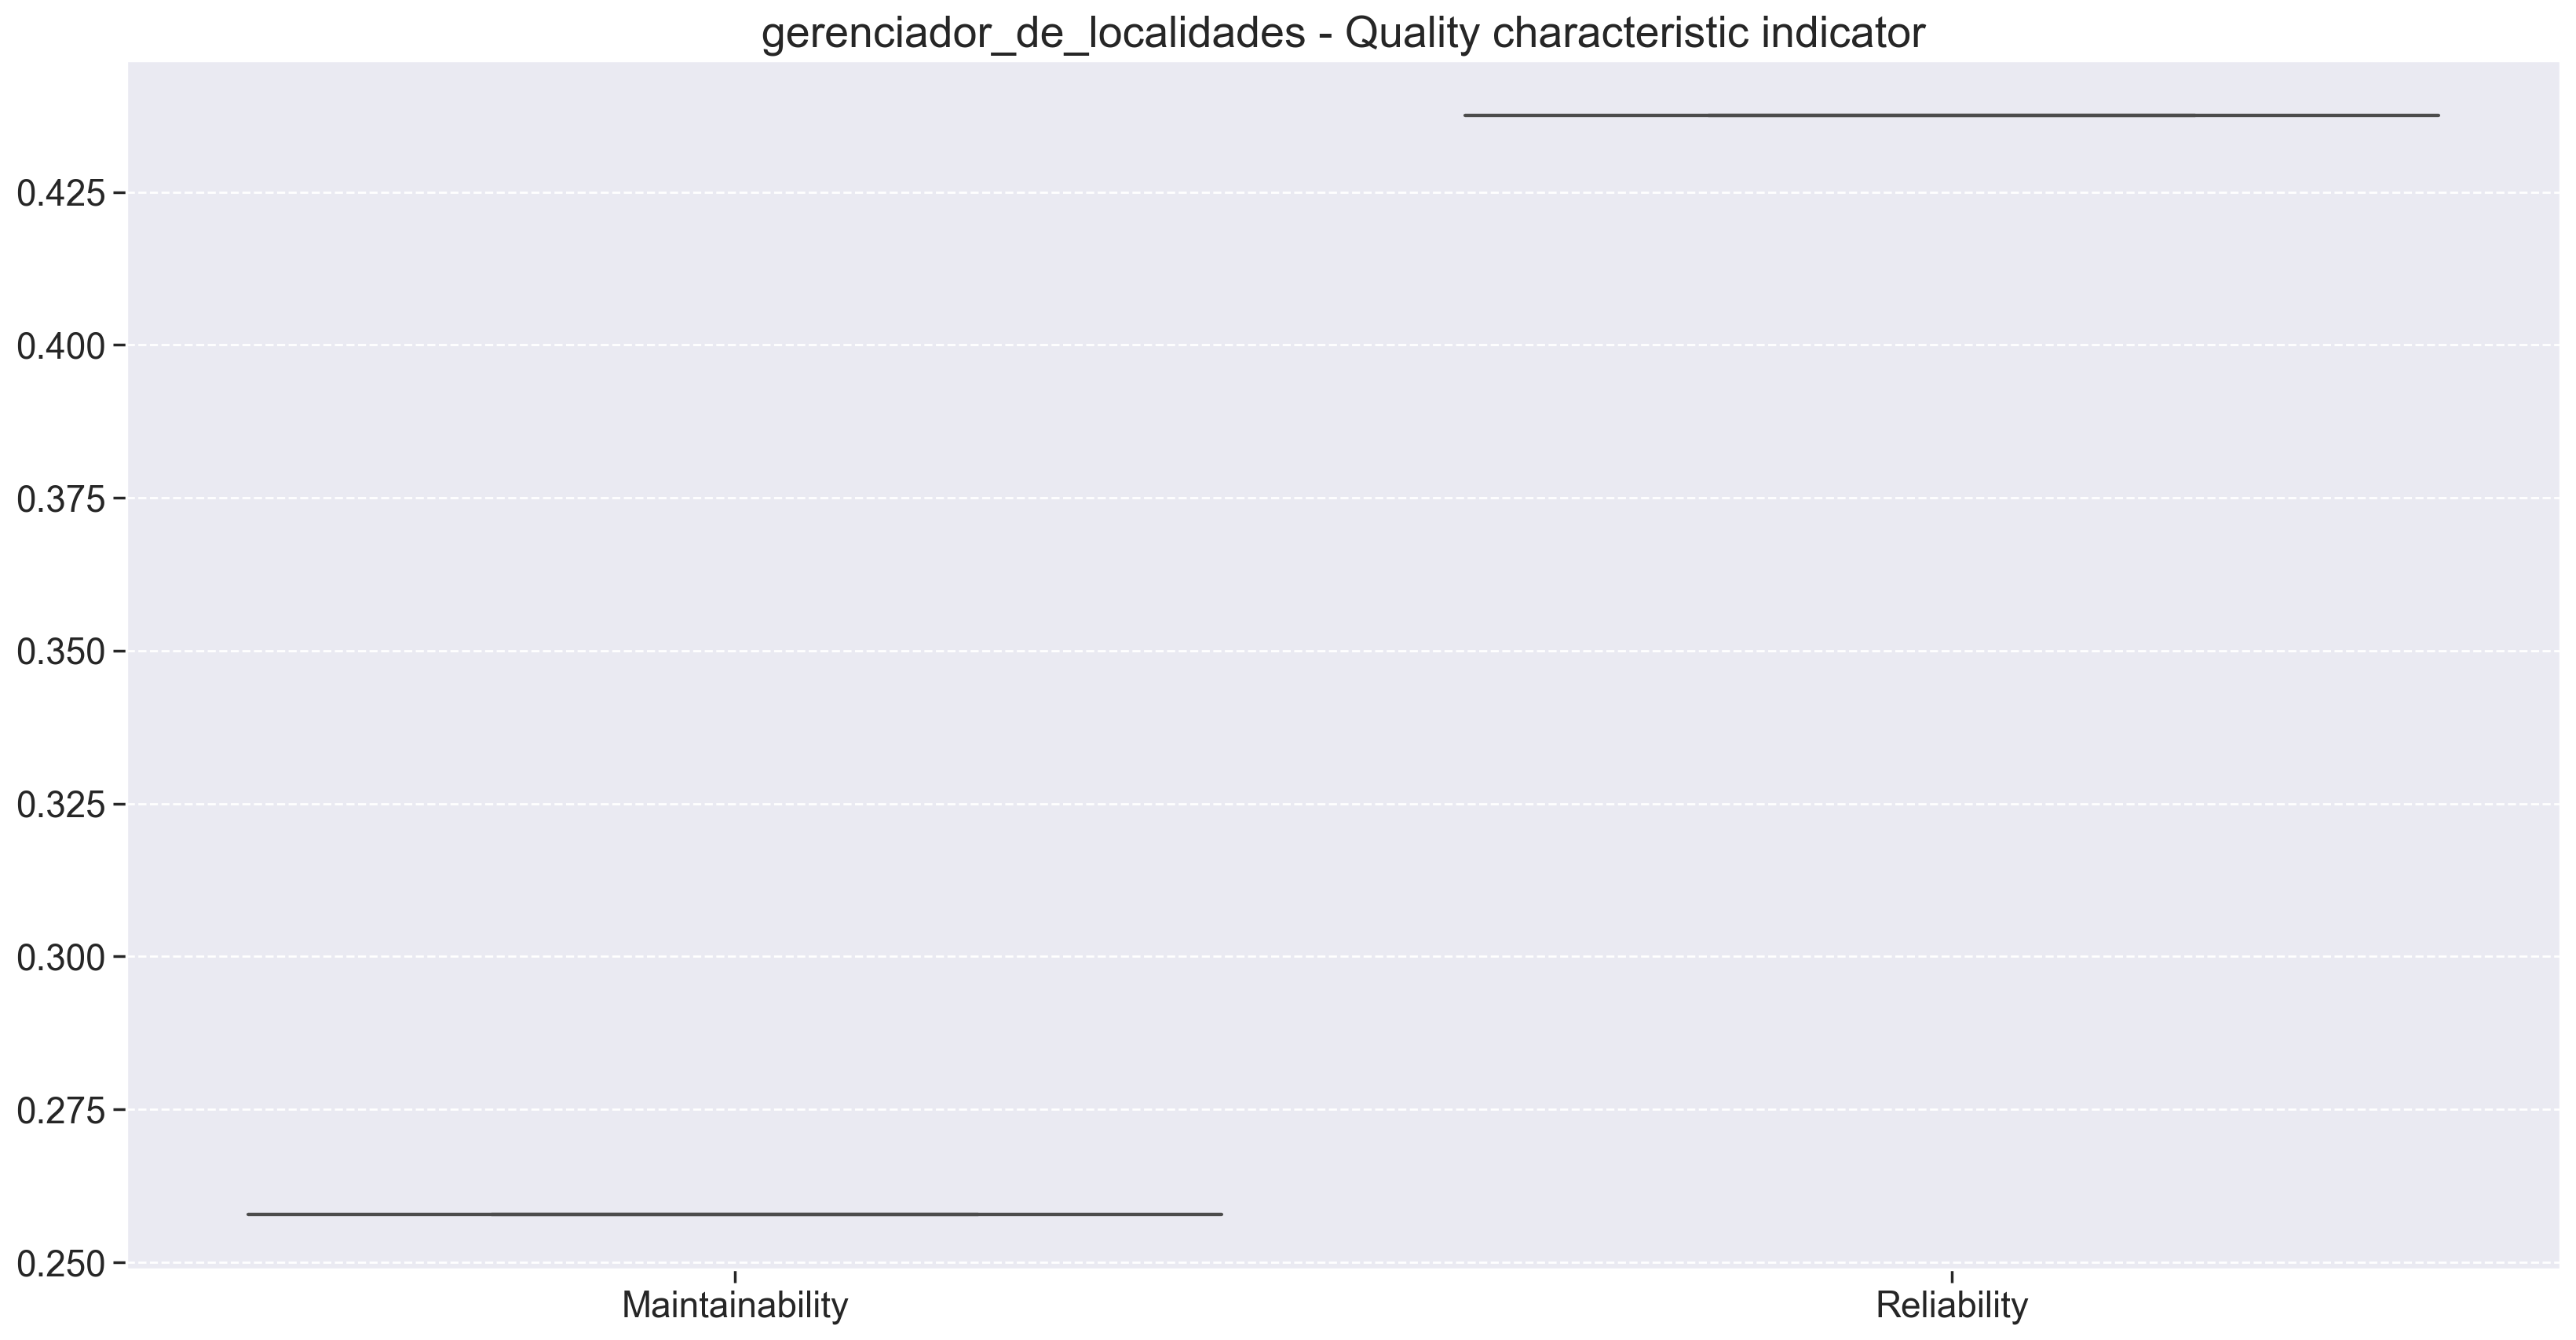

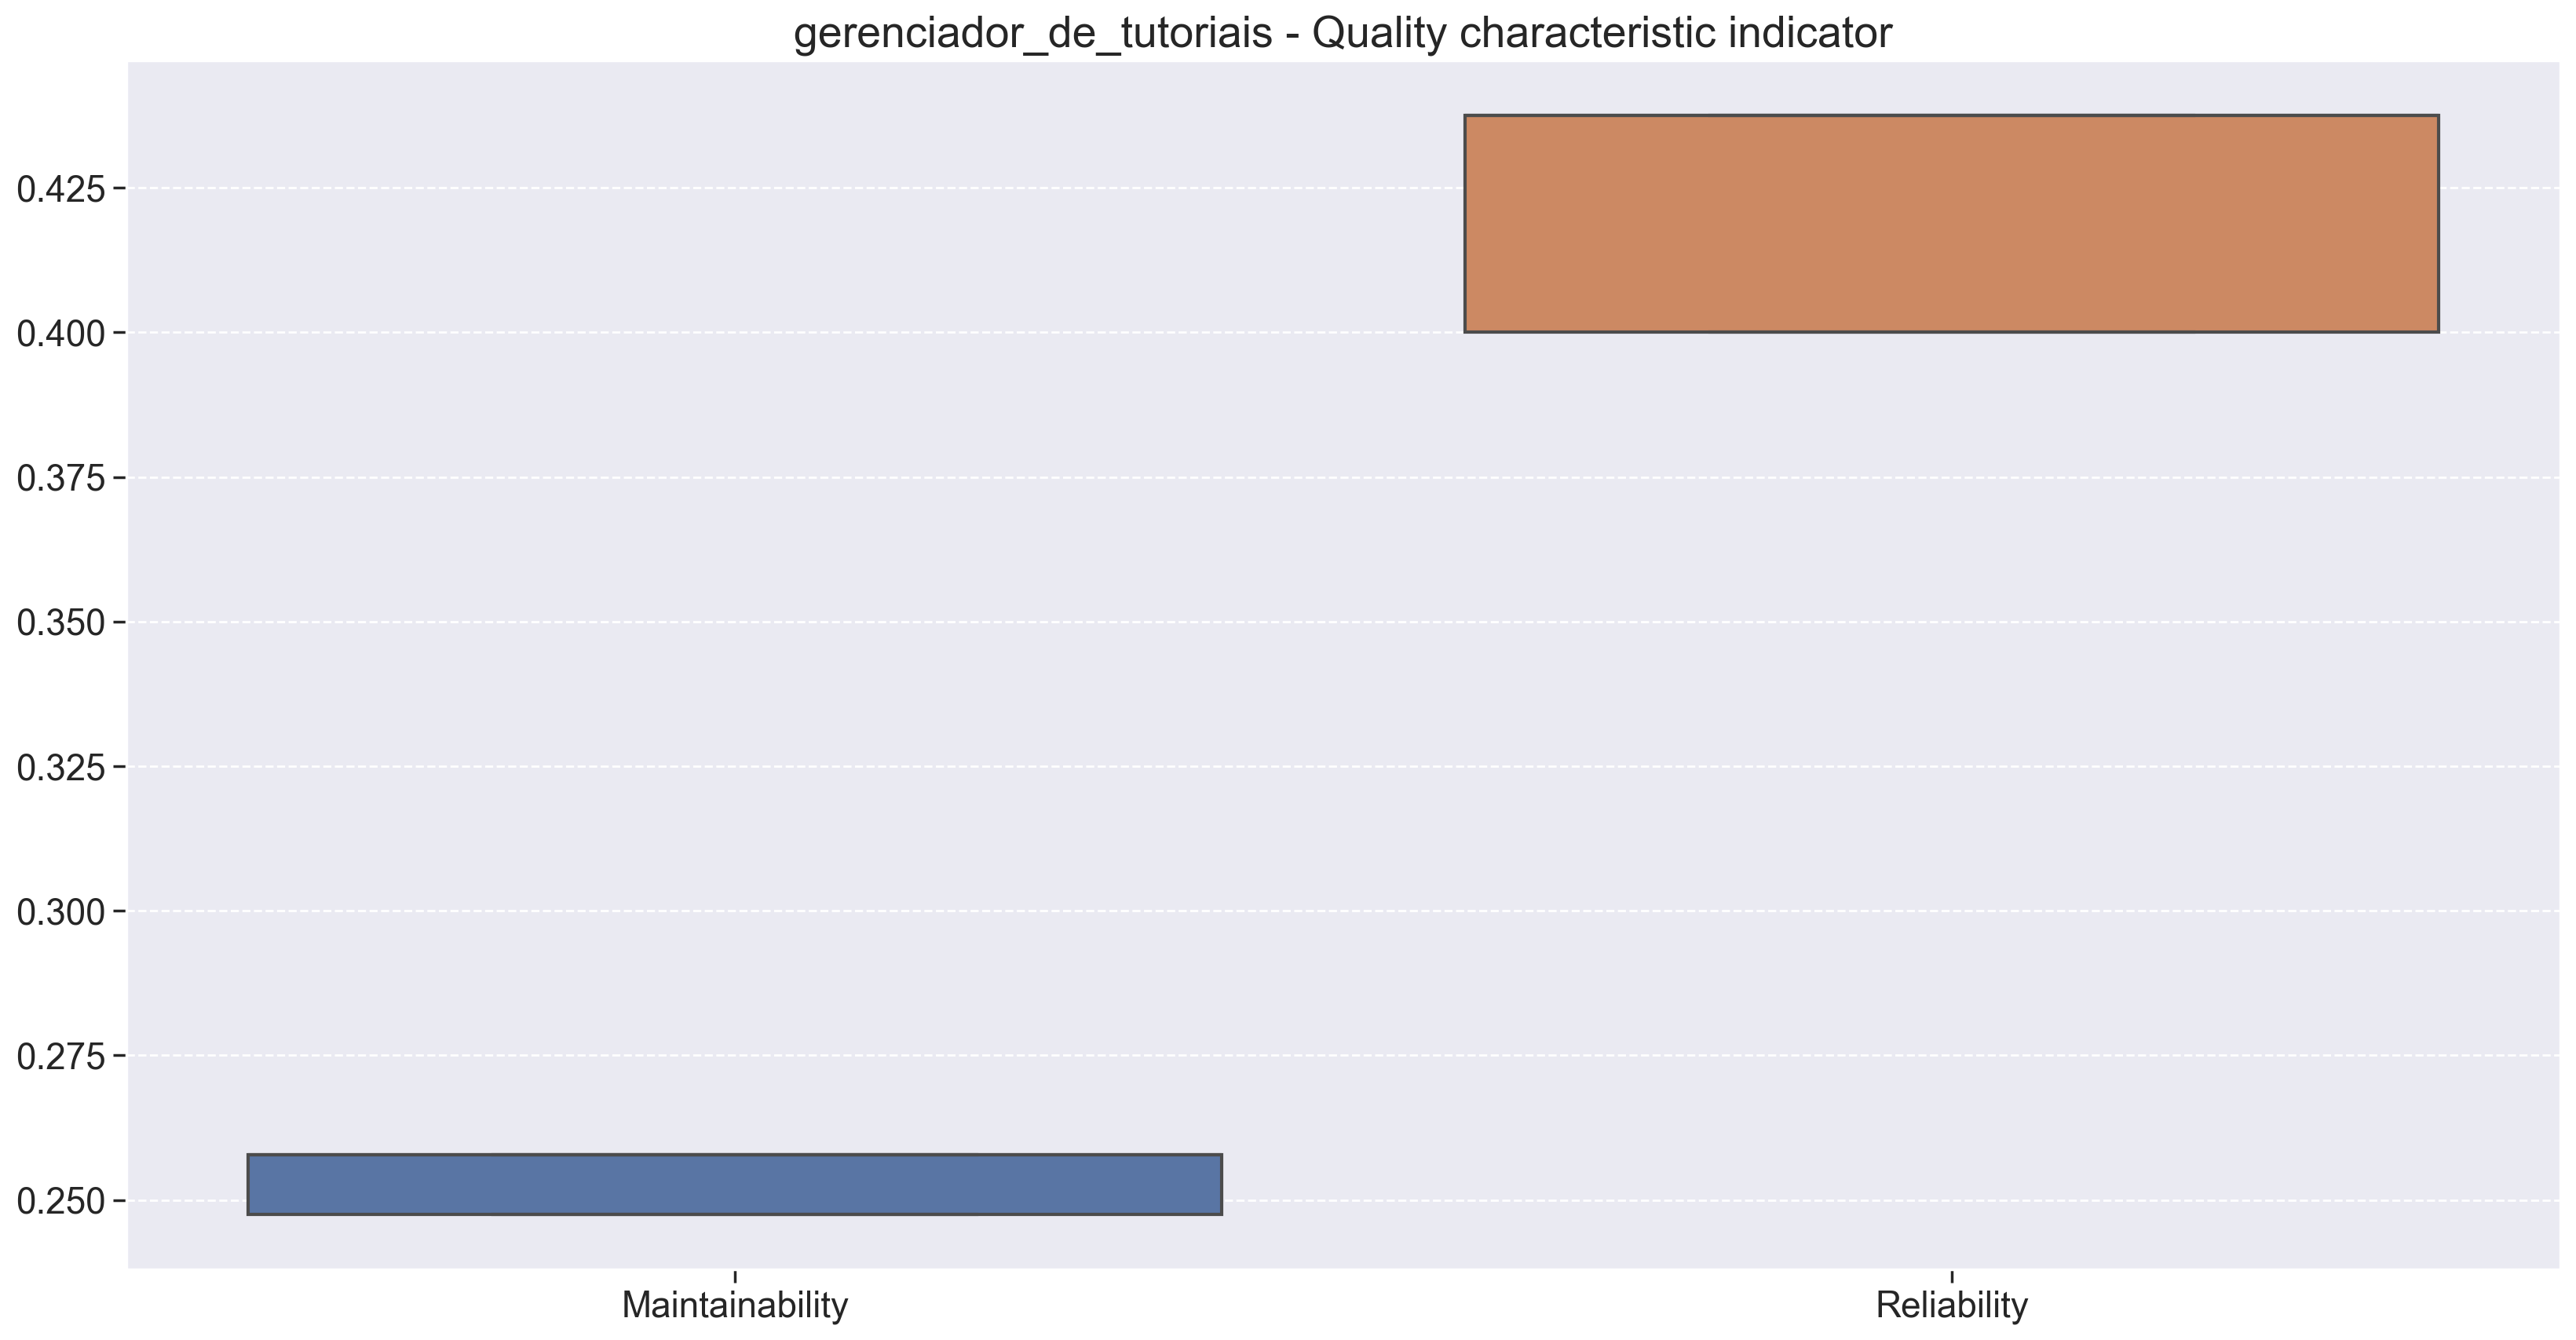

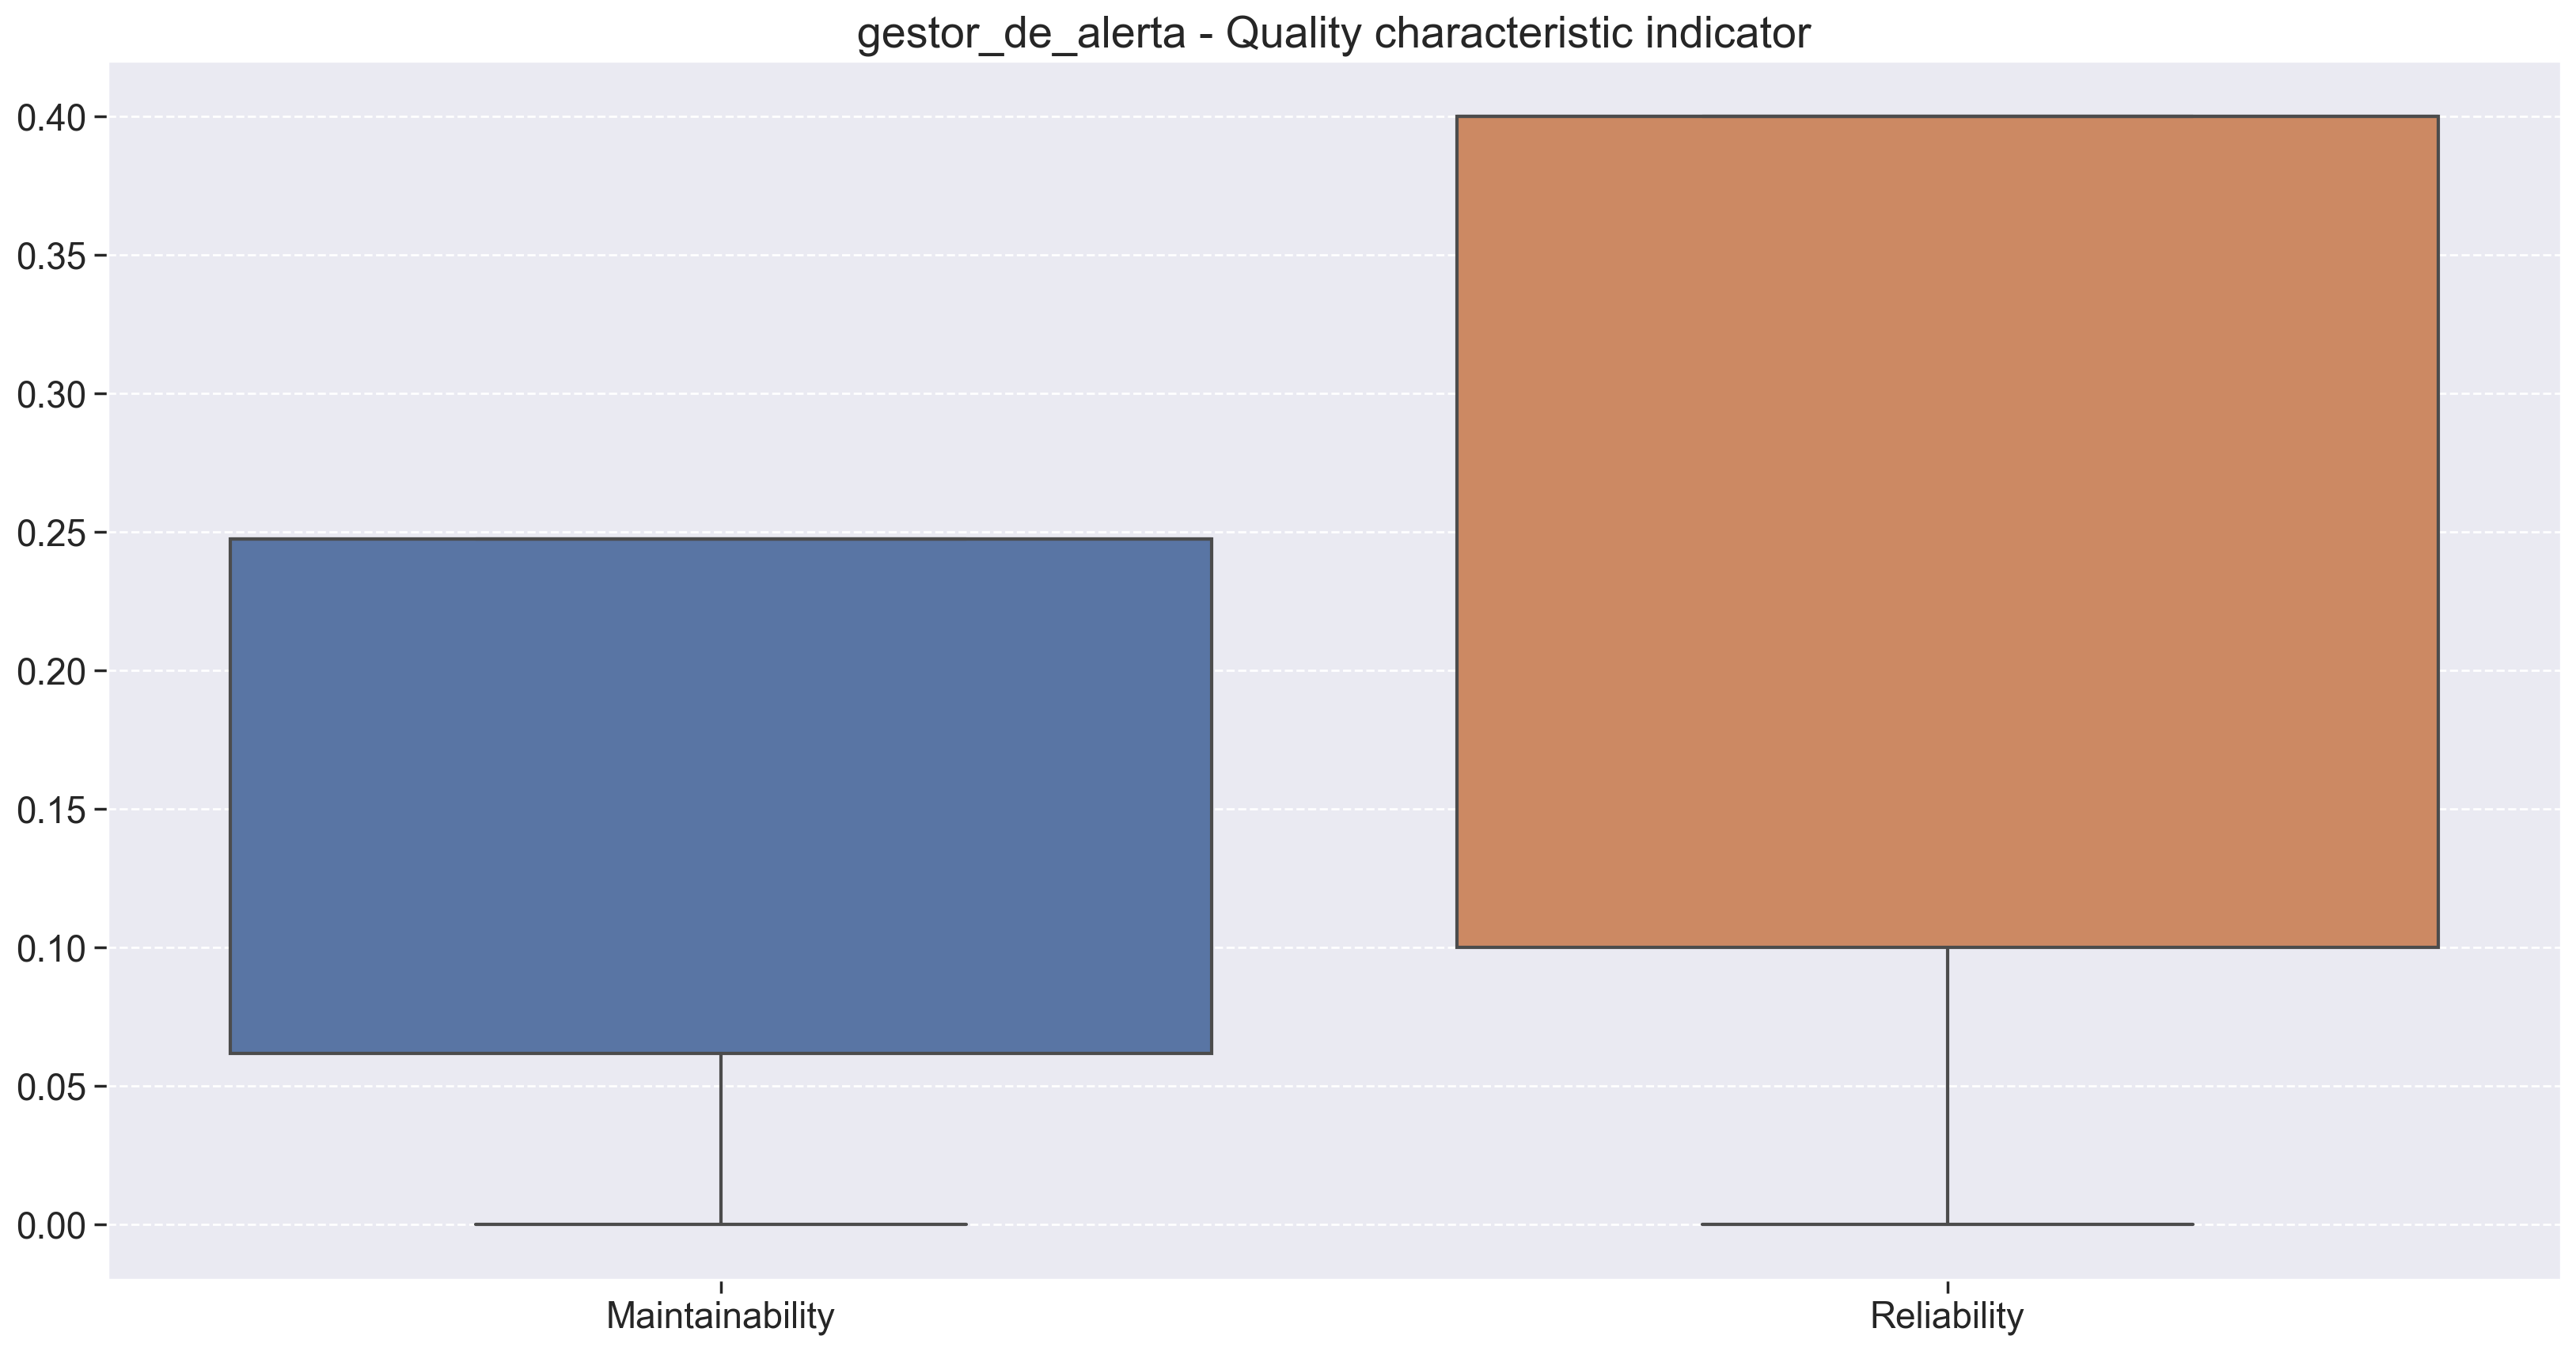

In [84]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

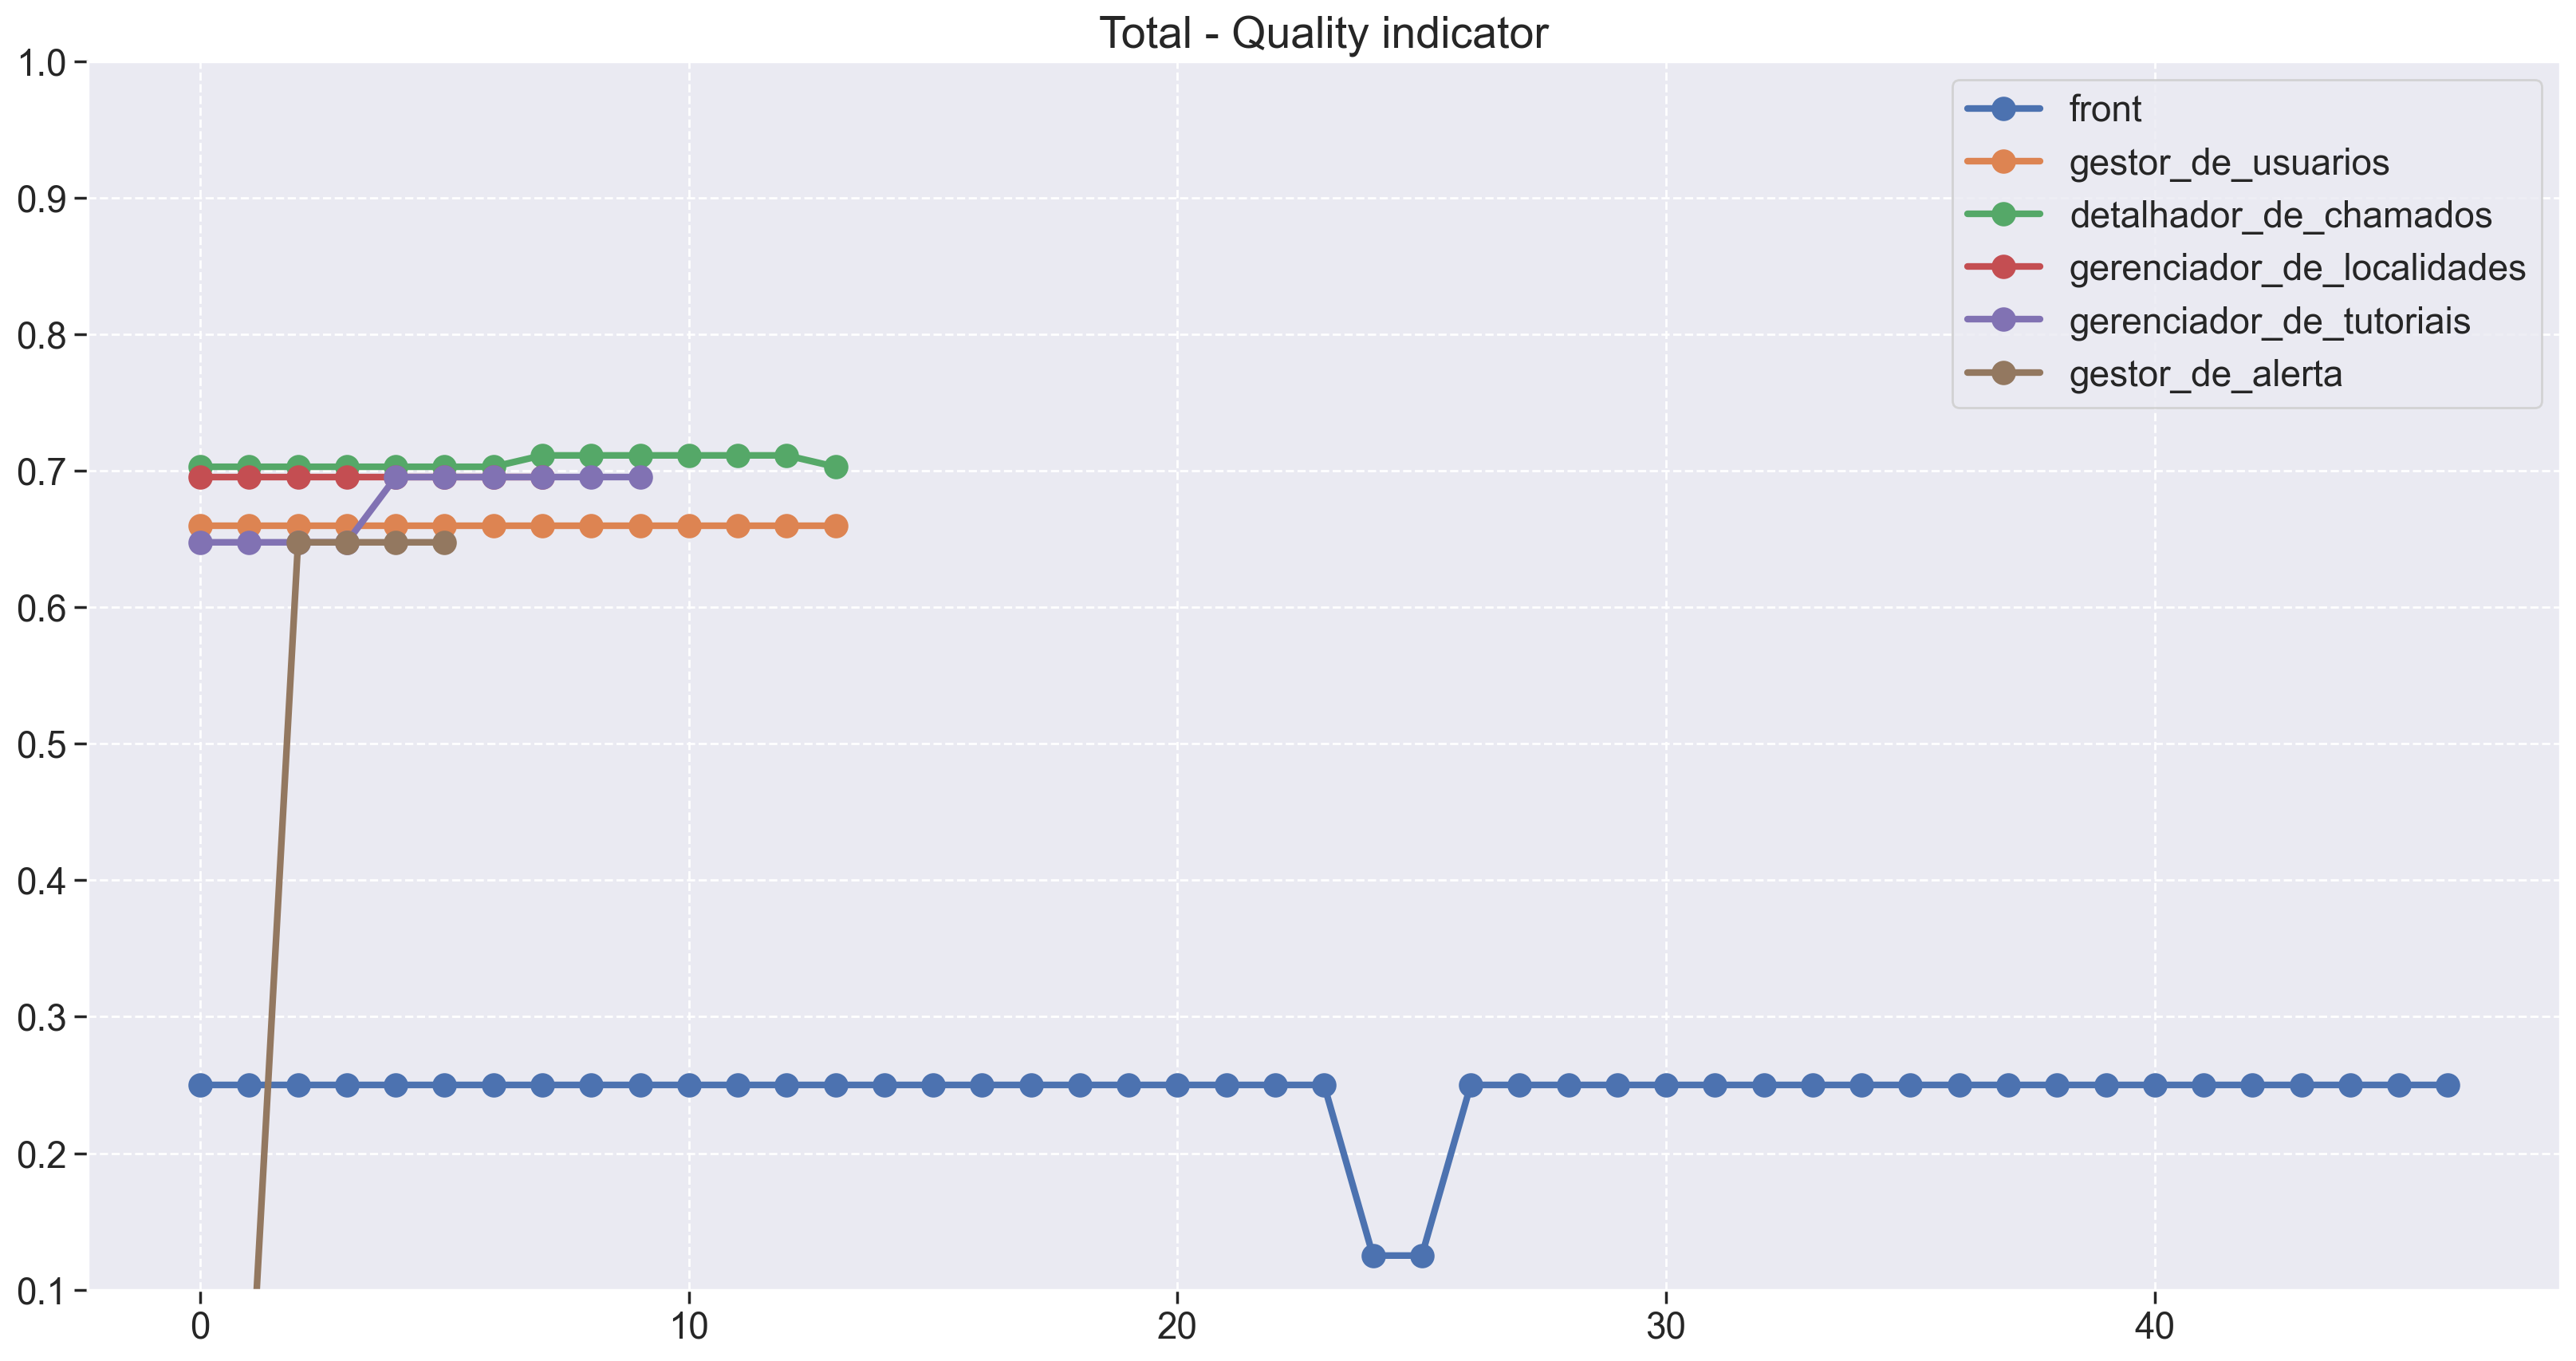

In [85]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [86]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('../data/fga-eps-mds-2023-1-schedula--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('../data/fga-eps-mds-2023-1-schedula--{}.csv'.format(current_datetime), index = False)

m1        m2   m3   m4   m5        m6  \
0   0.000000  0.000000  0.0  1.0  1.0  0.000000   
1   0.000000  0.000000  0.0  1.0  1.0  0.000000   
2   0.000000  0.000000  0.0  1.0  1.0  0.000000   
3   0.000000  0.000000  0.0  1.0  1.0  0.000000   
4   0.000000  0.000000  0.0  1.0  1.0  0.000000   
5   0.000000  0.000000  0.0  1.0  1.0  0.000000   
6   0.000000  0.000000  0.0  1.0  1.0  0.000000   
7   0.000000  0.000000  0.0  1.0  1.0  0.000000   
8   0.000000  0.000000  0.0  1.0  1.0  0.000000   
9   0.000000  0.000000  0.0  1.0  1.0  0.000000   
10  0.000000  0.000000  0.0  1.0  1.0  0.000000   
11  0.000000  0.000000  0.0  1.0  1.0  0.000000   
12  0.000000  0.000000  0.0  1.0  1.0  0.000000   
13  0.000000  0.000000  0.0  1.0  1.0  0.000000   
14  0.000000  0.000000  0.0  1.0  1.0  0.000000   
15  0.000000  0.000000  0.0  1.0  1.0  0.000000   
16  0.000000  0.000000  0.0  1.0  1.0  0.000000   
17  0.000000  0.000000  0.0  1.0  1.0  0.000000   
18  0.000000  0.000000  0.0  1.0  1.0  0.000000   
19  0.000000  0.000000  0.0  1.0  1.0  0.000000   
20  0.000000  0.000000  0.0  1.0  1.0  0.000000   
21  0.000000  0.000000  0.0  1.0  1.0  0.000000   
22  0.000000  0.000000  0.0  1.0  1.0  0.000000   
23  0.000000  0.000000  0.0  1.0  1.0  0.000000   
24  0.000000  0.000000  0.0  0.0  1.0  0.000000   
25  0.000000  0.000000  0.0  0.0  1.0  0.000000   
26  0.000000  0.000000  0.0  1.0  1.0  0.000000   
27  0.000000  0.000000  0.0  1.0  1.0  0.000000   
28  0.000000  0.000000  0.0  1.0  1.0  0.000000   
29  0.000000  0.000000  0.0  1.0  1.0  0.000000   
30  0.000000  0.000000  0.0  1.0  1.0  0.000000   
31  0.000000  0.000000  0.0  1.0  1.0  0.000000   
32  0.000000  0.000000  0.0  1.0  1.0  0.000000   
33  0.000000  0.000000  0.0  1.0  1.0  0.000000   
34  0.000000  0.000000  0.0  1.0  1.0  0.000000   
35  0.000000  0.000000  0.0  1.0  1.0  0.000000   
36  0.000000  0.000000  0.0  1.0  1.0  0.000000   
37  0.000000  0.000000  0.0  1.0  1.0  0.000000   
38  0.000000  0.000000  0.0  1.0  1.0  0.000000   
39  0.000000  0.000000  0.0  1.0  1.0  0.000000   
40  0.000000  0.000000  0.0  1.0  1.0  0.000000   
41  0.000000  0.000000  0.0  1.0  1.0  0.000000   
42  0.000000  0.000000  0.0  1.0  1.0  0.000000   
43  0.000000  0.000000  0.0  1.0  1.0  0.000000   
44  0.000000  0.000000  0.0  1.0  1.0  0.000000   
45  0.000000  0.000000  0.0  1.0  1.0  0.000000   
46  0.000000  0.000000  0.0  1.0  1.0  0.000000   
47  0.380952  0.380952  1.0  1.0  1.0  0.476190   
48  0.380952  0.380952  1.0  1.0  1.0  0.476190   
49  0.380952  0.380952  1.0  1.0  1.0  0.476190   
50  0.380952  0.380952  1.0  1.0  1.0  0.476190   
51  0.380952  0.380952  1.0  1.0  1.0  0.476190   
52  0.380952  0.380952  1.0  1.0  1.0  0.476190   
53  0.380952  0.380952  1.0  1.0  1.0  0.476190   
54  0.380952  0.380952  1.0  1.0  1.0  0.476190   
55  0.380952  0.380952  1.0  1.0  1.0  0.476190   
56  0.380952  0.380952  1.0  1.0  1.0  0.476190   
57  0.380952  0.380952  1.0  1.0  1.0  0.476190   
58  0.380952  0.380952  1.0  1.0  1.0  0.476190   
59  0.380952  0.380952  1.0  1.0  1.0  0.476190   
60  0.380952  0.380952  1.0  1.0  1.0  0.476190   
61  0.633333  0.000000  1.0  1.0  1.0  0.733333   
62  0.633333  0.000000  1.0  1.0  1.0  0.733333   
63  0.633333  0.000000  1.0  1.0  1.0  0.733333   
64  0.633333  0.000000  1.0  1.0  1.0  0.733333   
65  0.633333  0.000000  1.0  1.0  1.0  0.733333   
66  0.633333  0.000000  1.0  1.0  1.0  0.733333   
67  0.633333  0.000000  1.0  1.0  1.0  0.733333   
68  0.633333  0.000000  1.0  1.0  1.0  0.766667   
69  0.633333  0.000000  1.0  1.0  1.0  0.766667   
70  0.633333  0.000000  1.0  1.0  1.0  0.766667   
71  0.633333  0.000000  1.0  1.0  1.0  0.766667   
72  0.633333  0.000000  1.0  1.0  1.0  0.766667   
73  0.633333  0.000000  1.0  1.0  1.0  0.766667   
74  0.633333  0.000000  1.0  1.0  1.0  0.733333   
75  0.562500  0.000000  1.0  1.0  1.0  0.750000   
76  0.562500  0.000000  1.0  1.0  1.0  0.750000   
77  0.562500  0.000000  1.0  1.0